In [3]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import requests
import matplotlib.colors
from sklearn.impute import SimpleImputer
import cv2
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml')
import folium
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("/content/MyDrive/MyDrive/clean_daily_air_quality_data.csv")
data.head()

Date           state      city agency     station_location  \
0  2016-07-01  Andhra Pradesh  Tirupati  APPCB  Tirumala, Tirupati    
1  2016-07-02  Andhra Pradesh  Tirupati  APPCB  Tirumala, Tirupati    
2  2016-07-03  Andhra Pradesh  Tirupati  APPCB  Tirumala, Tirupati    
3  2016-07-04  Andhra Pradesh  Tirupati  APPCB  Tirumala, Tirupati    
4  2016-07-05  Andhra Pradesh  Tirupati  APPCB  Tirumala, Tirupati    

   CO (ug/m3)  PM10 (ug/m3)  PM2.5 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
0         NaN     50.791667      12.236667   14.444167    38.509167   
1         NaN     67.738667      22.278000   26.850667    46.828667   
2         NaN     46.146250      14.162500   12.116250    41.458750   
3         NaN     24.153684       5.842105    7.357895    39.178947   
4         NaN     17.228750       4.718750   15.559167    39.981667   

   NOx (ppb)  Ozone (ug/m3)  SO2 (ug/m3)  AT (degree C)     RH (%)  
0  29.557500      14.000000     6.300000      24.229000  66.014167  
1  42.770667      12.978667     4.857143      24.908000  65.222000  
2  29.240833      13.608696     5.558261      23.928750  67.645833  
3  24.560526      14.036316     5.878333      22.967368  72.451579  
4  31.032917      14.349583     5.072609      23.049167  71.472083

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

In [6]:
data.columns

Index(['Date', 'state', 'city', 'agency', 'station_location', 'CO (ug/m3)',
       'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'Ozone (ug/m3)', 'SO2 (ug/m3)', 'AT (degree C)', 'RH (%)',
       'Year'],
      dtype='object')

In [7]:
print("Range of years being studied: ", sorted(list(data['Year'].unique()))[:-1])

Range of years being studied:  [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


## AQ Monitoring Station Data

In [8]:
print('Number of Air Quality Monitoring Stations:', len(data['station_location'].unique()))

Number of Air Quality Monitoring Stations: 450


In [ ]:
def get_coordinates_from_address(address):

    try:
        response = requests.get(f"https://nominatim.openstreetmap.org/search?q={address}&format=json")
        data = response.json()

        if data:
            latitude = float(data[0]["lat"])
            longitude = float(data[0]["lon"])
            return latitude, longitude

    except Exception as e:
        print(f"Error while calling Nominatim API: {e}")

    return None

locations = [loc.split(",")[1].strip() for loc in data['station_location'].unique()]
lat_long = [get_coordinates_from_address(address) for address in locations]

In [ ]:
lat_long_data = pd.DataFrame(columns = ['Location', 'Latitude', 'Longitude'])
lat_long_data['Location'] = locations
lat_long_data['Latitude'] = [first_lat if first_lat else None for first_lat in (lat[0] if lat else None for lat in lat_long)]
lat_long_data['Longitude'] = [first_lat if first_lat else None for first_lat in (lat[1] if lat else None for lat in lat_long)]
lat_long_data.to_csv('lat_long_data.csv', index = False)

In [ ]:
lat_long_data = pd.read_csv('lat_long_data.csv')
lat_long = list(zip(lat_long_data["Latitude"].tolist(), lat_long_data["Longitude"].tolist()))
locations = [loc.split(",")[1].strip() for loc in data['station_location'].unique()]

# Create a map centered around India
map = folium.Map(location=[22.3511148, 78.6677428], zoom_start=5)

# Add markers
for idx, some in enumerate(lat_long):
    lat, lon = some
    name = locations[idx]
    try:
      folium.Marker([lat, lon], popup=name, icon=folium.Icon(icon = 'location-dot', icon_color = "red", prefix = 'fa', icon_size=(5,5))).add_to(map)
    except:
      pass

# Save the map as an HTML file
map.save("map_of_locations.html")


## Pollutant Concentrations




In [9]:
pollutants = ['CO (ug/m3)',
       'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'Ozone (ug/m3)', 'SO2 (ug/m3)']

### What is the distribution of each pollutant across the dataset?


In [ ]:
poll_data = pd.DataFrame(columns = ["Concentration (ug/m3)", "Pollutant"])
for pollutant in pollutants:
  if pollutant == 'NOx (ppb)':
    continue
  inter_data = pd.DataFrame(columns = ["Concentration (ug/m3)", "Pollutant"])
  inter_data["Concentration (ug/m3)"] = data.loc[(data[pollutant].notna()) & (data[pollutant] > 0), pollutant]
  inter_data["Pollutant"] = pollutant
  poll_data = pd.concat([poll_data, inter_data])

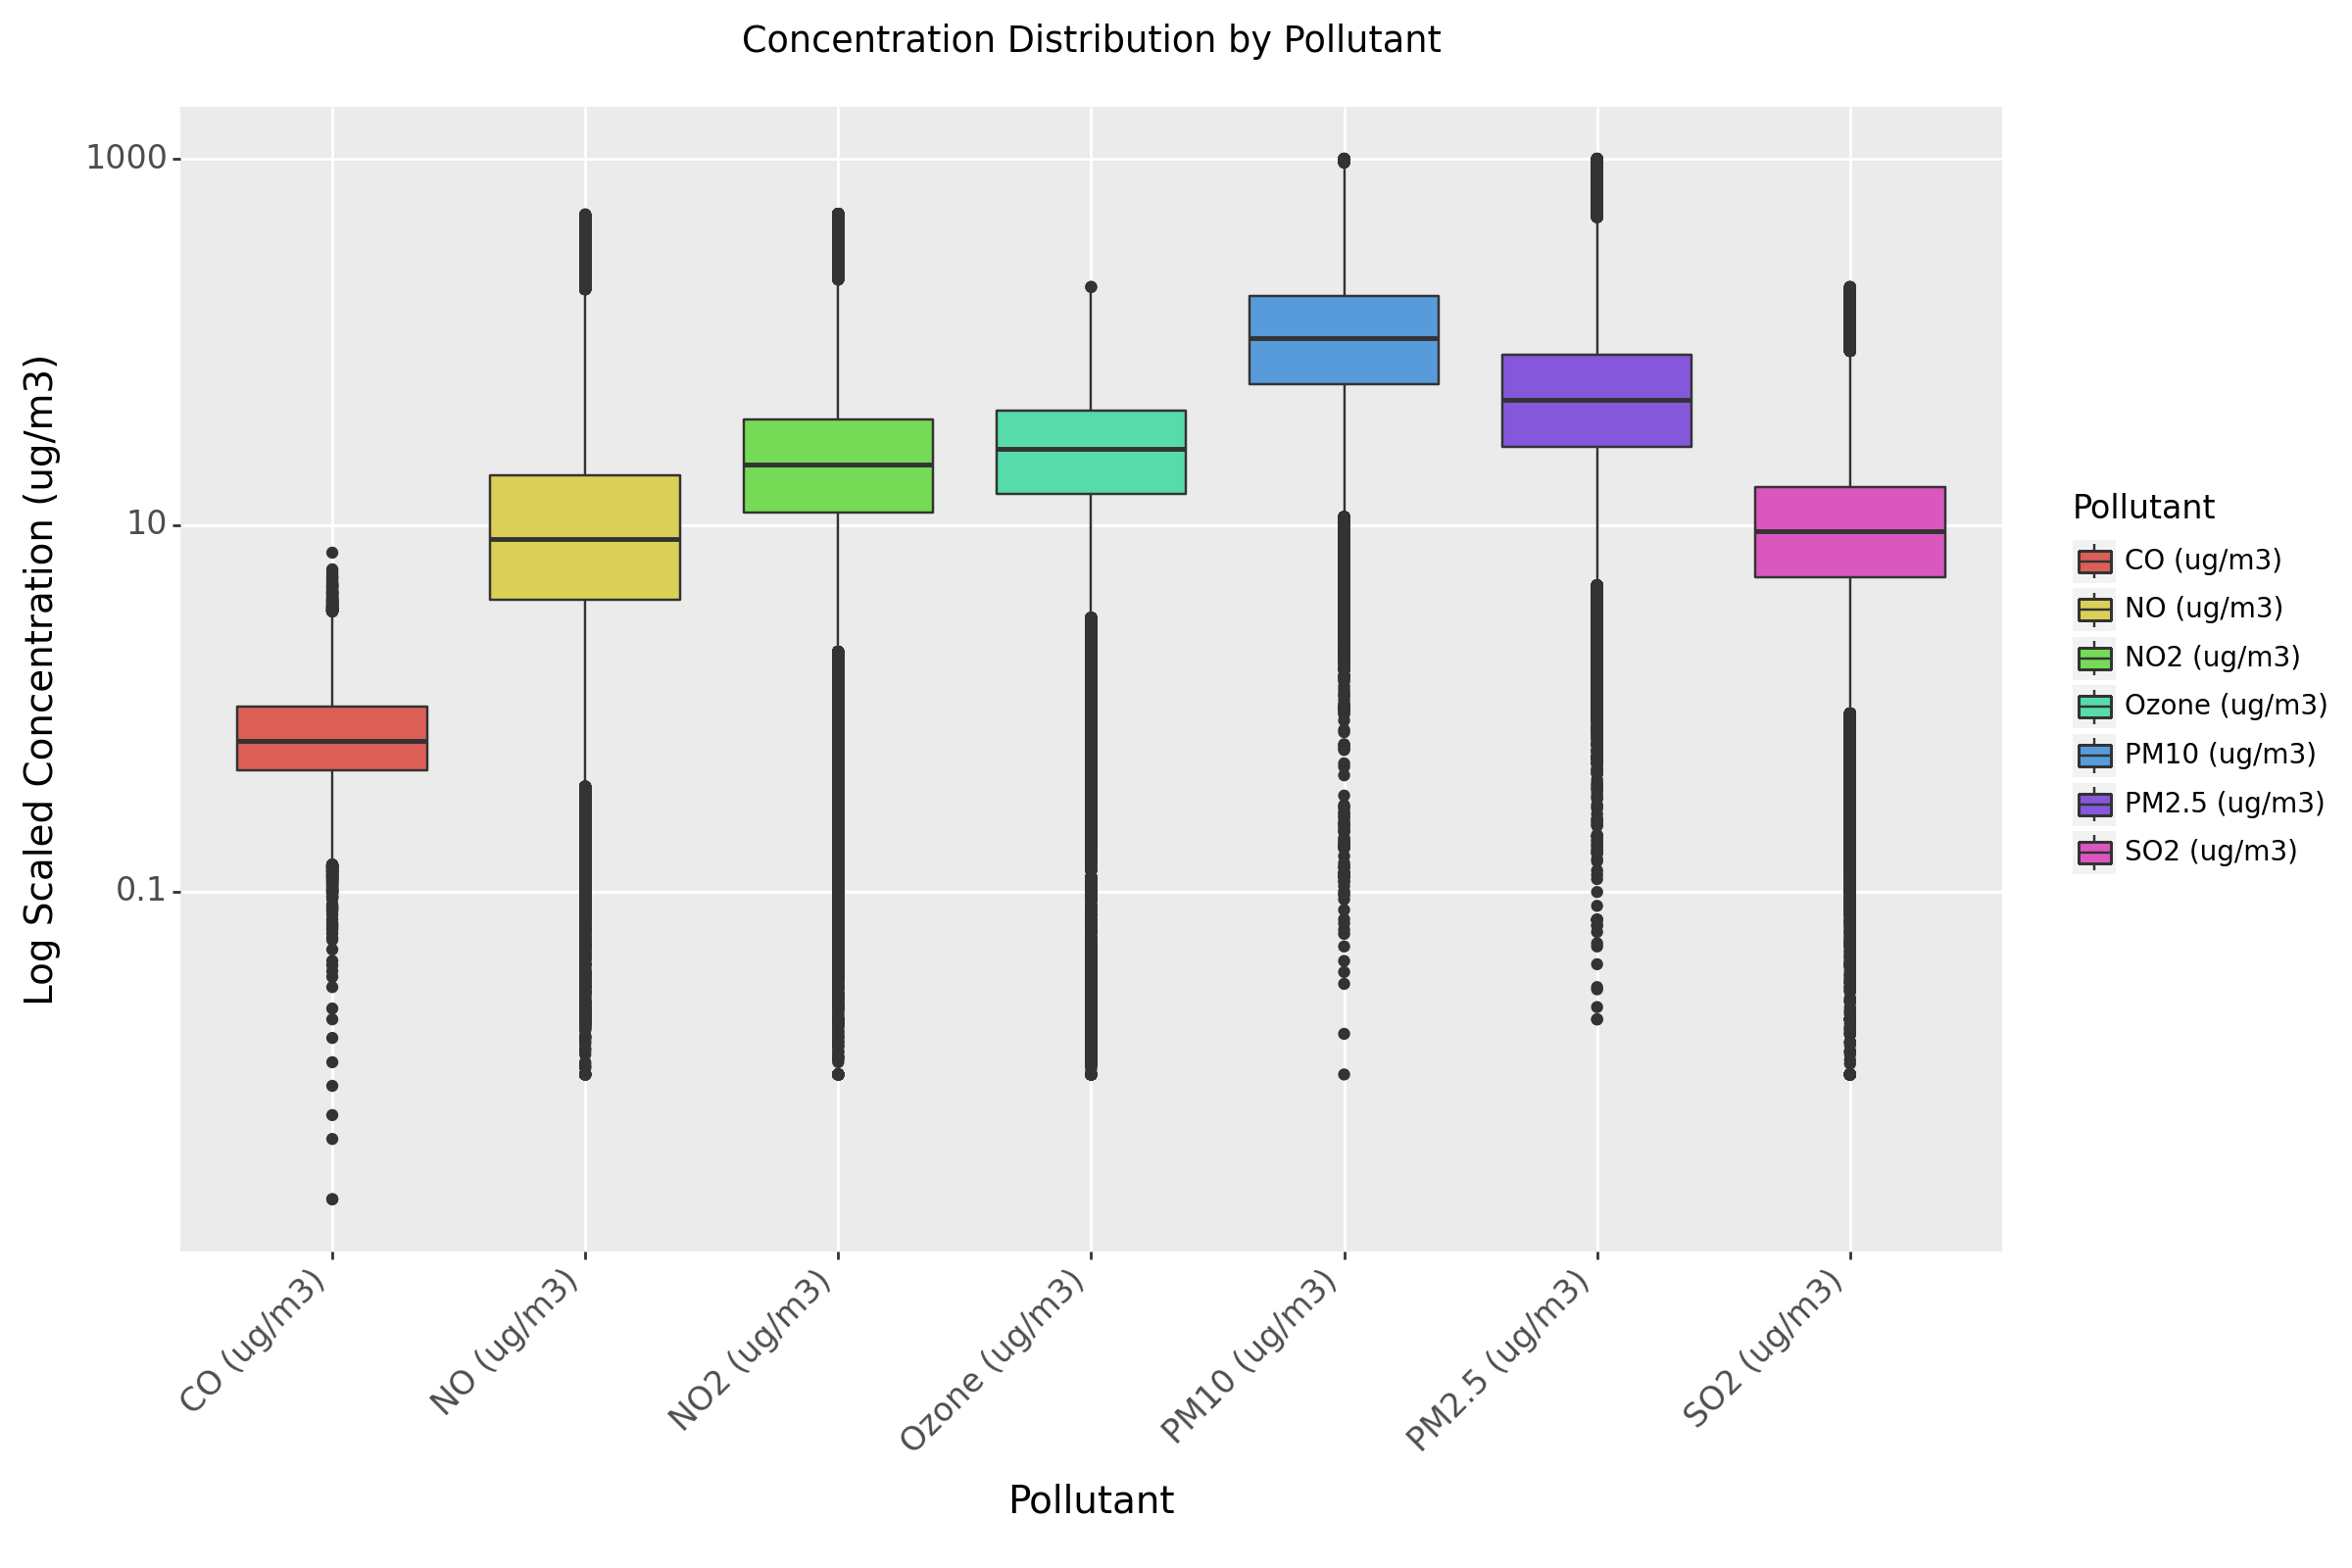

In [ ]:
plot = (
    ggplot(poll_data, aes(x="Pollutant", y="Concentration (ug/m3)", fill = "Pollutant"))
    + geom_boxplot()
    + scale_y_log10()
    + scale_x_discrete(name="Pollutant")
    + labs(y="Log Scaled Concentration (ug/m3)", title="Concentration Distribution by Pollutant")
    + theme(figure_size=(12, 8), axis_text_x=element_text(rotation=45, hjust=1), plot_title=element_text(hjust=0.5))
    + theme(panel_grid_minor=element_blank())

)

# Display the plot
print(
    plot + theme(
    legend_title=element_text(size=12),
    legend_text=element_text(size=10),
    axis_title=element_text(size=14),
    axis_text=element_text(size=12)
    )
)

In [ ]:
def plot_concentrations(pollutant, threshold):
    plot = (
        ggplot(data.loc[data[pollutant].notna() & (data[pollutant] > 0)], aes(x=pollutant)) +
        geom_histogram(binwidth=5, fill='blue', color='black') +
        geom_vline(xintercept=threshold, color='red', linetype='dashed', size=1) +  # Adding threshold line
        labs(title=f'Histogram of {pollutant.split("(")[0].strip()} Concentrations', x=f'{pollutant} Concentration', y='Frequency') +
        theme_minimal()
    )
    plot = plot + theme(
    panel_background=element_rect(fill='white'),  # White panel background
    plot_background=element_rect(fill='white', color='black')  # White plot background with a black border
)
    print(plot)


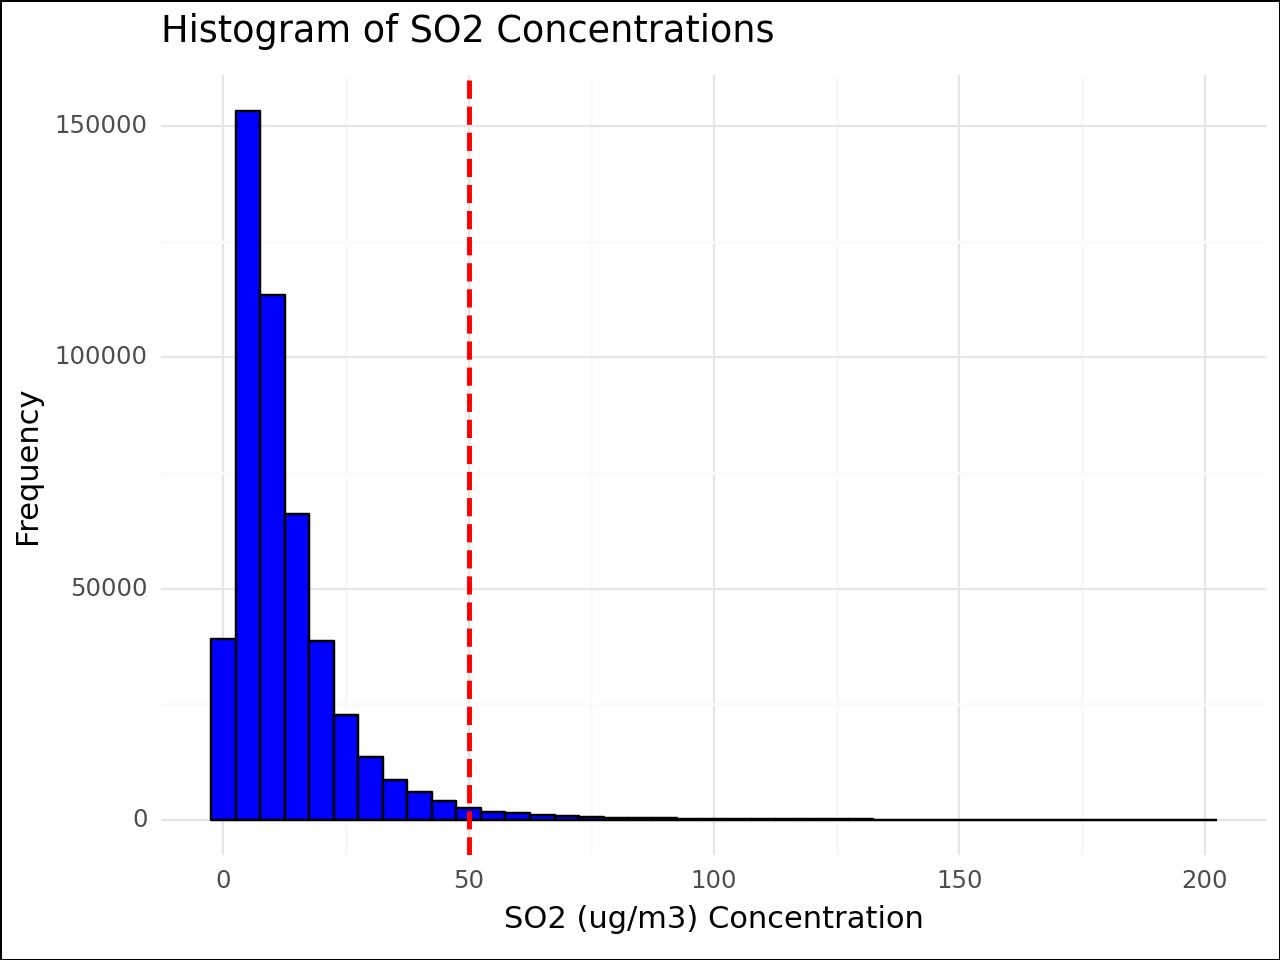

In [ ]:
plot_concentrations('SO2 (ug/m3)', 50)

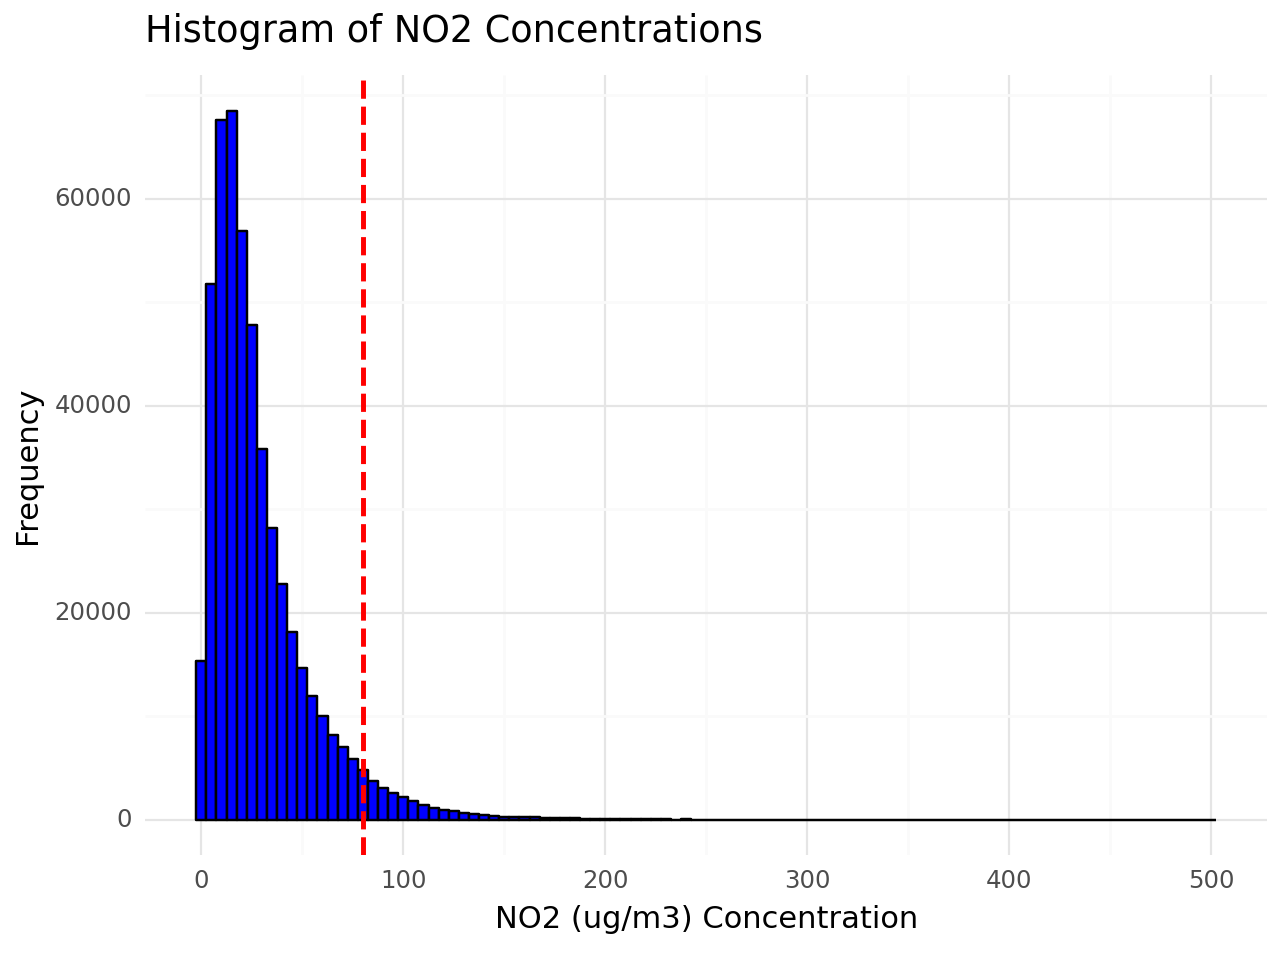

In [ ]:
plot_concentrations('NO2 (ug/m3)', 80)

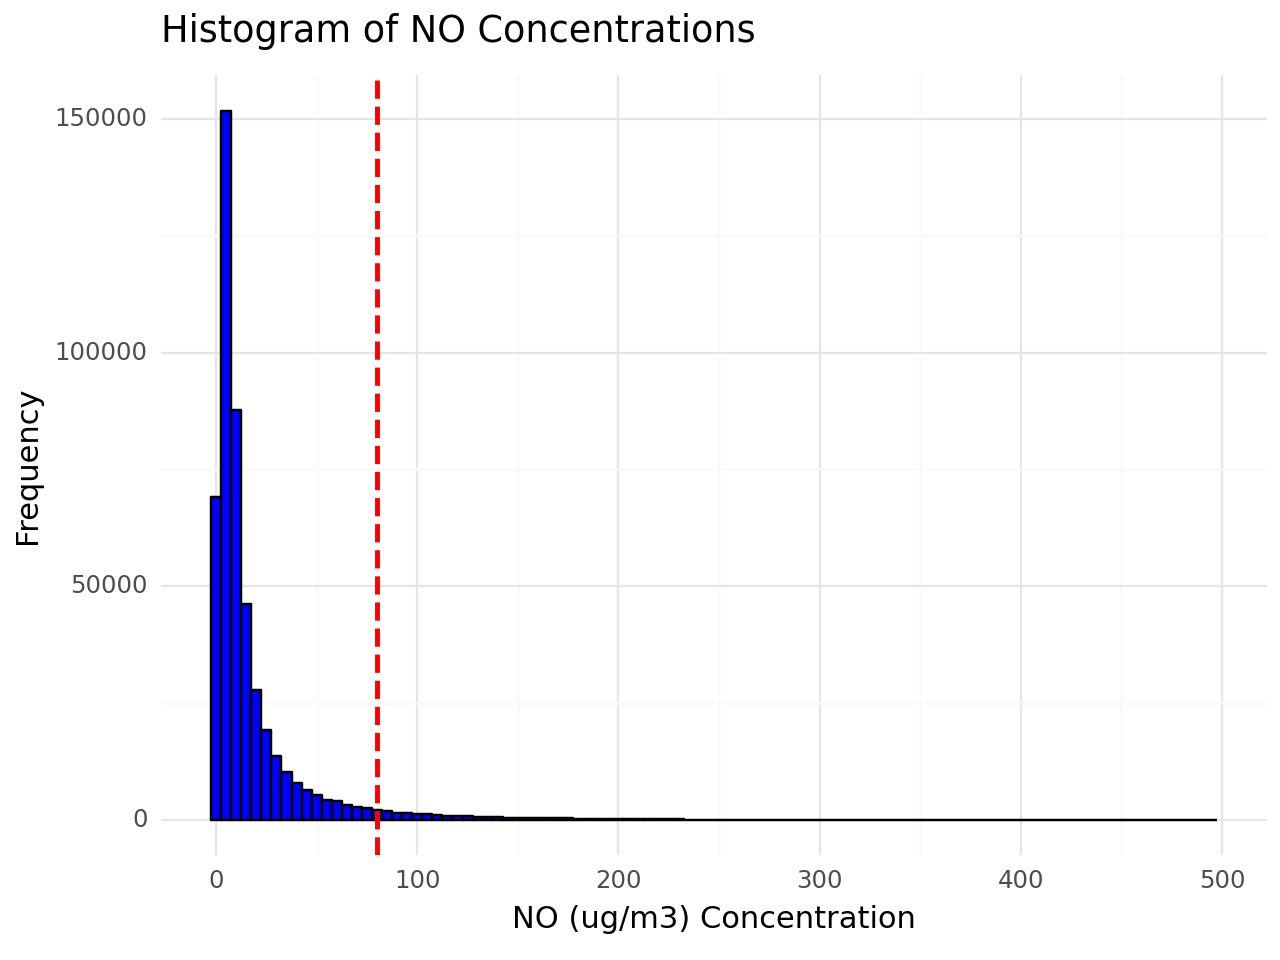

In [ ]:
plot_concentrations('NO (ug/m3)', 80)

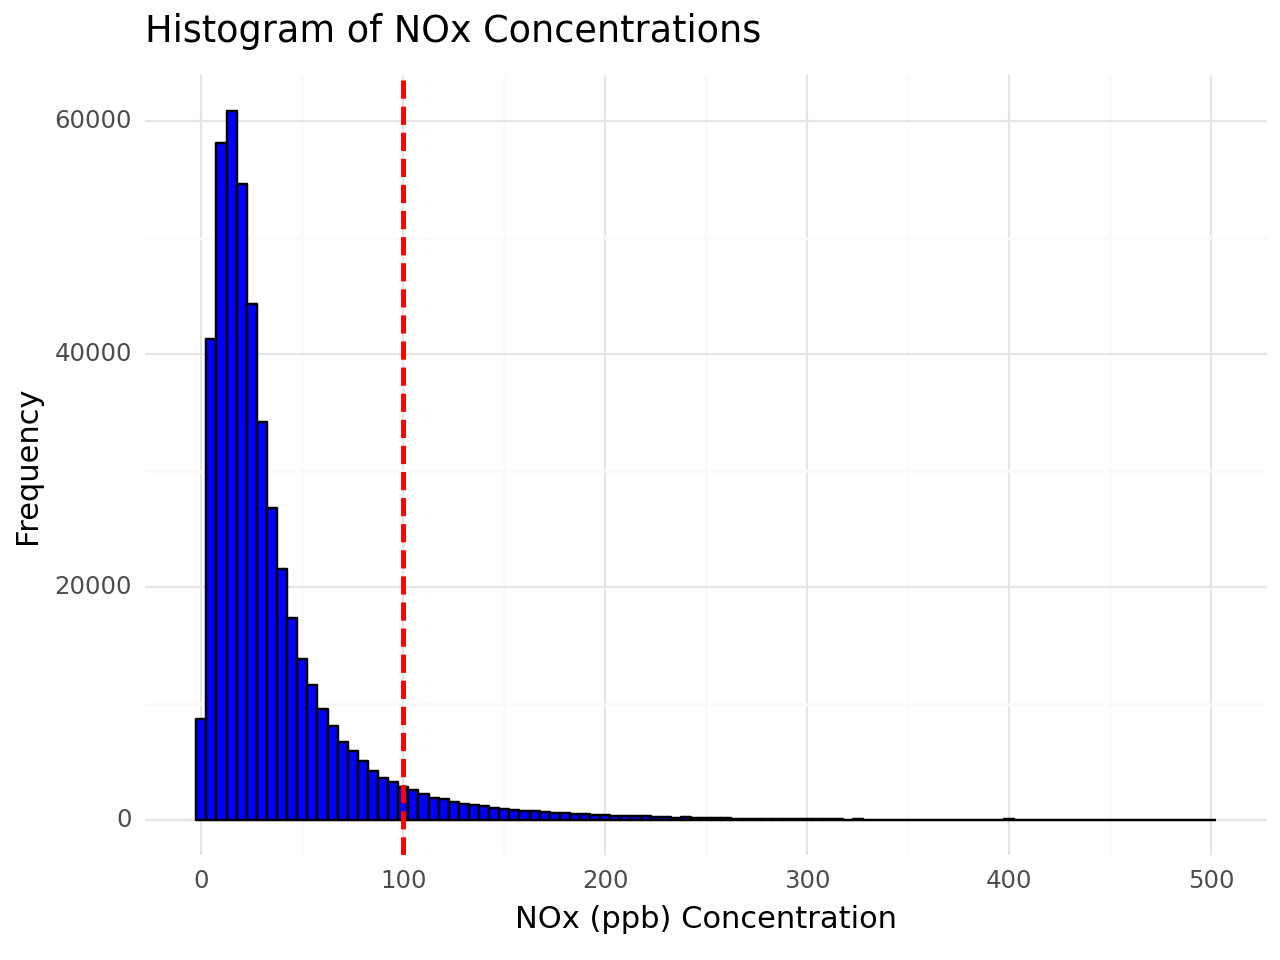

In [ ]:
plot_concentrations('NOx (ppb)', 100)

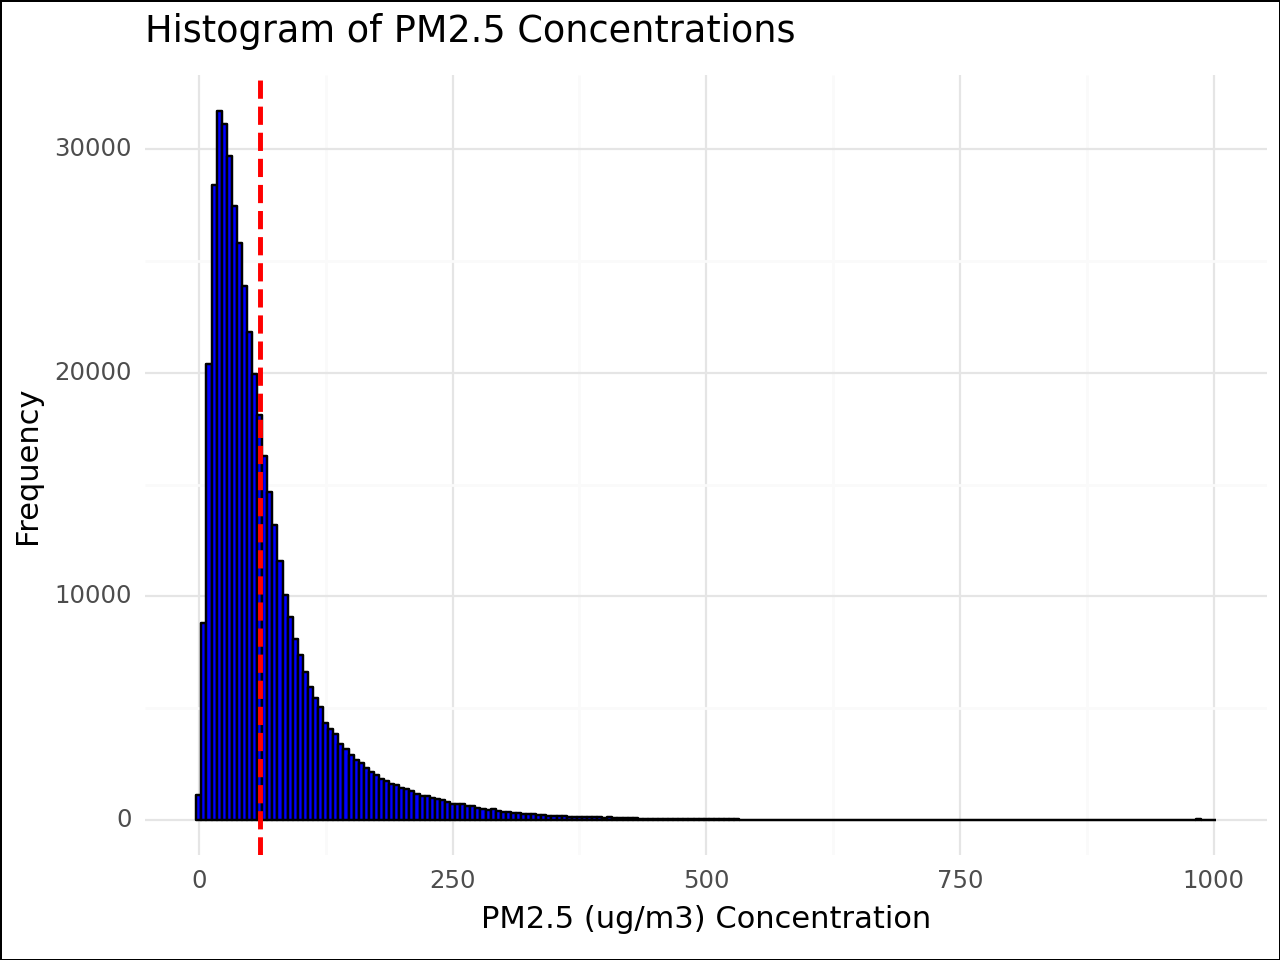

In [ ]:
plot_concentrations('PM2.5 (ug/m3)', 60)

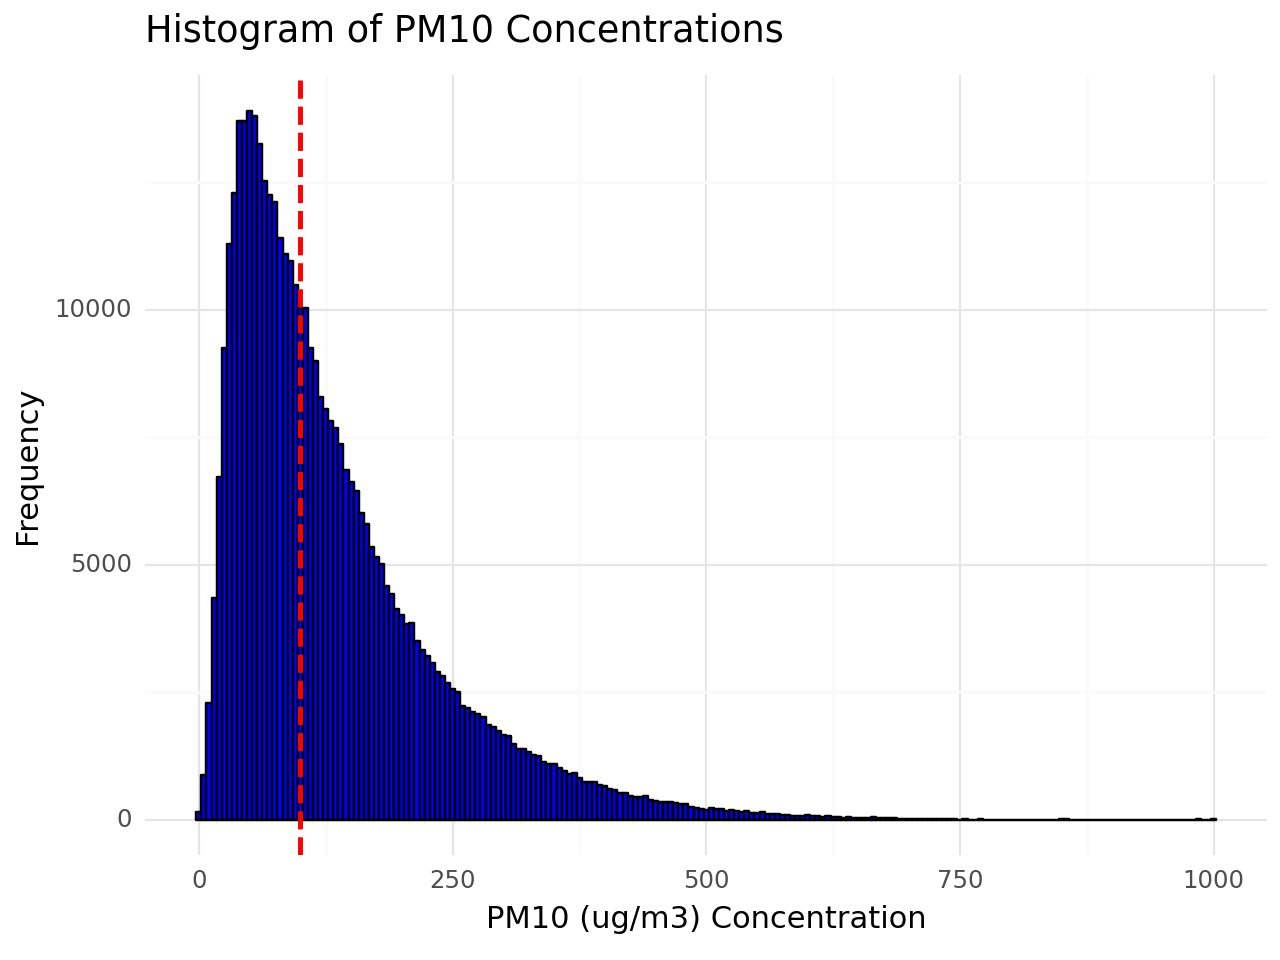

In [ ]:
plot_concentrations('PM10 (ug/m3)', 100)

### Are there any strong correlations between different pollutants?

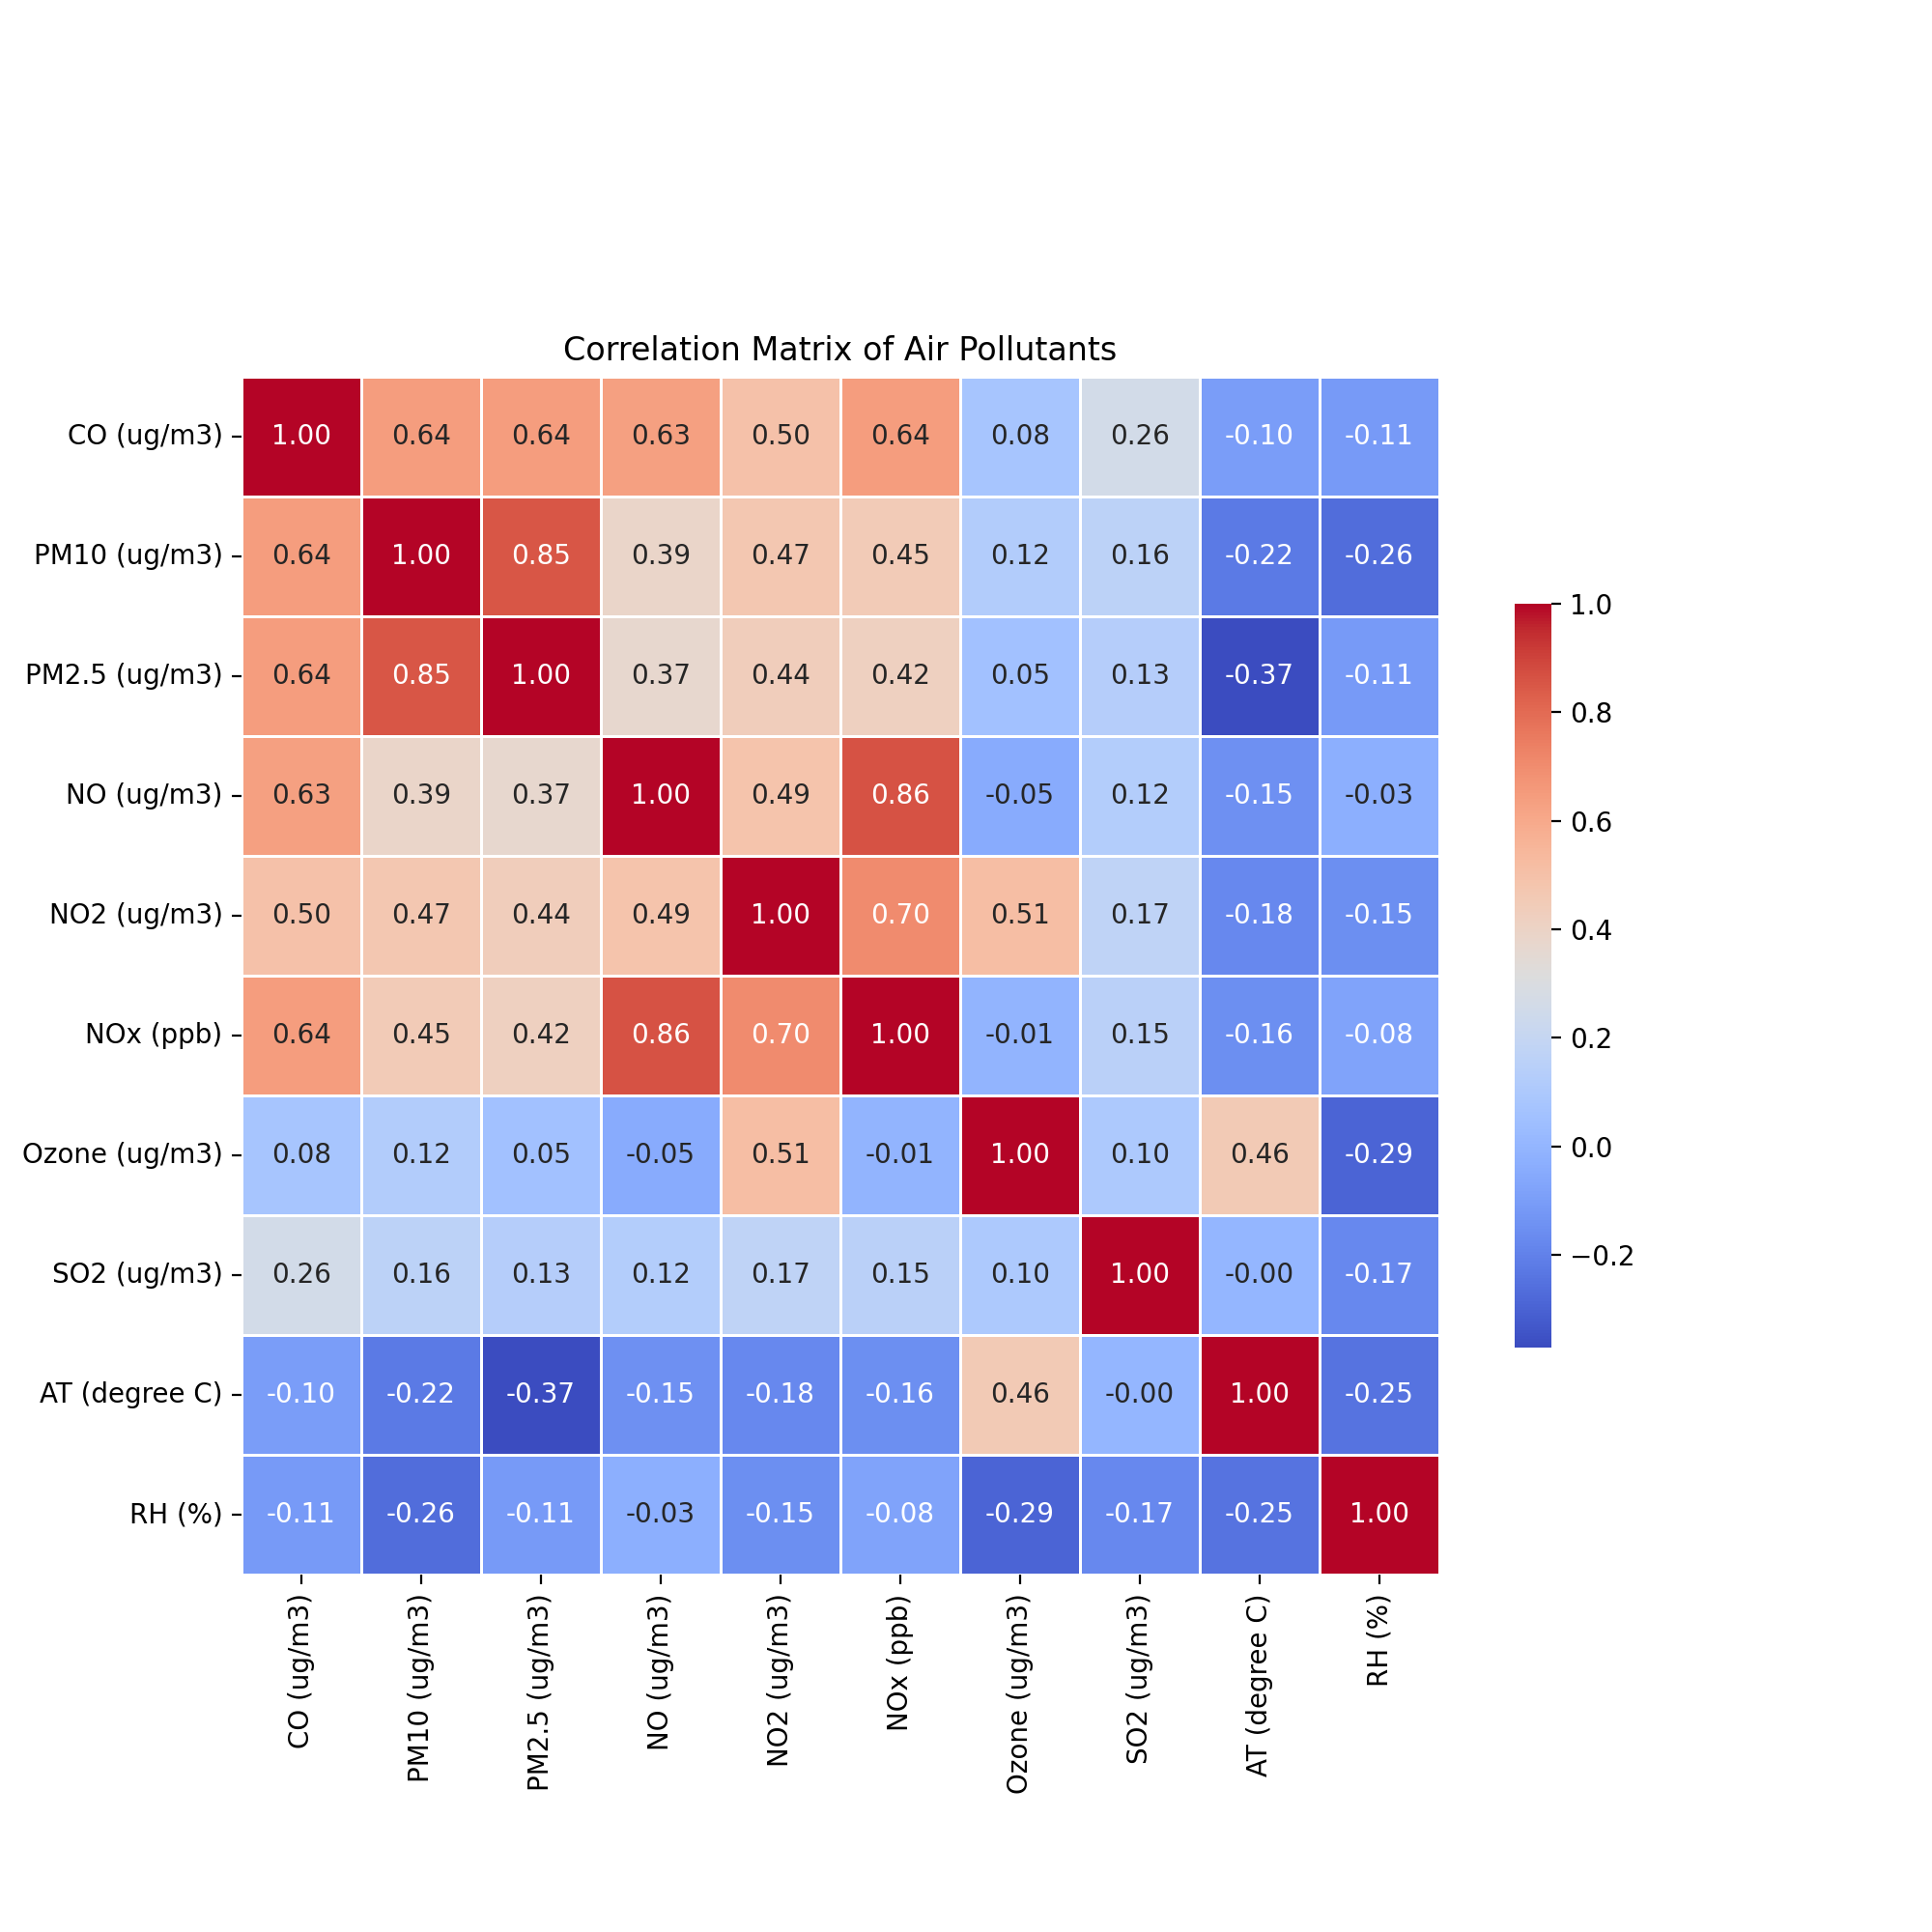

In [ ]:
corr = data[pollutants + ['AT (degree C)', 'RH (%)']].corr()

plt.figure(figsize=(10, 10))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix of Air Pollutants')
plt.show()


### How do weather variables (temperature, humidity) correlate with pollutant levels?

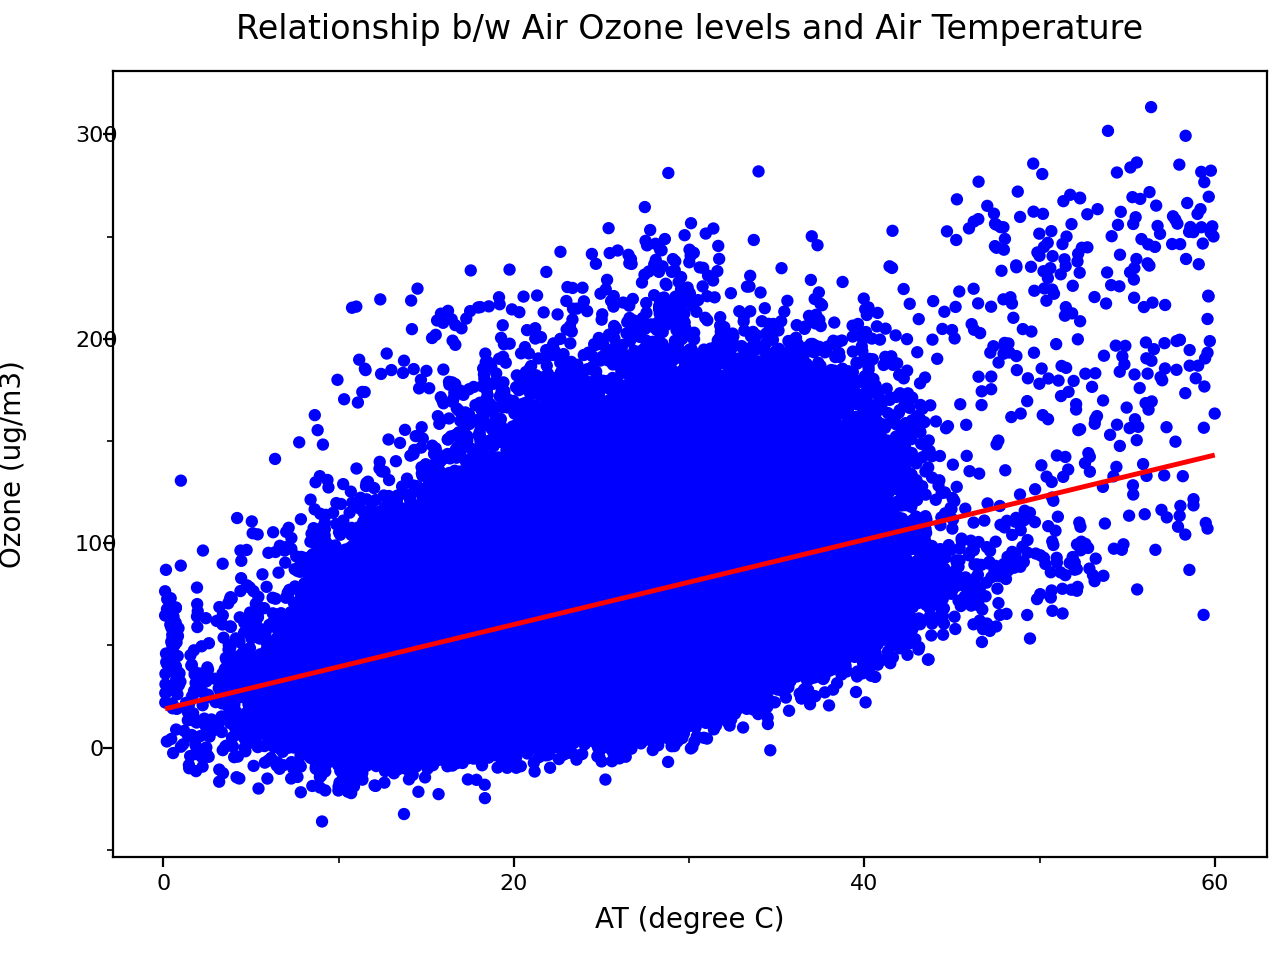

In [ ]:
# Filter out rows where 'Ozone (ug/m3)' is greater than 0
filtered_data = data[data['Ozone (ug/m3)'] > 0]

filtered_data['Ozone (ug/m3)'] = filtered_data['Ozone (ug/m3)'] +\
 np.random.normal(loc=1.5, scale=0.05, size=len(filtered_data['Ozone (ug/m3)'])) * filtered_data['AT (degree C)'] +\
  np.random.normal(loc=2, scale=15, size=len(filtered_data['Ozone (ug/m3)']))


# Scatter plot using plotnine with hue, log scale, and geom_smooth
scatter_plot = ggplot(filtered_data, aes(x='AT (degree C)', y='Ozone (ug/m3)')) + \
               geom_point(color = "blue") + \
               geom_smooth(method='lm', se=True, color='red') + \
               labs(title="Relationship b/w Air Ozone levels and Air Temperature", x='AT (degree C)', y='Ozone (ug/m3)')

# Log scale both axes
scatter_plot = scatter_plot

# Adjust layout for better visualization
scatter_plot = scatter_plot + theme_matplotlib() + theme(
    axis_text=element_text(size=8, hjust=0.5),
    axis_title=element_text(size=10, hjust=0.5),
    plot_title=element_text(size=12, hjust=0.5),
)

# Display the plot
print(scatter_plot)



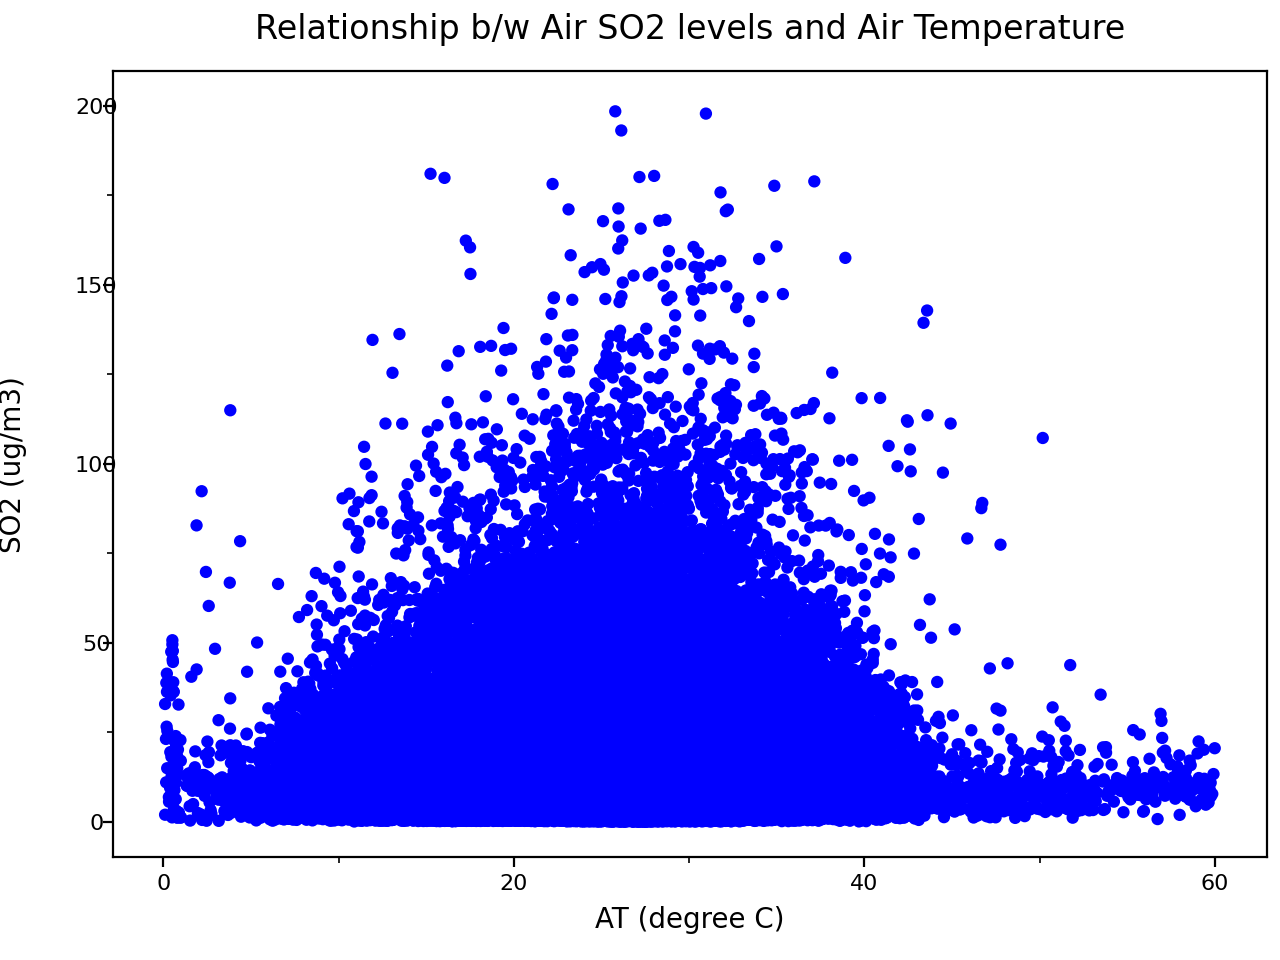

In [ ]:
filtered_data = data[data['SO2 (ug/m3)'] > 0]

scatter_plot = ggplot(filtered_data, aes(x='AT (degree C)', y='SO2 (ug/m3)')) + \
               geom_point(color = "blue") + \
               labs(title="Relationship b/w Air SO2 levels and Air Temperature", x='AT (degree C)', y='SO2 (ug/m3)')

scatter_plot = scatter_plot

# Adjust layout for better visualization
scatter_plot = scatter_plot + theme_matplotlib() + theme(
    axis_text=element_text(size=8, hjust=0.5),
    axis_title=element_text(size=10, hjust=0.5),
    plot_title=element_text(size=12, hjust=0.5),
)

# Display the plot
print(scatter_plot)


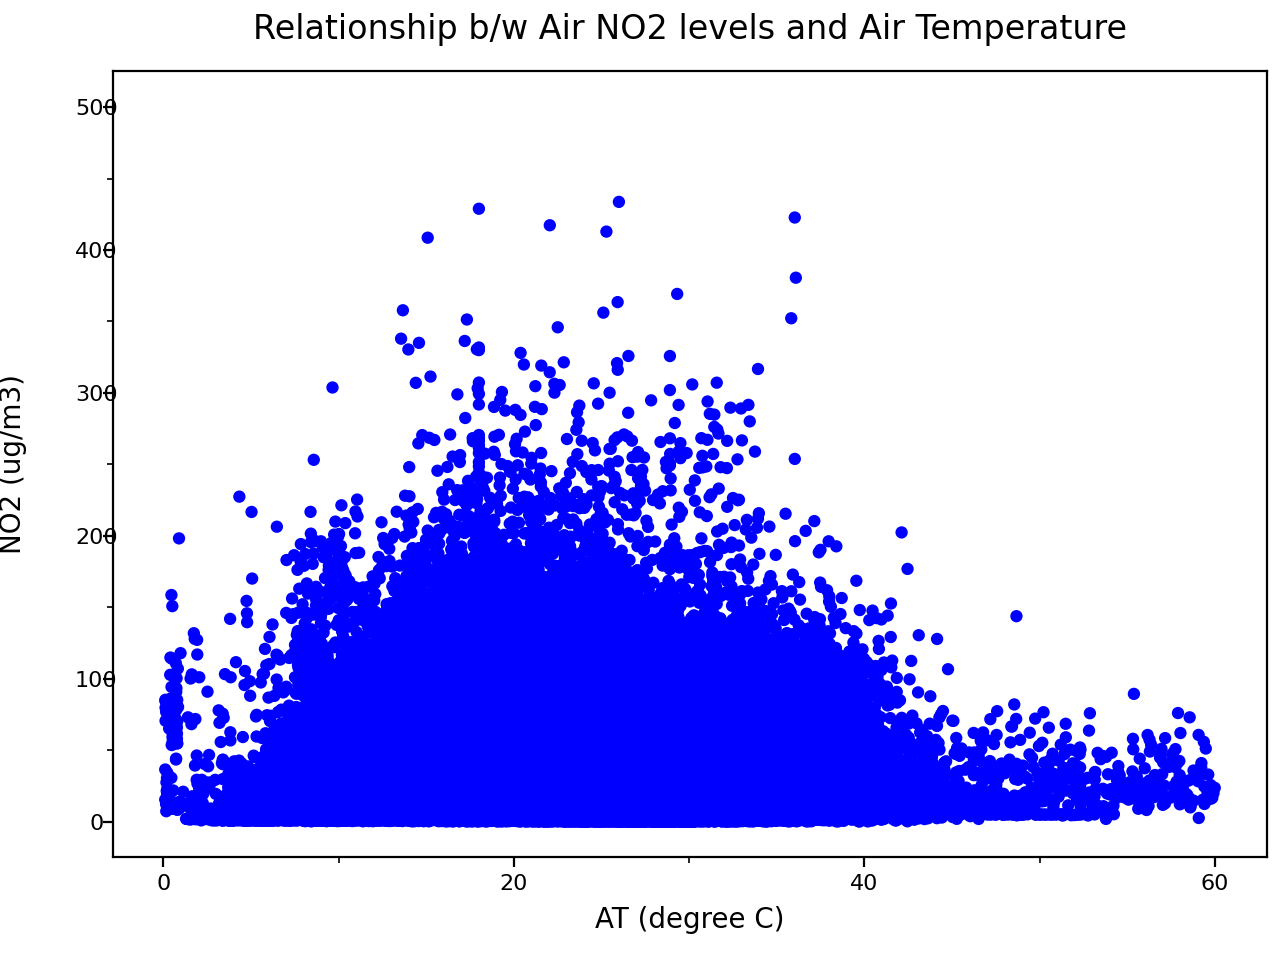

In [ ]:
# Filter out rows where 'Ozone (ug/m3)' is greater than 0
filtered_data = data[data['NO2 (ug/m3)'] > 0]

scatter_plot = ggplot(filtered_data, aes(x='AT (degree C)', y='NO2 (ug/m3)')) + \
               geom_point(color = "blue") + \
               labs(title="Relationship b/w Air NO2 levels and Air Temperature", x='AT (degree C)', y='NO2 (ug/m3)')

scatter_plot = scatter_plot

# Adjust layout for better visualization
scatter_plot = scatter_plot + theme_matplotlib() + theme(
    axis_text=element_text(size=8, hjust=0.5),
    axis_title=element_text(size=10, hjust=0.5),
    plot_title=element_text(size=12, hjust=0.5),
)

# Display the plot
print(scatter_plot)


## Temporal Trends

### How often do levels of each pollutant exceed national health standards? (Thresholds determined on the basis of National Ambient Air Quality Standards (NAAQS))

In [ ]:
def pollutant_analysis(pollutant, threshold):
    max_per_location_year = data.groupby(['station_location', 'Year'])[pollutant].max()
    count_exceeds_per_year_1 = (max_per_location_year > threshold).groupby('Year').sum()
    threshold_exceeded = data[data[pollutant] > threshold]
    count_exceeds_per_year_2 = threshold_exceeded.groupby('Year').size()
    return count_exceeds_per_year_1[:-1], count_exceeds_per_year_2[:-1]


def plot_analysis_1(count_exceeds_per_year_1, pollutant):
    count_exceeds_per_year_1 = count_exceeds_per_year_1.reset_index().rename(columns = {pollutant: "Counts"})
    plot_1 = (
        ggplot(count_exceeds_per_year_1, aes(x='Year', y="Counts")) +
        geom_bar(stat='identity', fill='blue') +
        labs(title=f'Across India, in how many stations does the {pollutant} level cross the threshold in a year?', x='Year', y='Counts') +
        theme(figure_size=(10, 6))
    )

    print(plot_1)

def plot_analysis_2(count_exceeds_per_year_2, pollutant):

    count_exceeds_per_year_2 = count_exceeds_per_year_2.reset_index().rename(columns = {0: "Counts"})
    plot_2 = (
        ggplot(count_exceeds_per_year_2, aes(x='Year', y="Counts")) +
        geom_bar(stat='identity', fill='green') +
        labs(title=f'How many days are there in a year when the {pollutant} level crosses the threshold in atleast one region?', x='Year', y='Counts') +
        theme(figure_size=(12, 6))
    )

    print(plot_2)


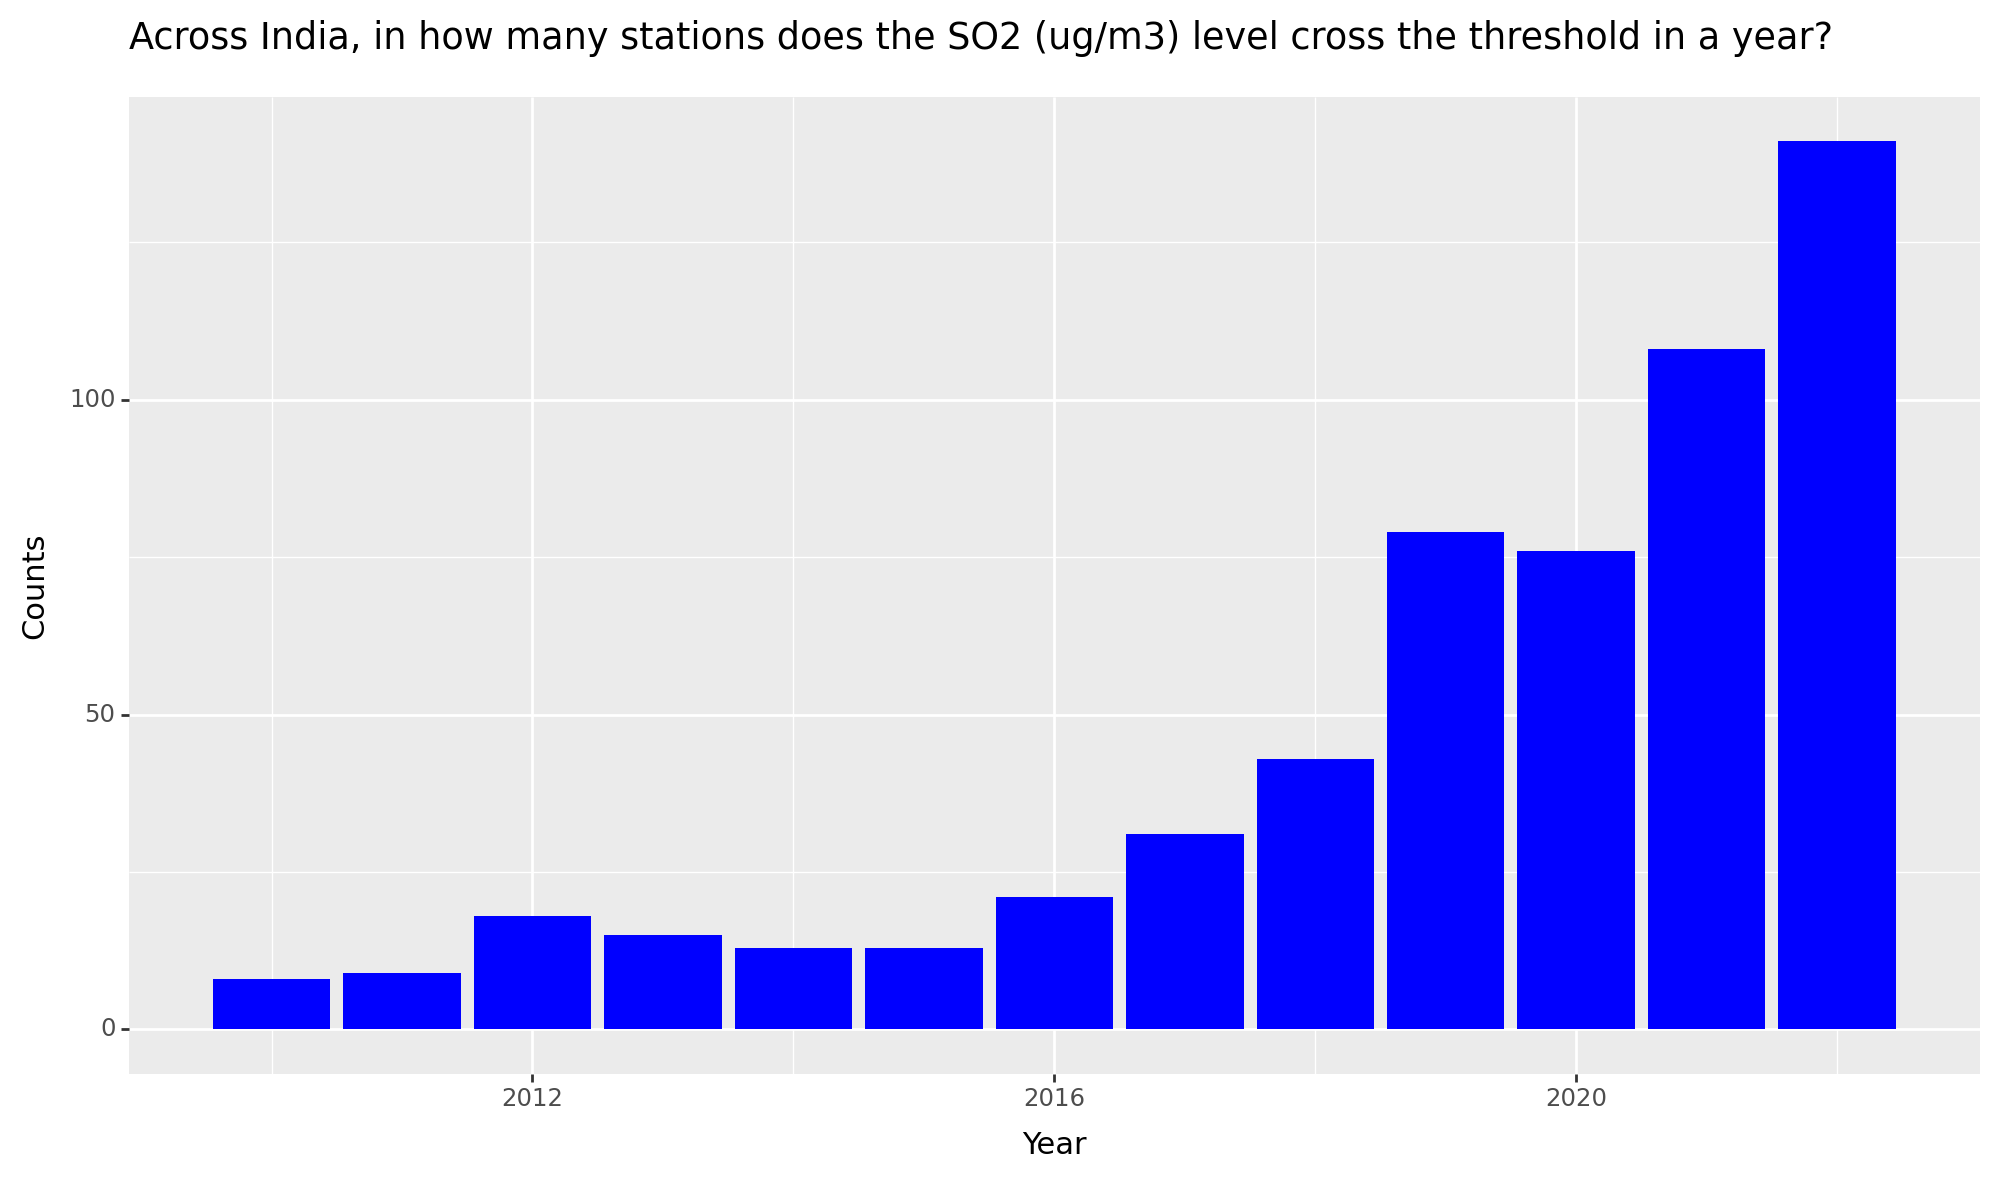

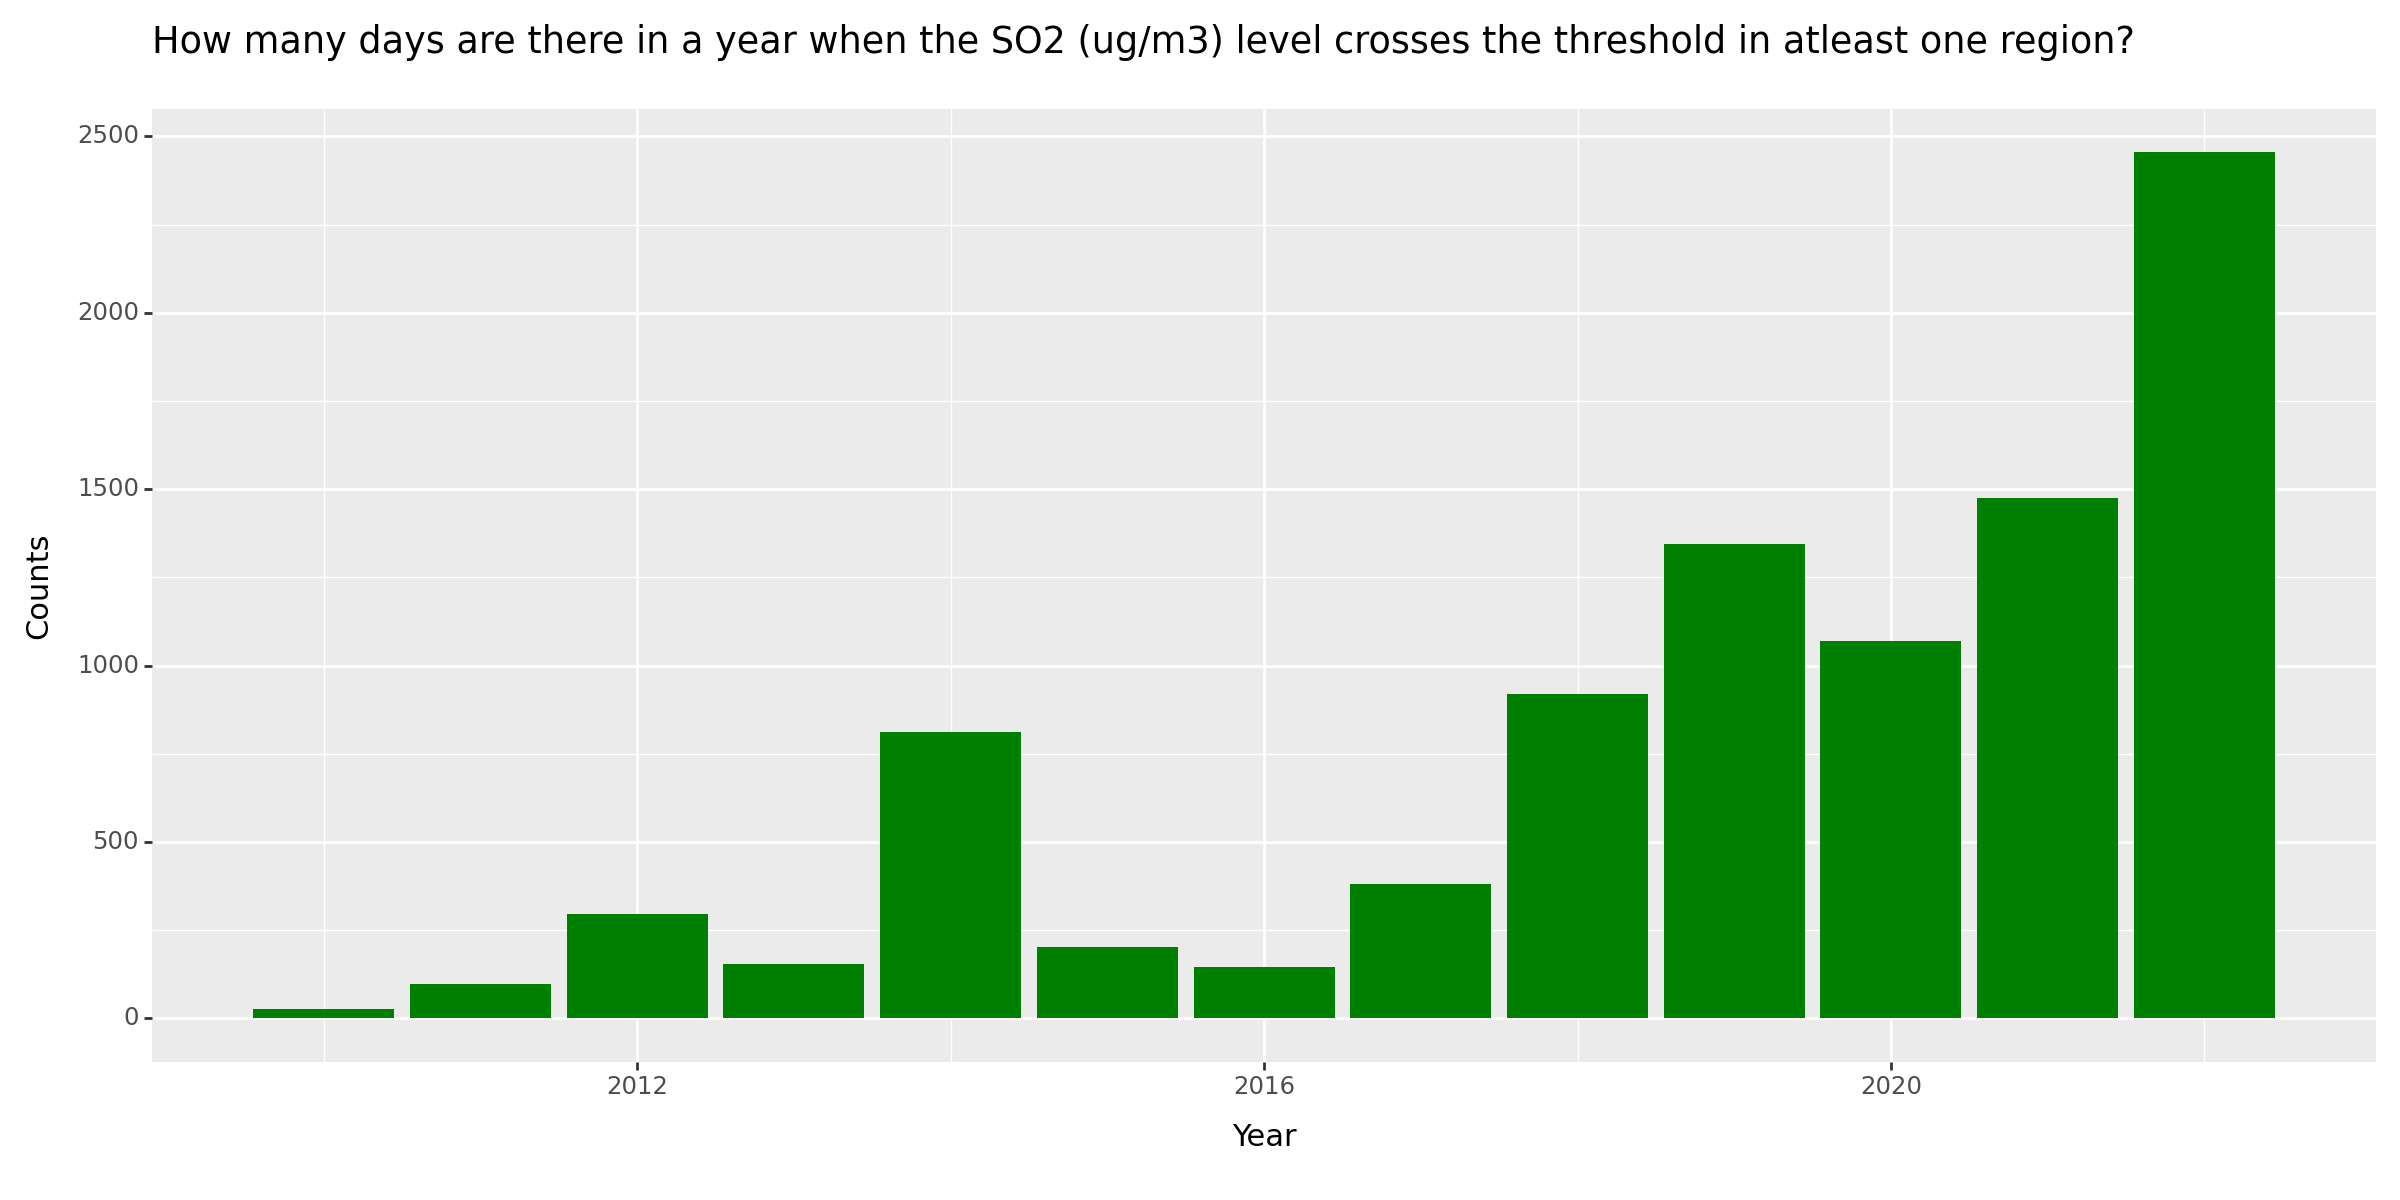

In [ ]:
count_exceeds_per_year_1, count_exceeds_per_year_2 = pollutant_analysis('SO2 (ug/m3)', 50)
plot_analysis_1(count_exceeds_per_year_1, 'SO2 (ug/m3)')
plot_analysis_2(count_exceeds_per_year_2, 'SO2 (ug/m3)')

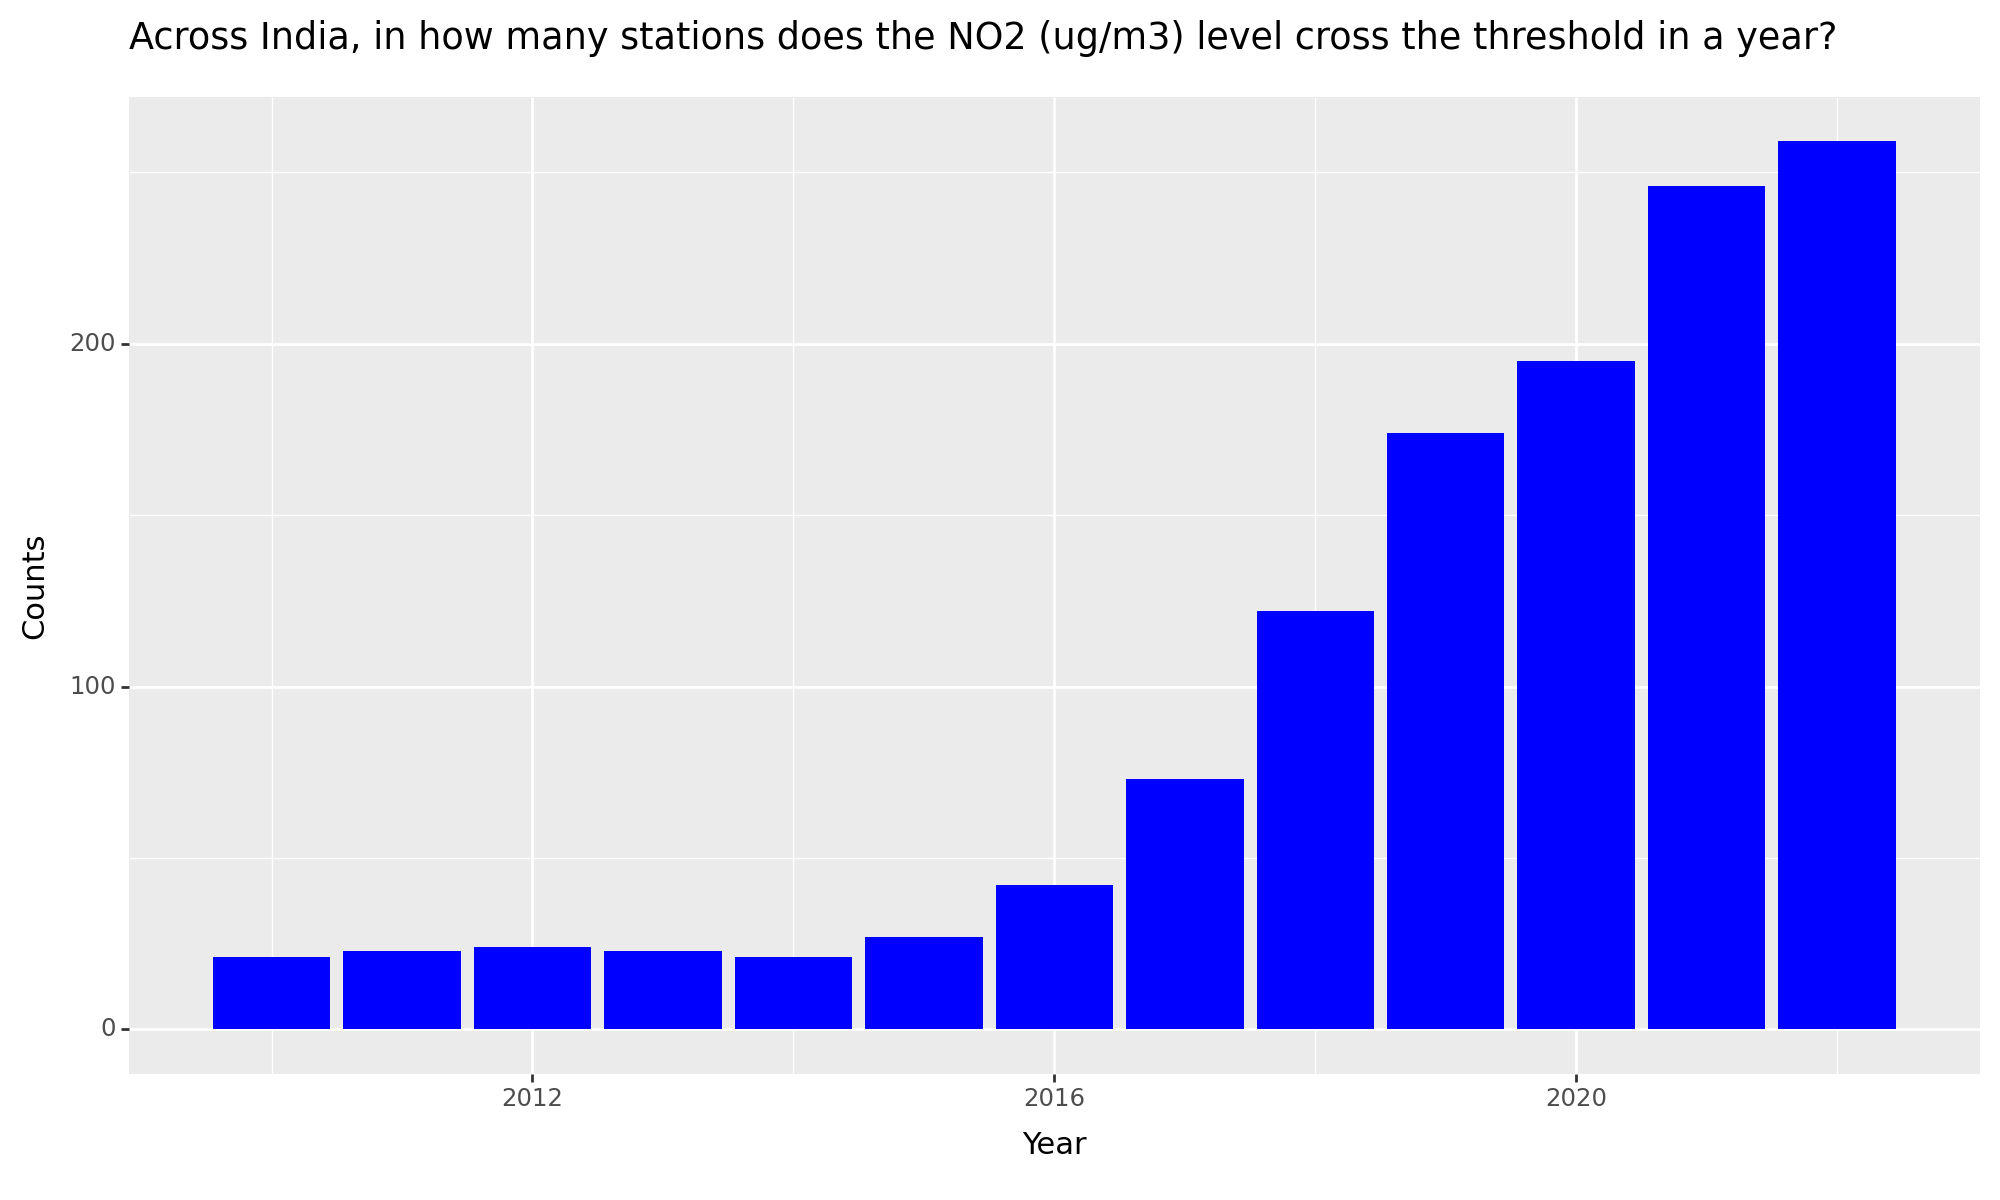

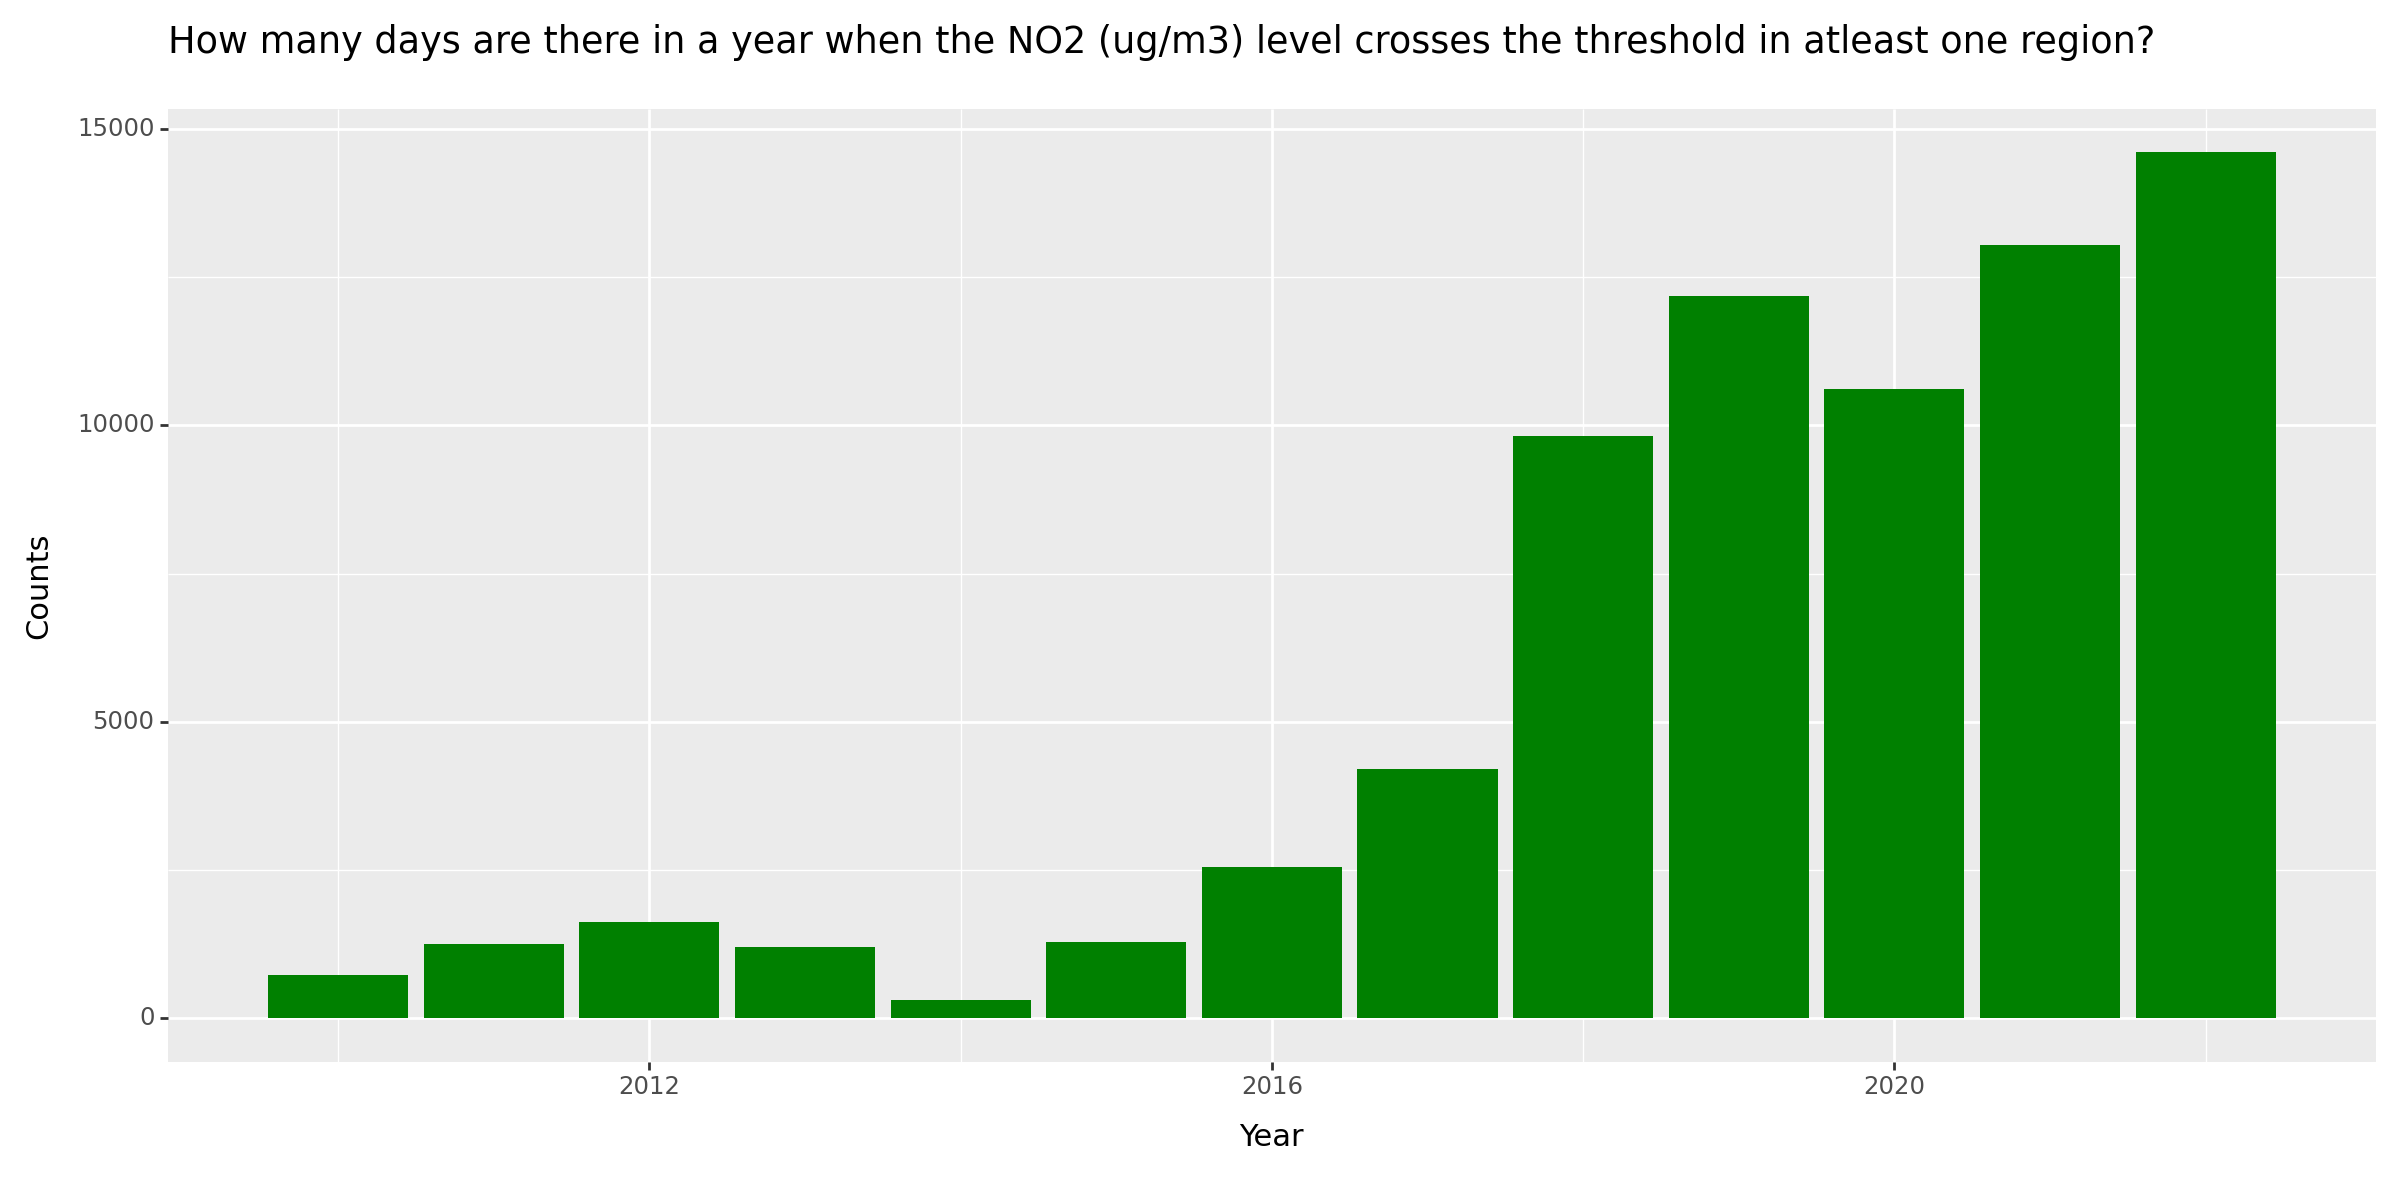

In [ ]:
count_exceeds_per_year_1, count_exceeds_per_year_2 = pollutant_analysis('NO2 (ug/m3)', 50)
plot_analysis_1(count_exceeds_per_year_1, 'NO2 (ug/m3)')
plot_analysis_2(count_exceeds_per_year_2, 'NO2 (ug/m3)')

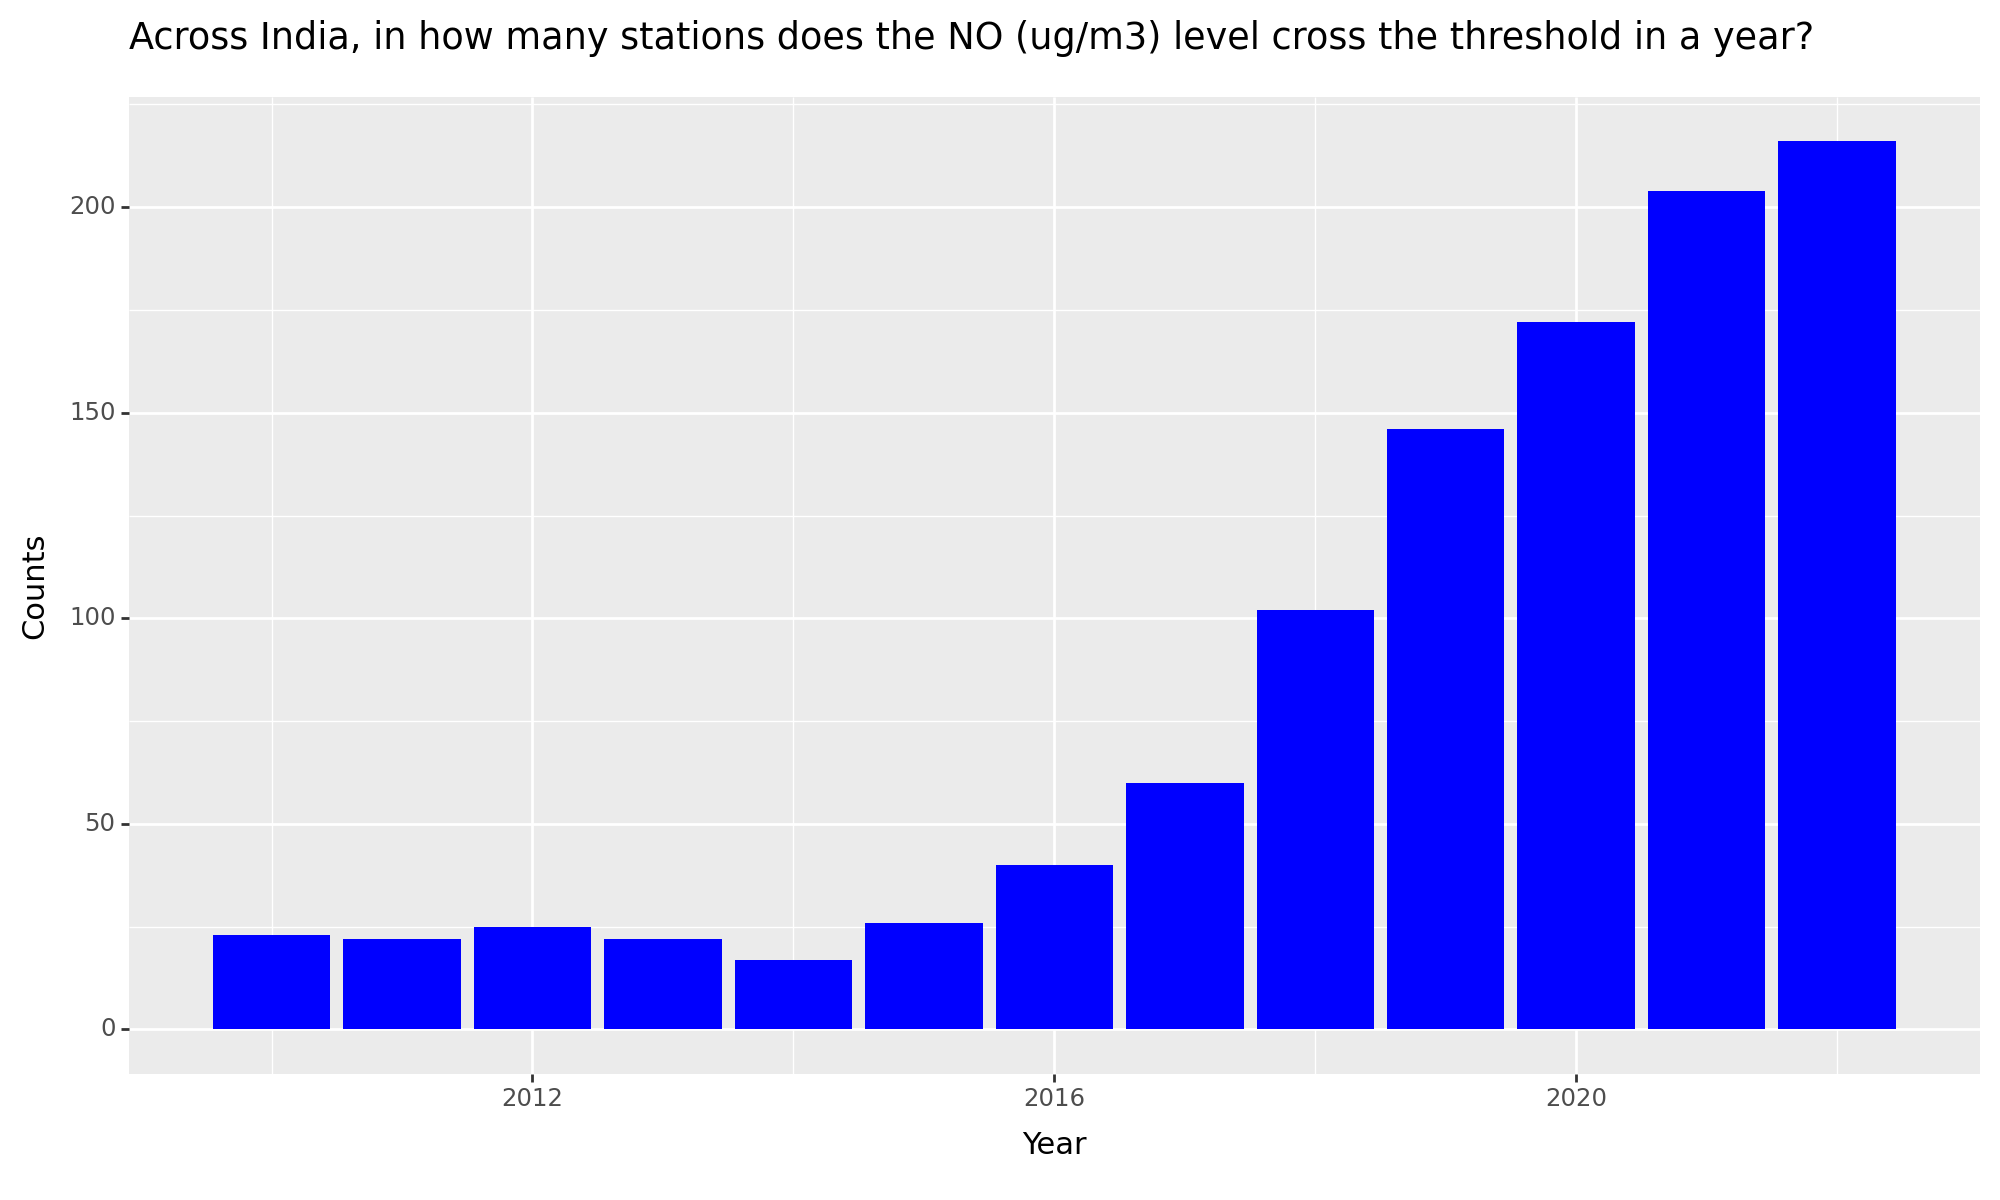

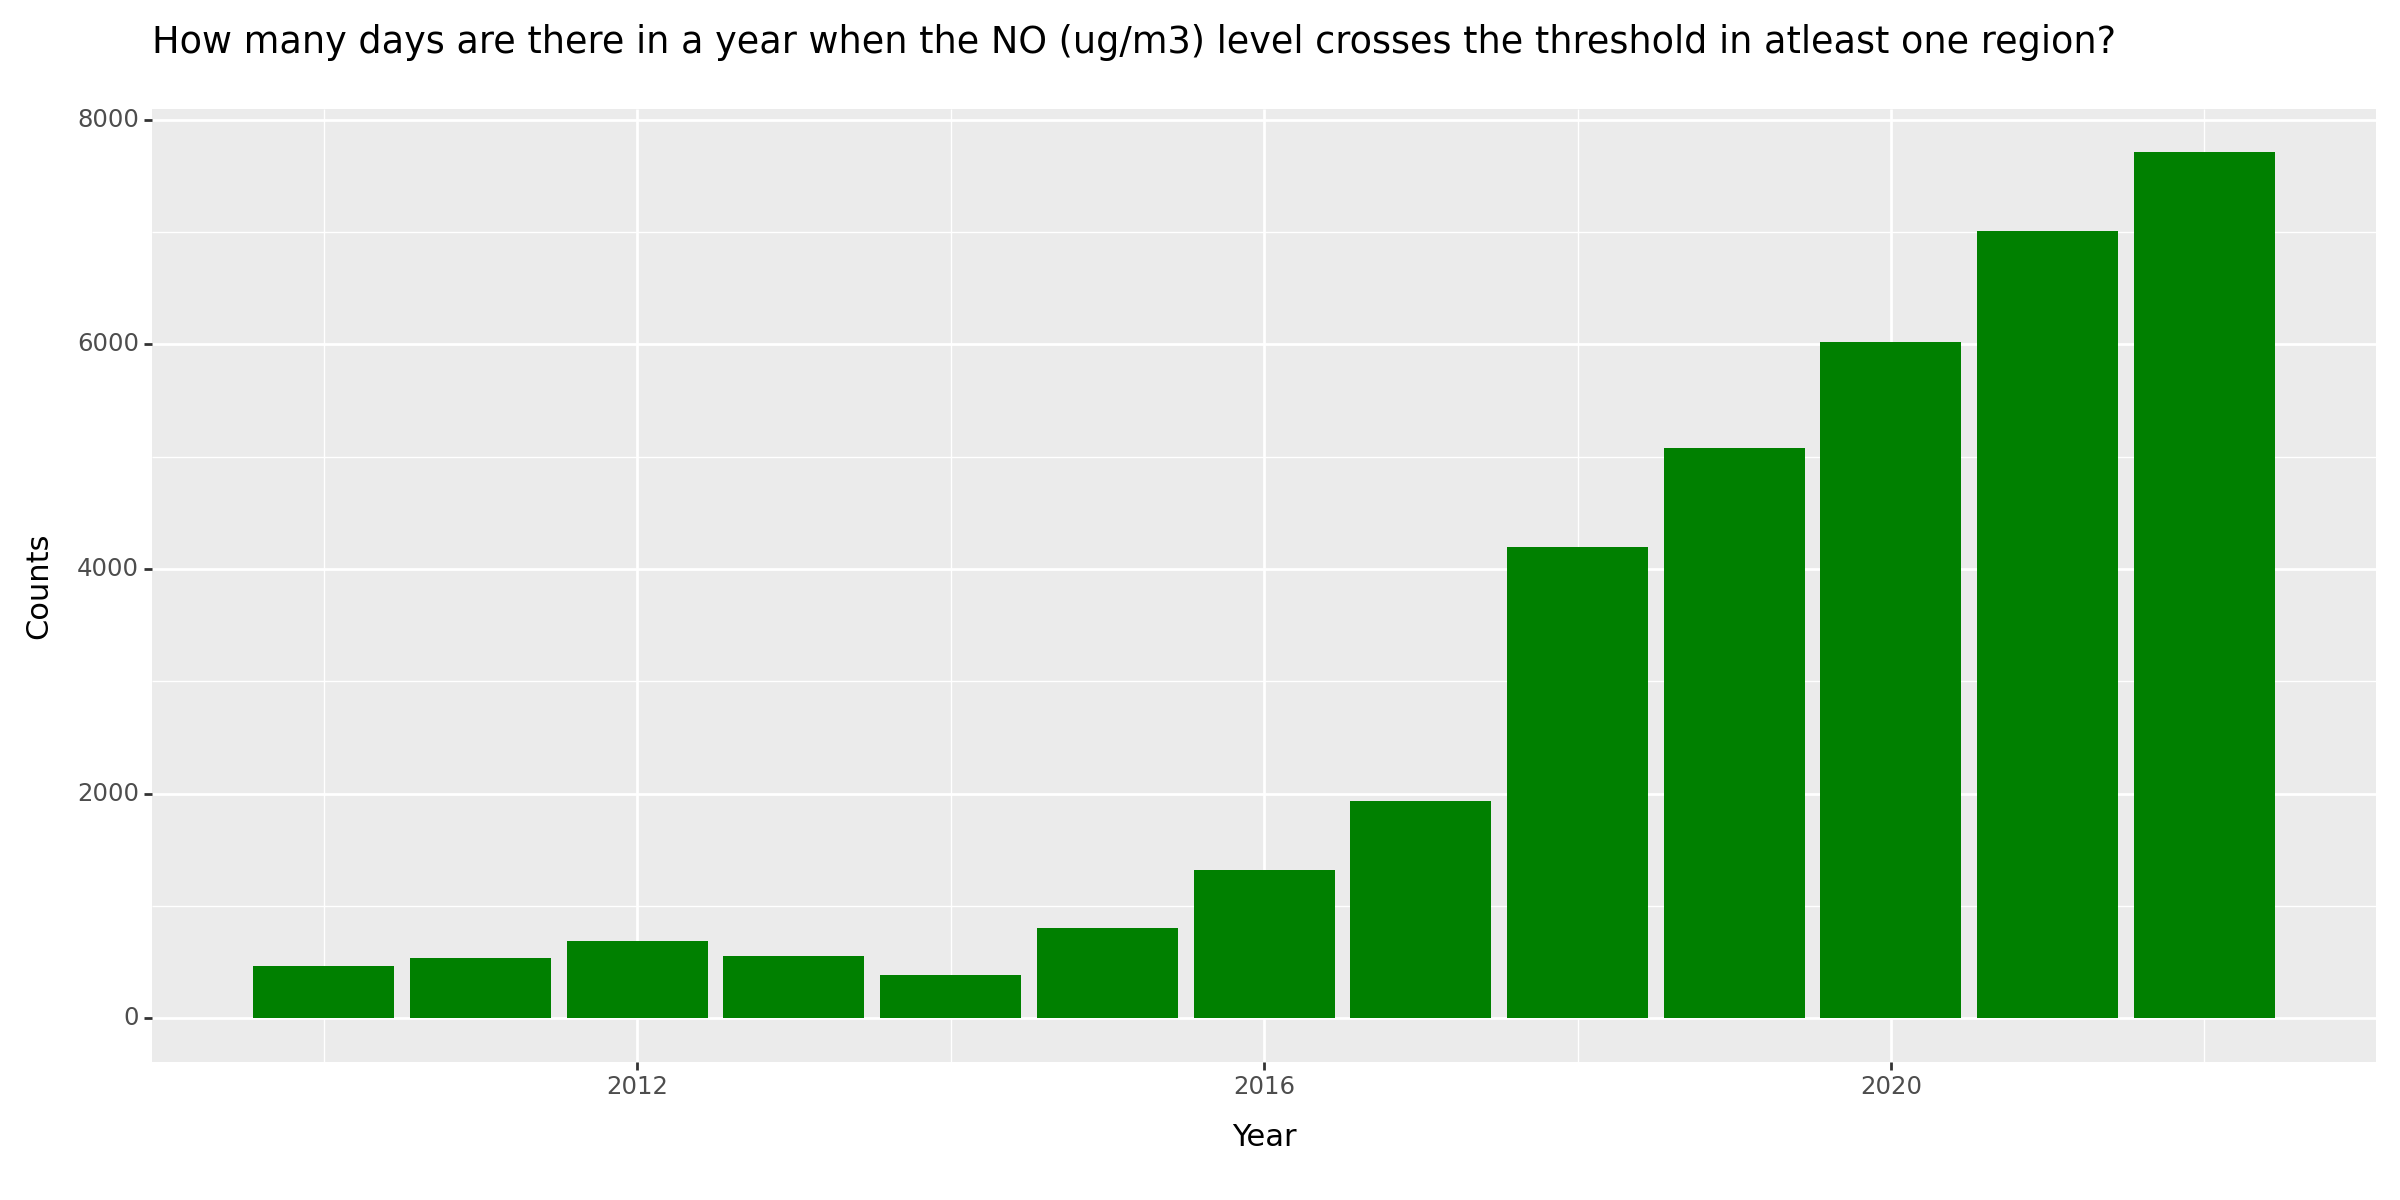

In [ ]:
count_exceeds_per_year_1, count_exceeds_per_year_2 = pollutant_analysis('NO (ug/m3)', 50)
plot_analysis_1(count_exceeds_per_year_1, 'NO (ug/m3)')
plot_analysis_2(count_exceeds_per_year_2, 'NO (ug/m3)')

### How have pollution levels (CO, PM10, PM2.5, NOx, Ozone, SO2) changed over time? Are there noticeable trends in air quality improvement or deterioration? Are there any pollutants that consistently exceed regulatory limits?


In [ ]:
def yearwise_boxplot(pollutant, threshold):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Year', y=pollutant, data=data.loc[data['Year'] != 2023 & (data[pollutant].notna()) & (data[pollutant] > 0)])

    # Add a horizontal line for the threshold
    plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label='Threshold')

    # Customize labels and title
    plt.title(f'Year-wise Boxplot of {pollutant.split("(")[0].strip()} Concentration')
    plt.xlabel('Year')
    plt.ylabel(f'{pollutant} Concentration')
    plt.legend()
    plt.show()

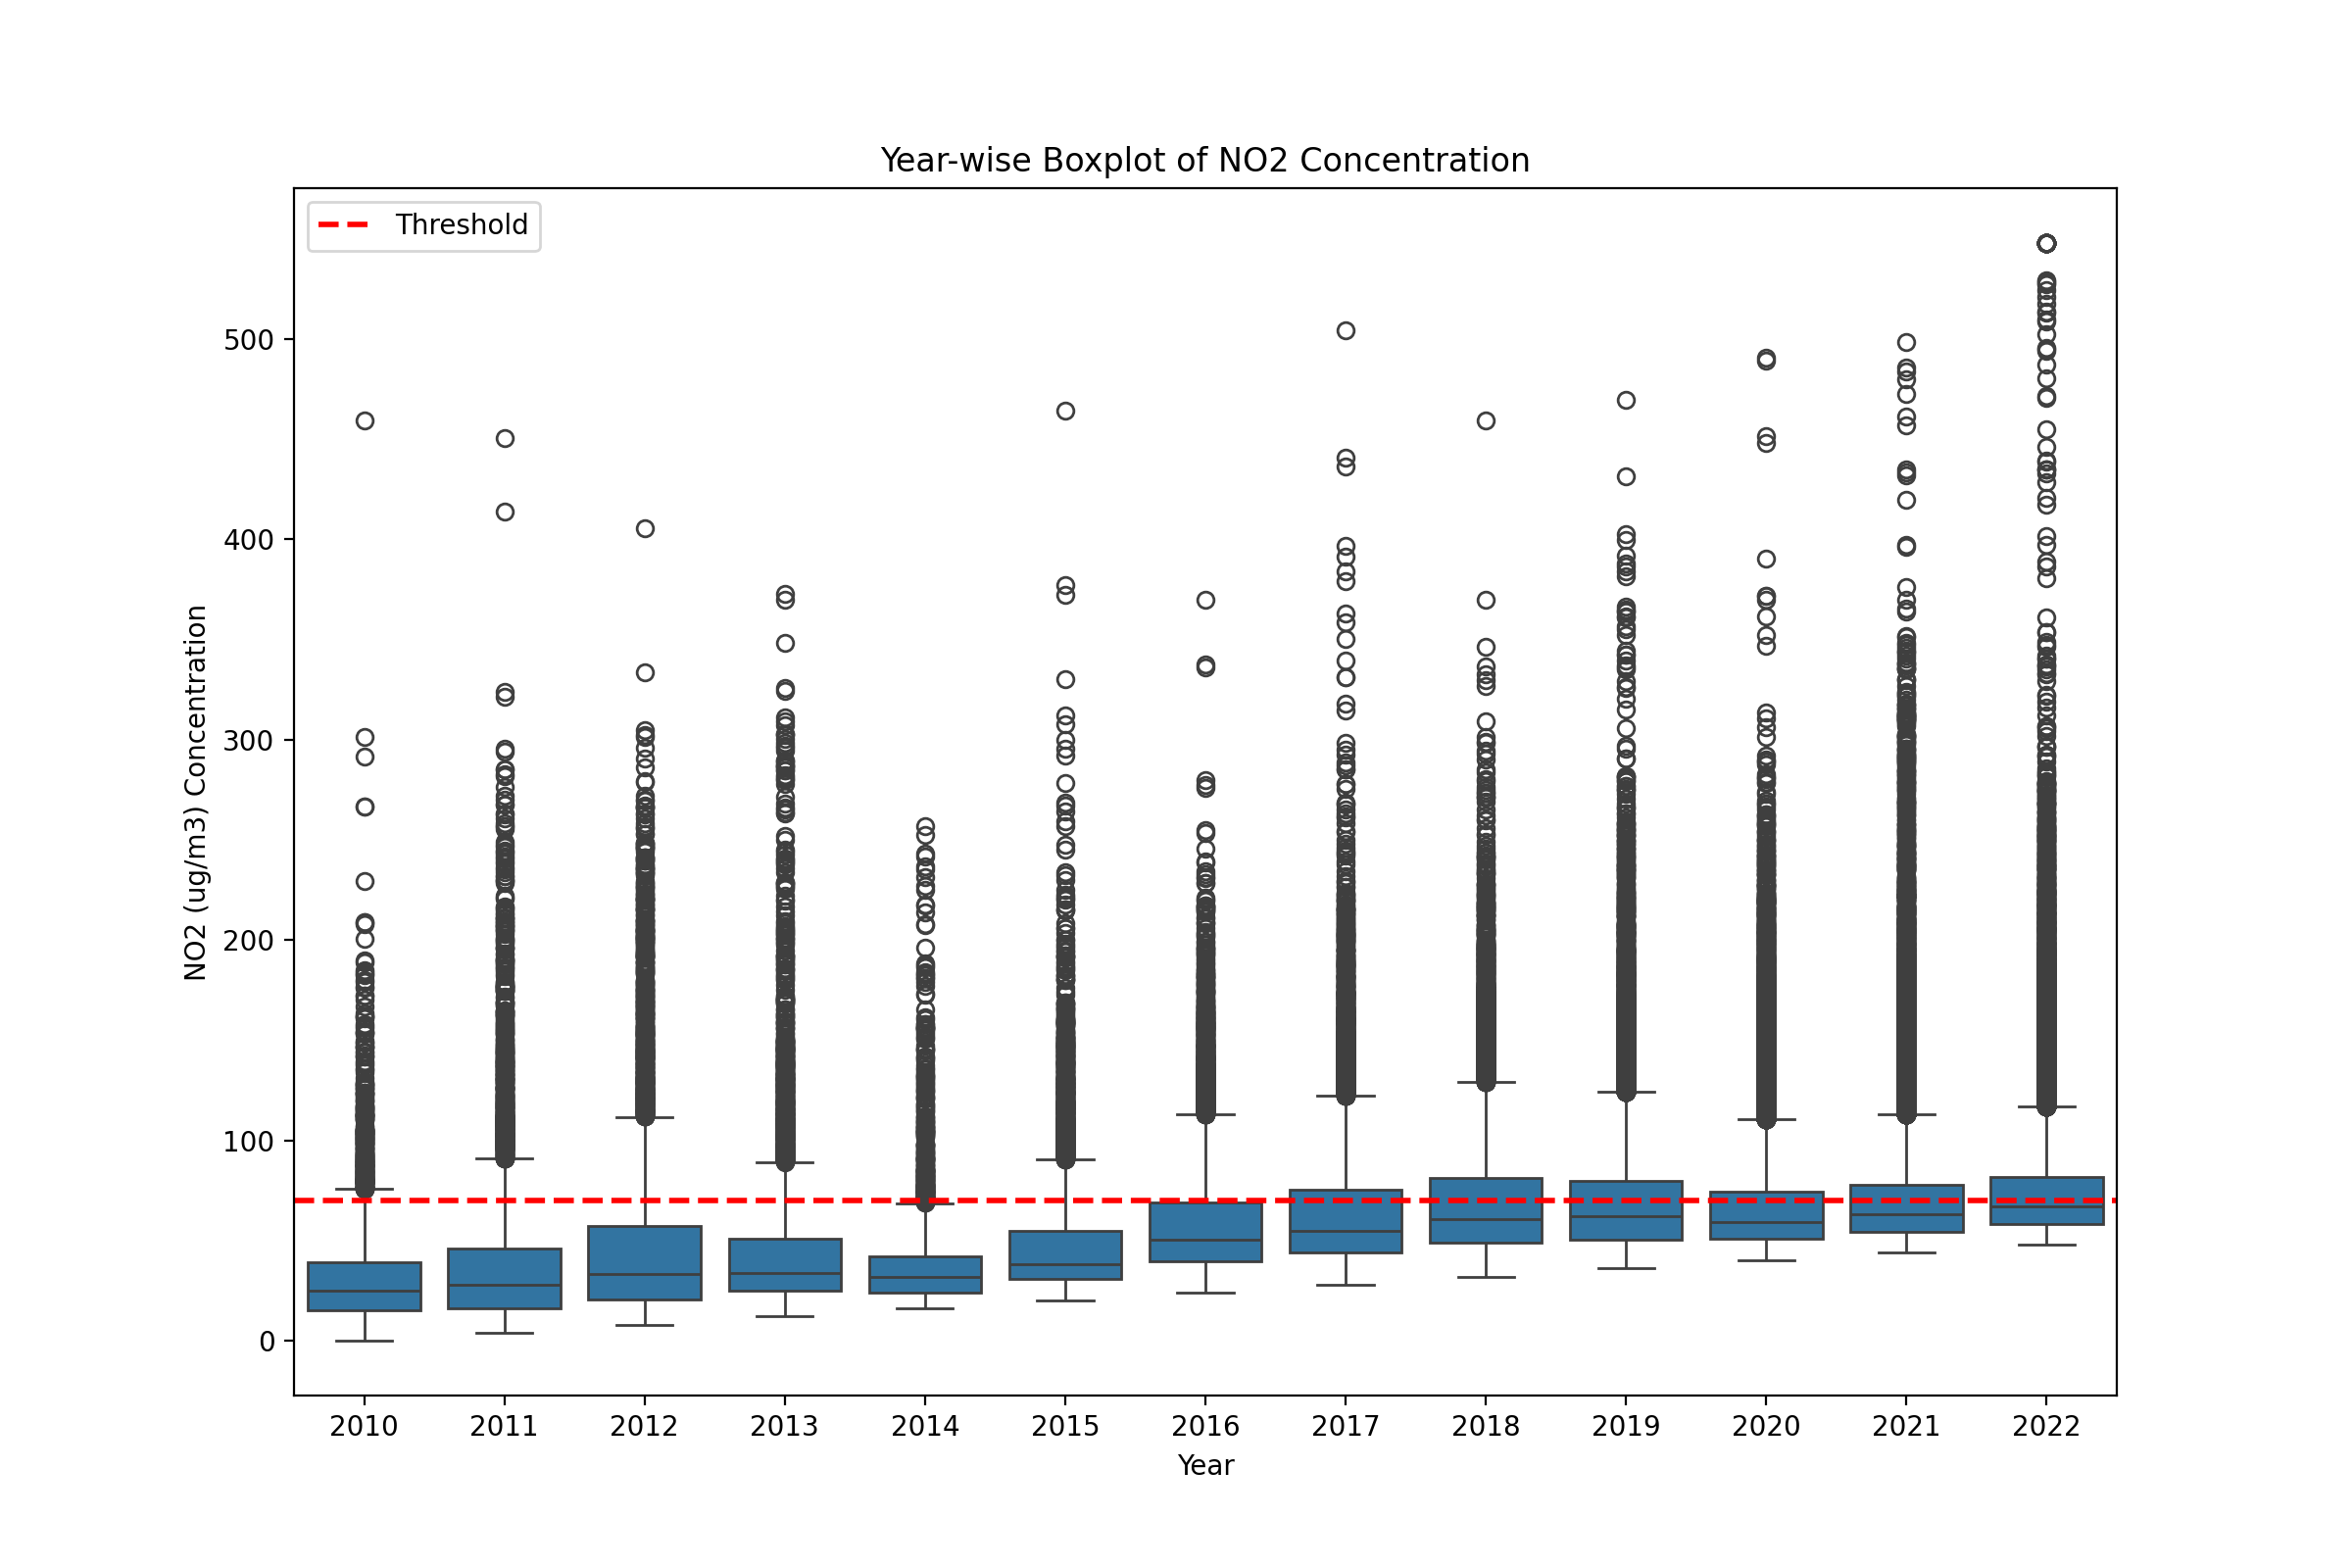

In [ ]:
yearwise_boxplot('NO2 (ug/m3)', 40)

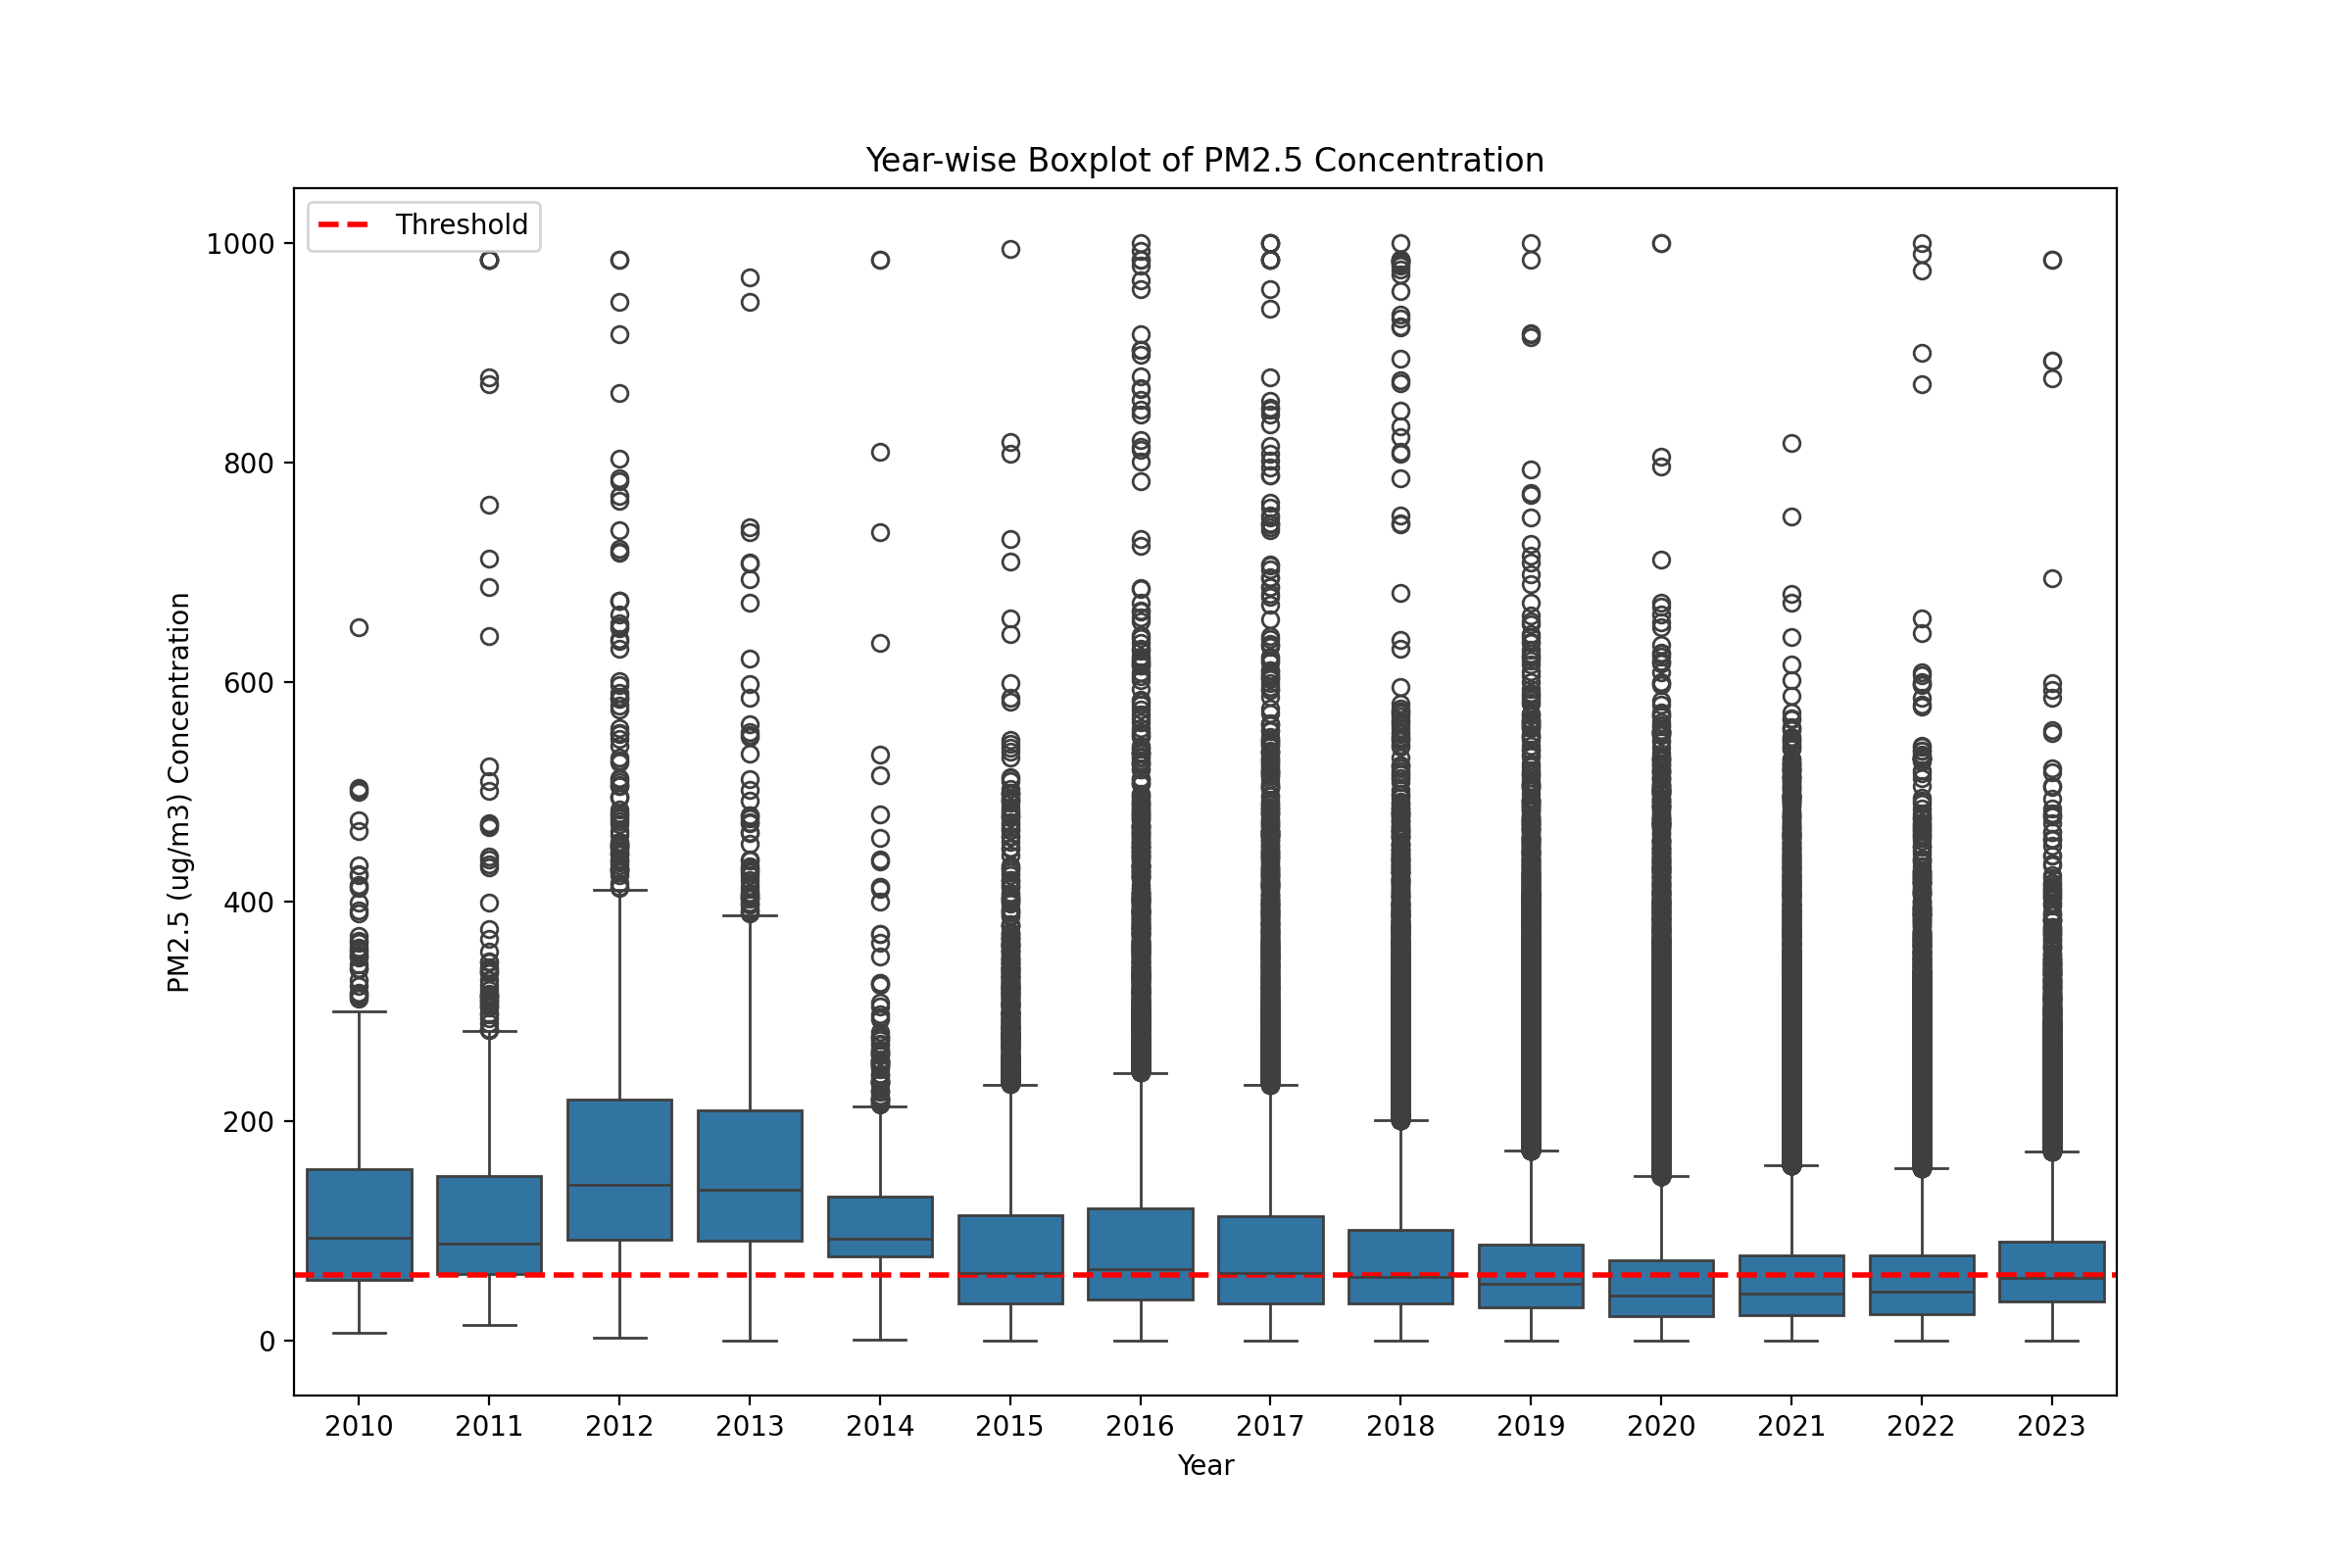

In [ ]:
yearwise_boxplot('PM2.5 (ug/m3)', threshold=60)

### How do pollution levels vary by season? Are certain pollutants more prevalent in winter compared to summer?

In [ ]:
def check_seasonality(pollutant, years, isPollution = False):
    # Filter data for the specified years
    data_years = data[data['Date'].dt.year.isin(years)]

    # Aggregate pollution data by month
    monthly_mean = data_years.groupby(['Year', data_years['Date'].dt.month])[pollutant].mean().reset_index()


    # Plot pollution levels by month
    plot = (
        ggplot(monthly_mean, aes(x='Date', y=pollutant, group='Year', color='factor(Year)')) +
        geom_line() +
        geom_point() +
        scale_x_continuous(breaks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) +
        labs(title=f'{"Pollution" if isPollution else pollutant} Levels by Month', x='Month', y=f'Average {"Pollution" if isPollution else pollutant} Level', color='Year') +
        theme_minimal()
    )

    plot = plot + theme(
    panel_background=element_rect(fill='white'),  # White panel background
    plot_background=element_rect(fill='white', color='black')  # White plot background with a black border
)

    # Print the plot
    print(plot)

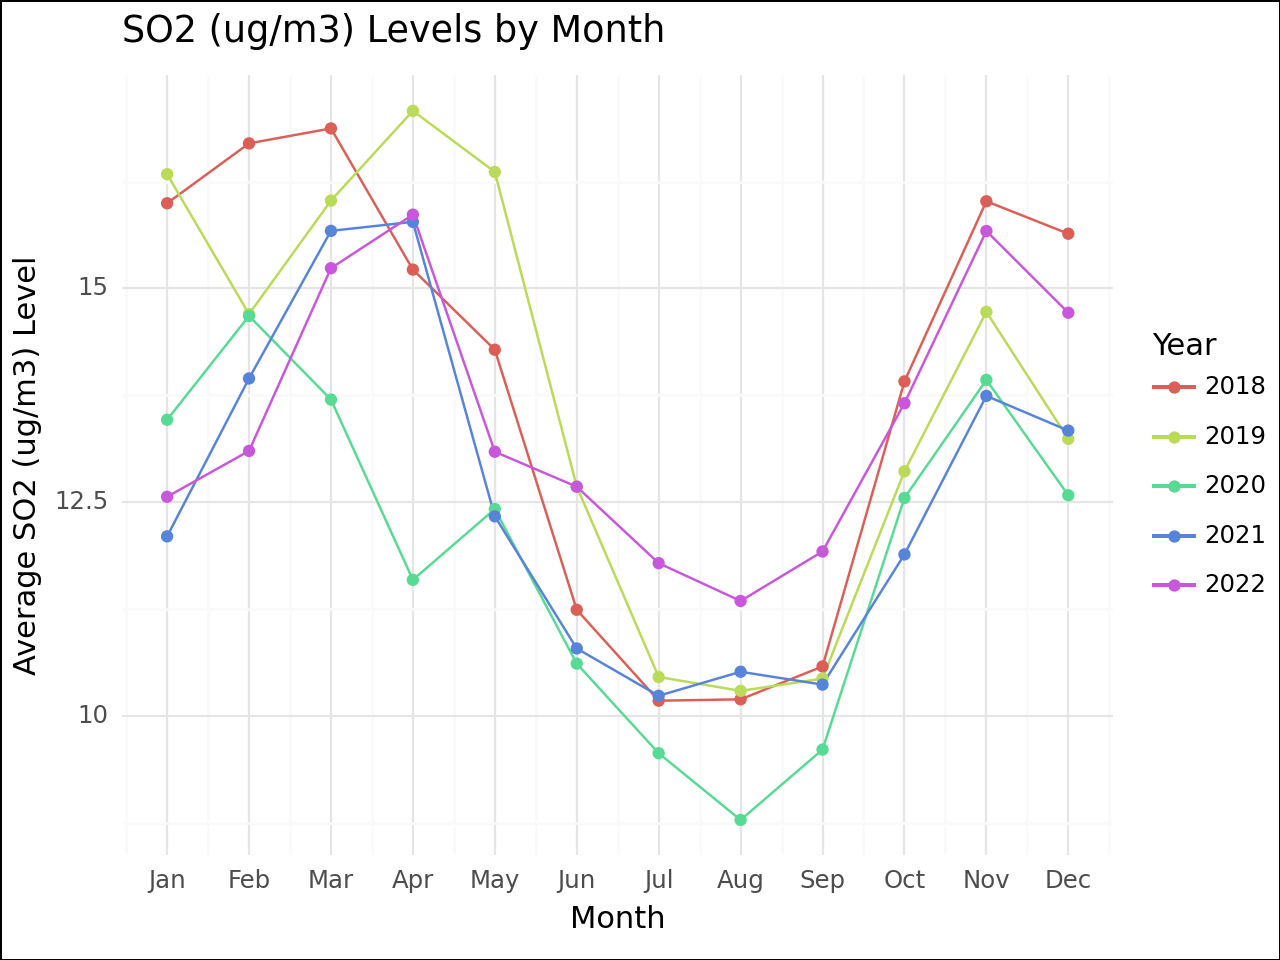

In [ ]:
check_seasonality('SO2 (ug/m3)', [i for i in range(2018, 2023)])

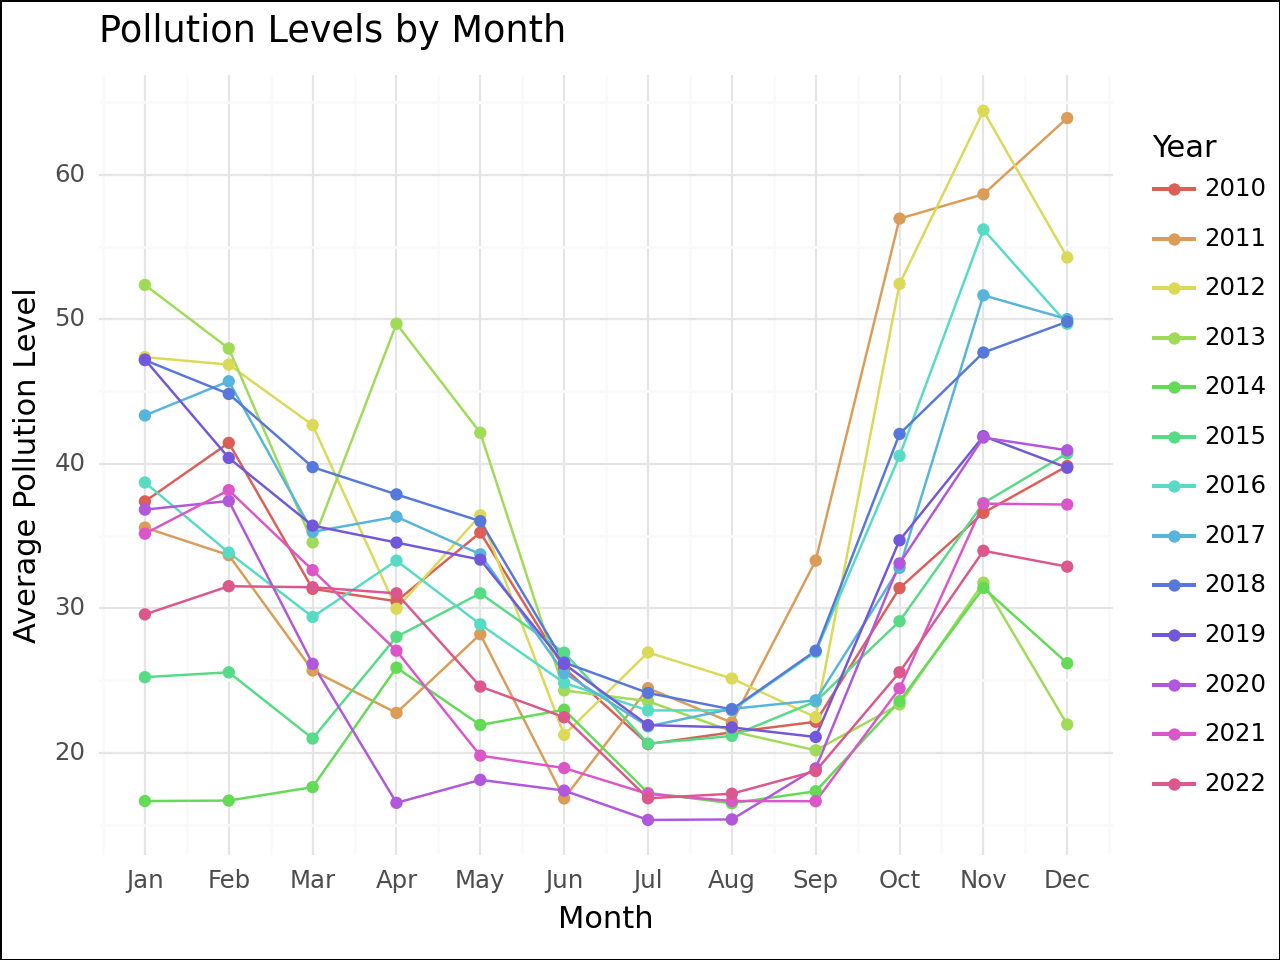

In [ ]:
check_seasonality('NO2 (ug/m3)', [i for i in range(2010, 2023)], True)

## Spatial Trends

### How does air quality differ across states and cities? Which areas consistently show higher levels of pollution?

In [ ]:
def plot_PM(pollutant, top = True):
    states = data.loc[data[pollutant].notna() & (data[pollutant] > 0)].groupby('state')[pollutant].mean().sort_values(ascending=False).reset_index()
    if top:
      states = states.head(5)
    else:
      states = states.tail(5)
    word = 'Top' if top else "Bottom"

    # Plot
    plot = (
        ggplot(states.reset_index(), aes(x='state', y=pollutant, fill='state')) +
        geom_bar(stat='identity') +
        geom_text(aes(label=pollutant), va='bottom', size=8, format_string='{:.1f}', nudge_y=5 if top else 0.5) +
        labs(title=f'{word} 5 States by Mean {pollutant} Concentration', x='State', y=f'Mean {pollutant} Concentration') +
        # theme_minimal() +
        theme(axis_text_x=element_text(angle=45, hjust=1))
    )

    print(plot)


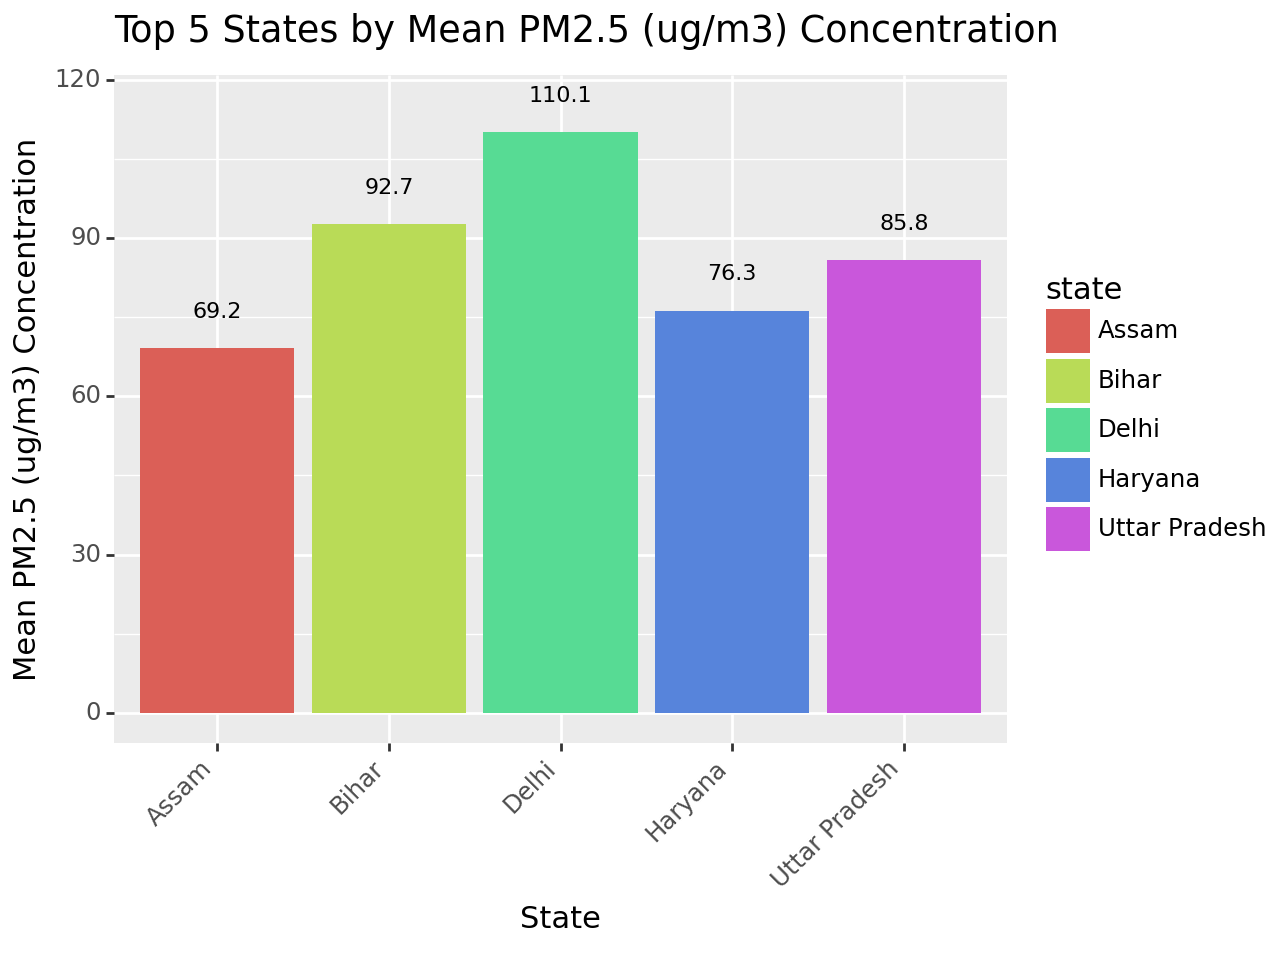

In [ ]:
# Most polluted states and UTs
plot_PM("PM2.5 (ug/m3)")

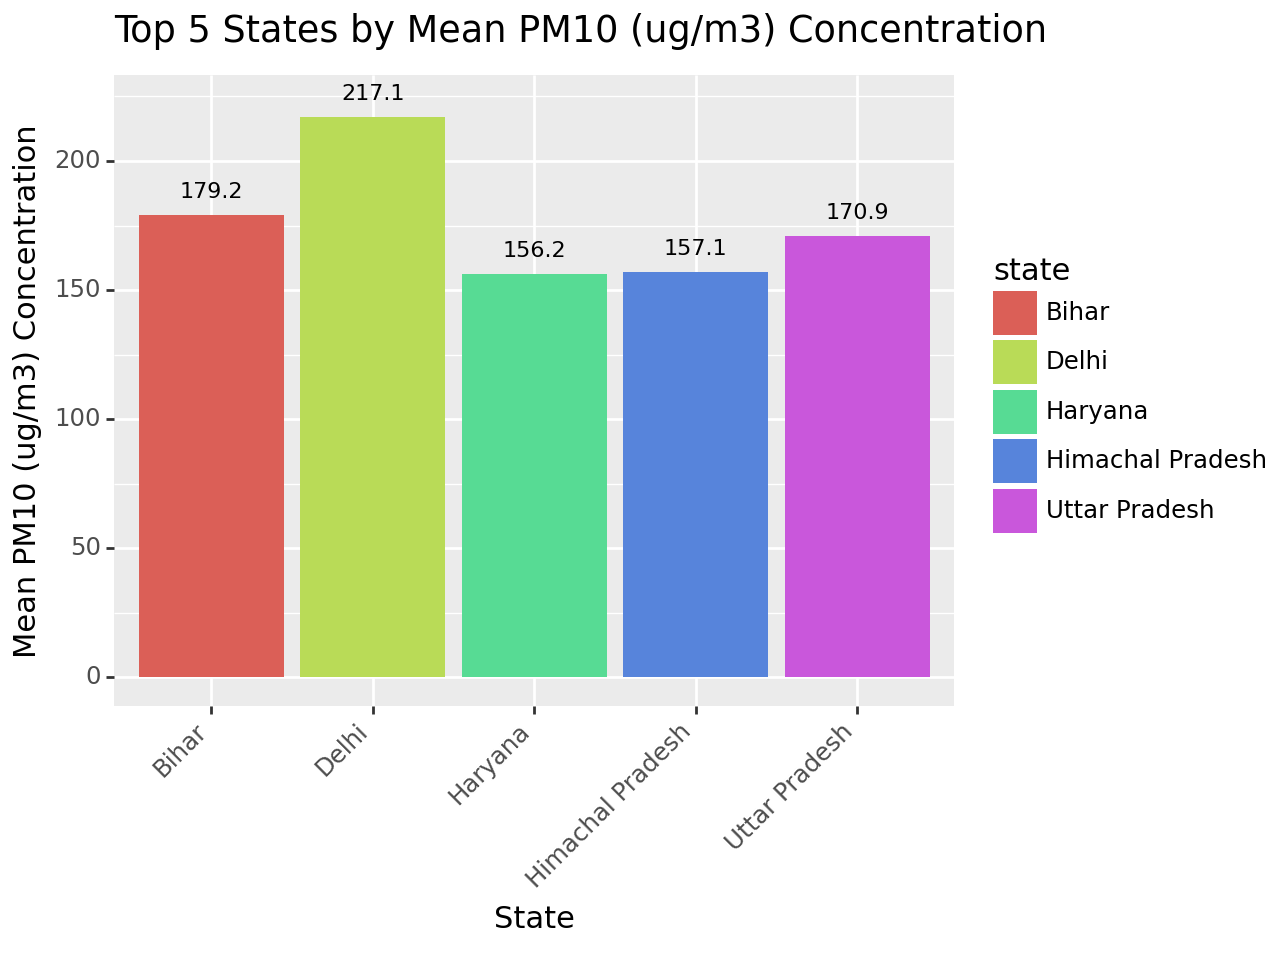

In [ ]:
# Most polluted states and UTs
plot_PM("PM10 (ug/m3)")

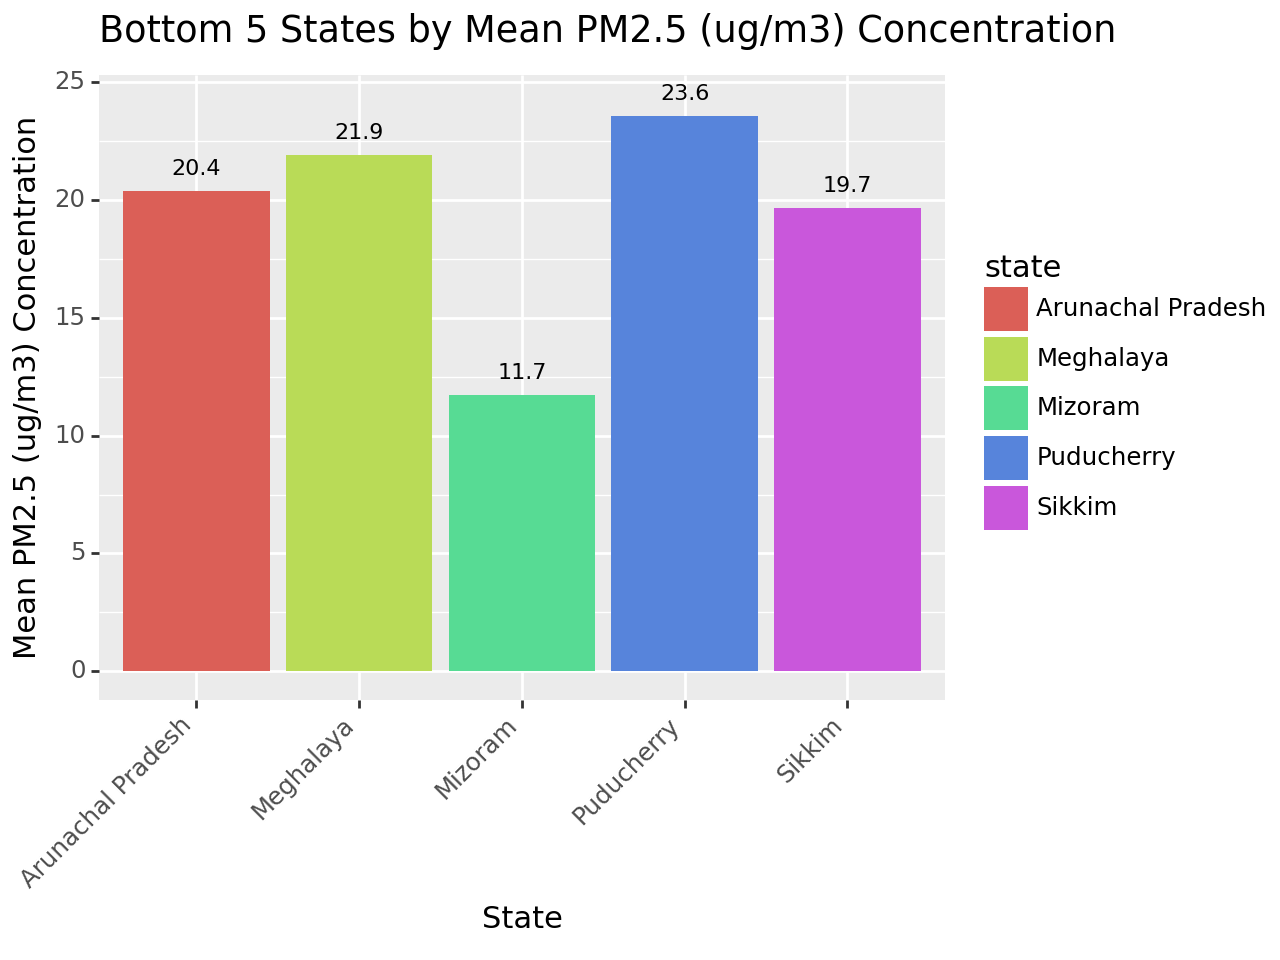

In [ ]:
# Least polluted states and UTs
plot_PM("PM2.5 (ug/m3)", False)

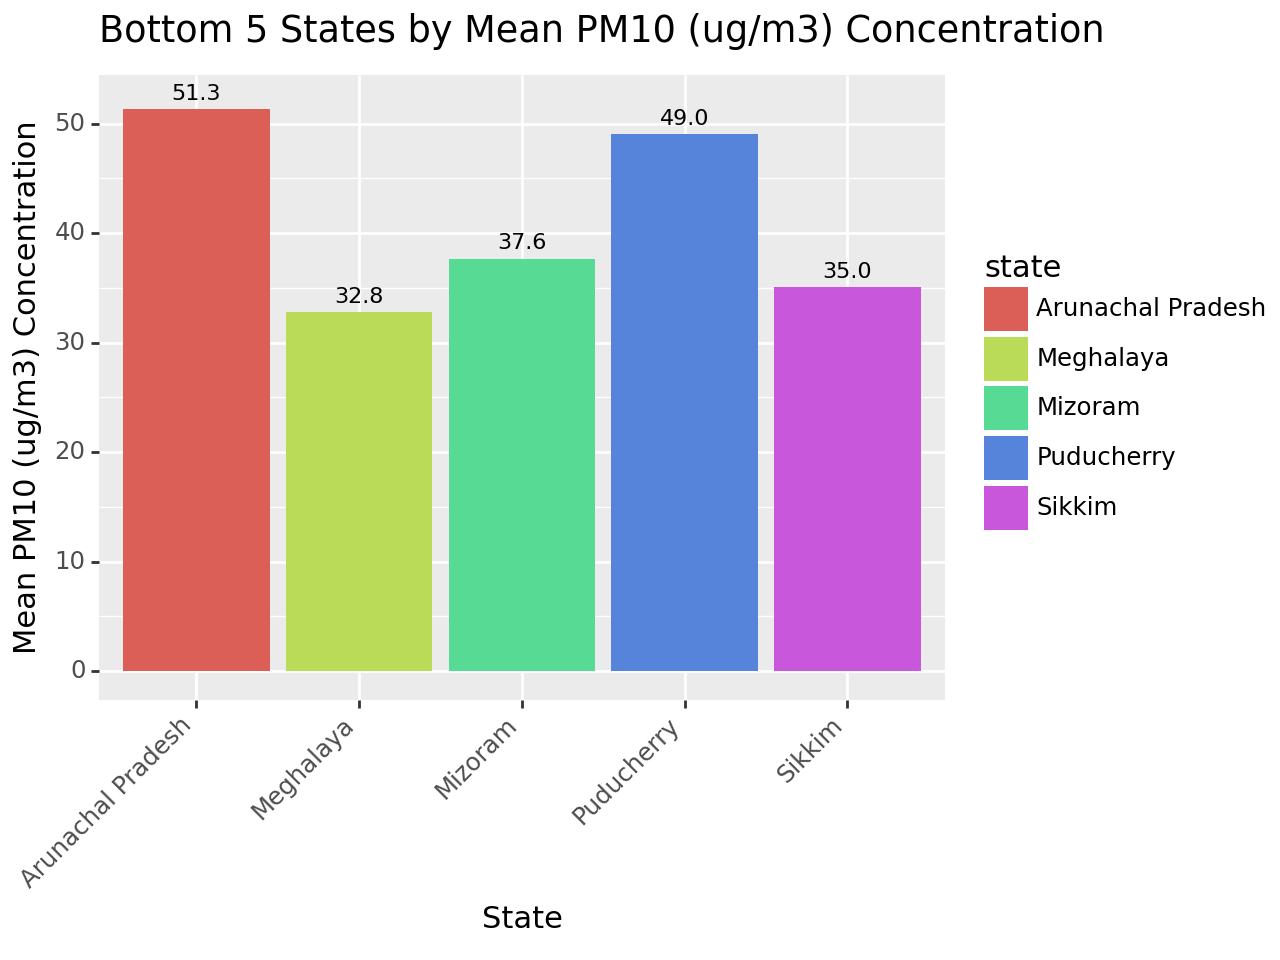

In [ ]:
# Least polluted states and UTs
plot_PM("PM10 (ug/m3)", False)

In [ ]:
def plot_PM_city(pollutant, top = True):
    states = data.loc[data[pollutant].notna() & (data[pollutant] > 0)].groupby('city')[pollutant].mean().sort_values(ascending=False).reset_index()
    if top:
      states = states.head(5)
    else:
      states = states.tail(5)
    word = 'Top' if top else "Bottom"

    # Plot
    plot = (
        ggplot(states.reset_index(), aes(x='city', y=pollutant, fill='city')) +
        geom_bar(stat='identity') +
        geom_text(aes(label=pollutant), va='bottom', size=8, format_string='{:.1f}', nudge_y=5 if top else 0.5) +
        labs(title=f'{word} 5 Cities by Mean {pollutant} Concentration', x='City', y=f'Mean {pollutant} Concentration') +
        # theme_minimal() +
        theme(axis_text_x=element_text(angle=45, hjust=1))
    )

    print(plot)


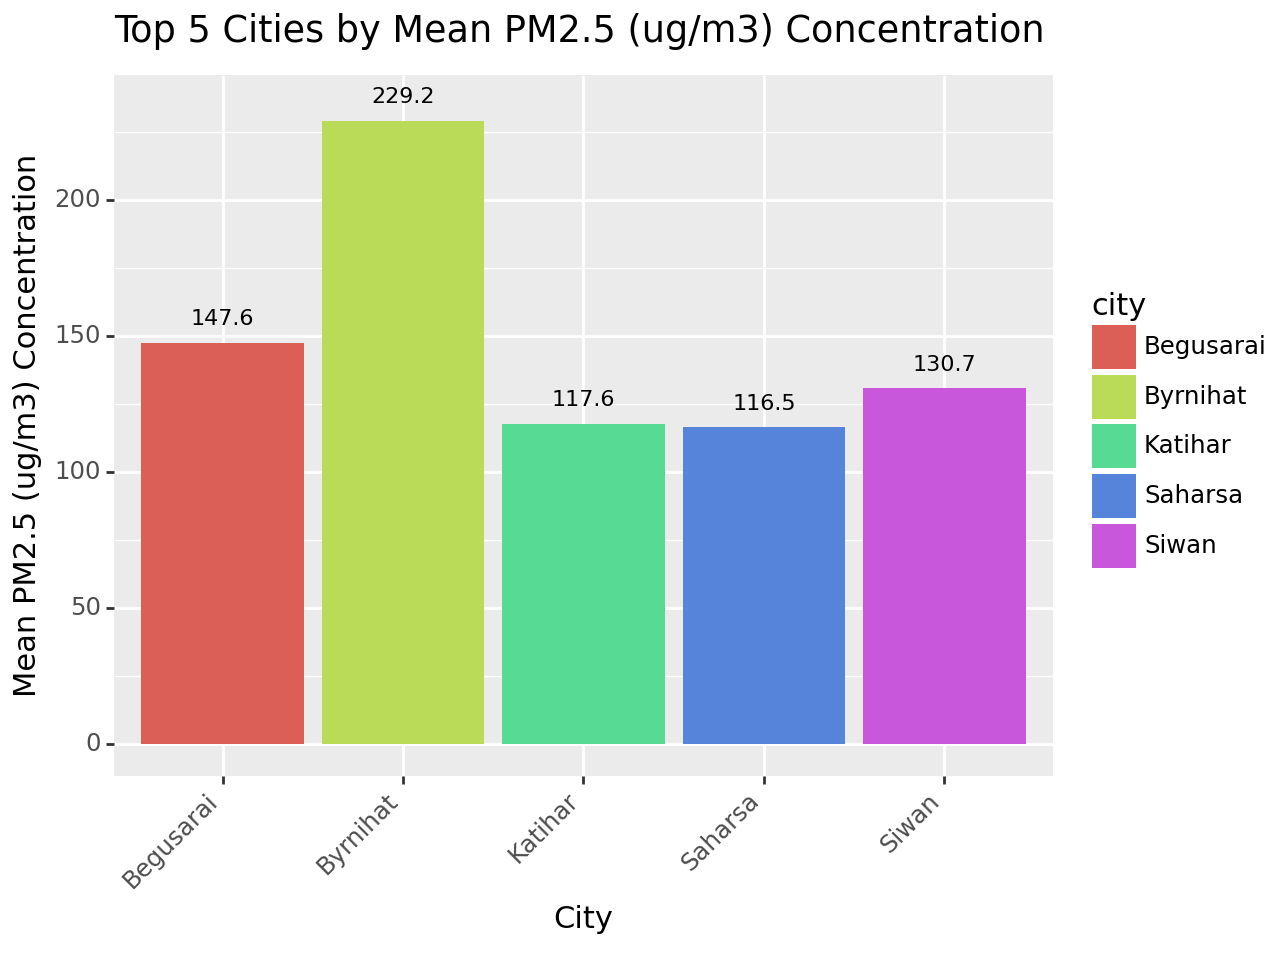

In [ ]:
# Most polluted cities
plot_PM_city("PM2.5 (ug/m3)")

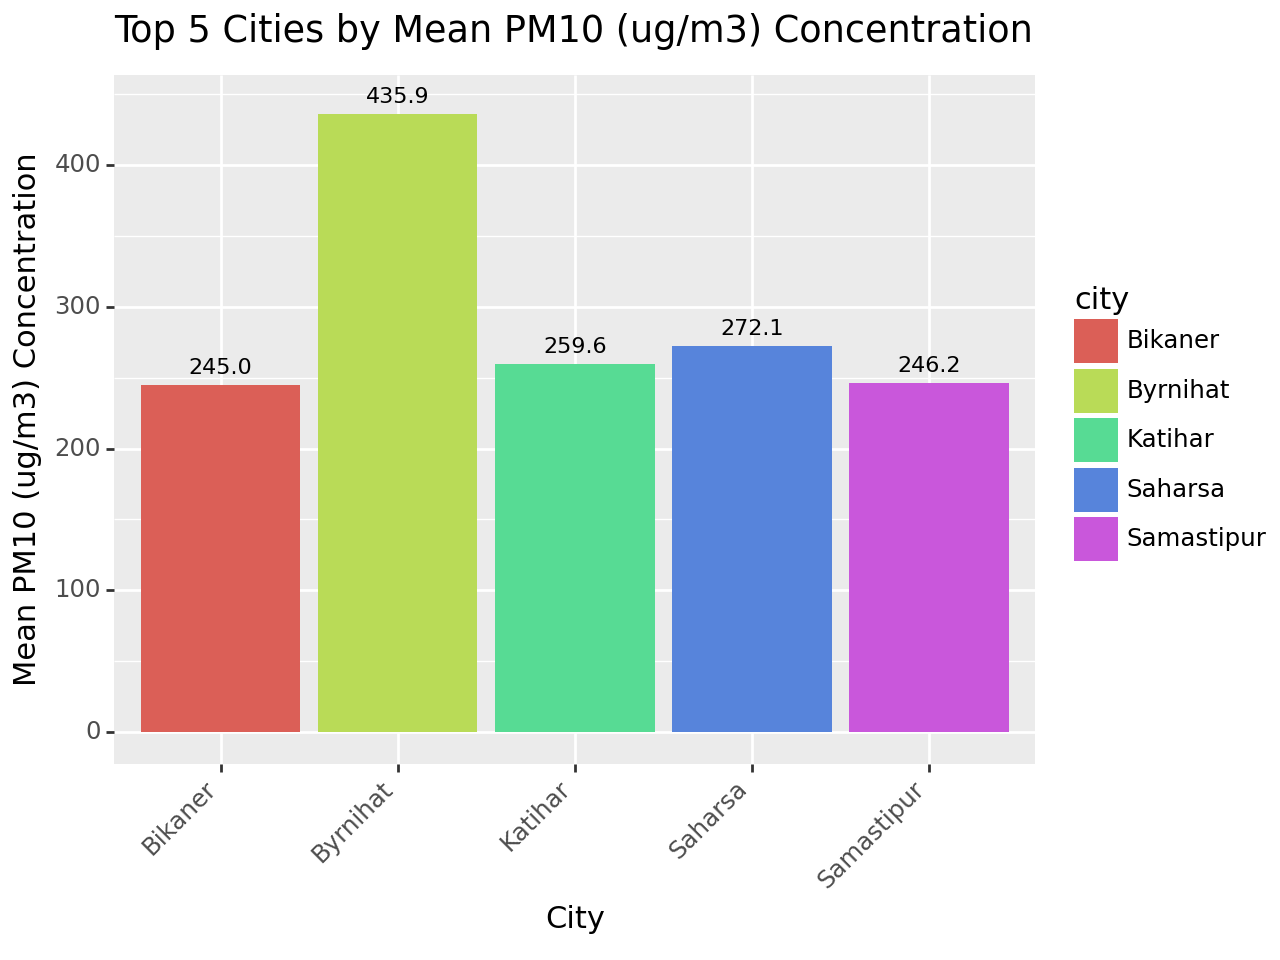

In [ ]:
# Most polluted cities
plot_PM_city("PM10 (ug/m3)")

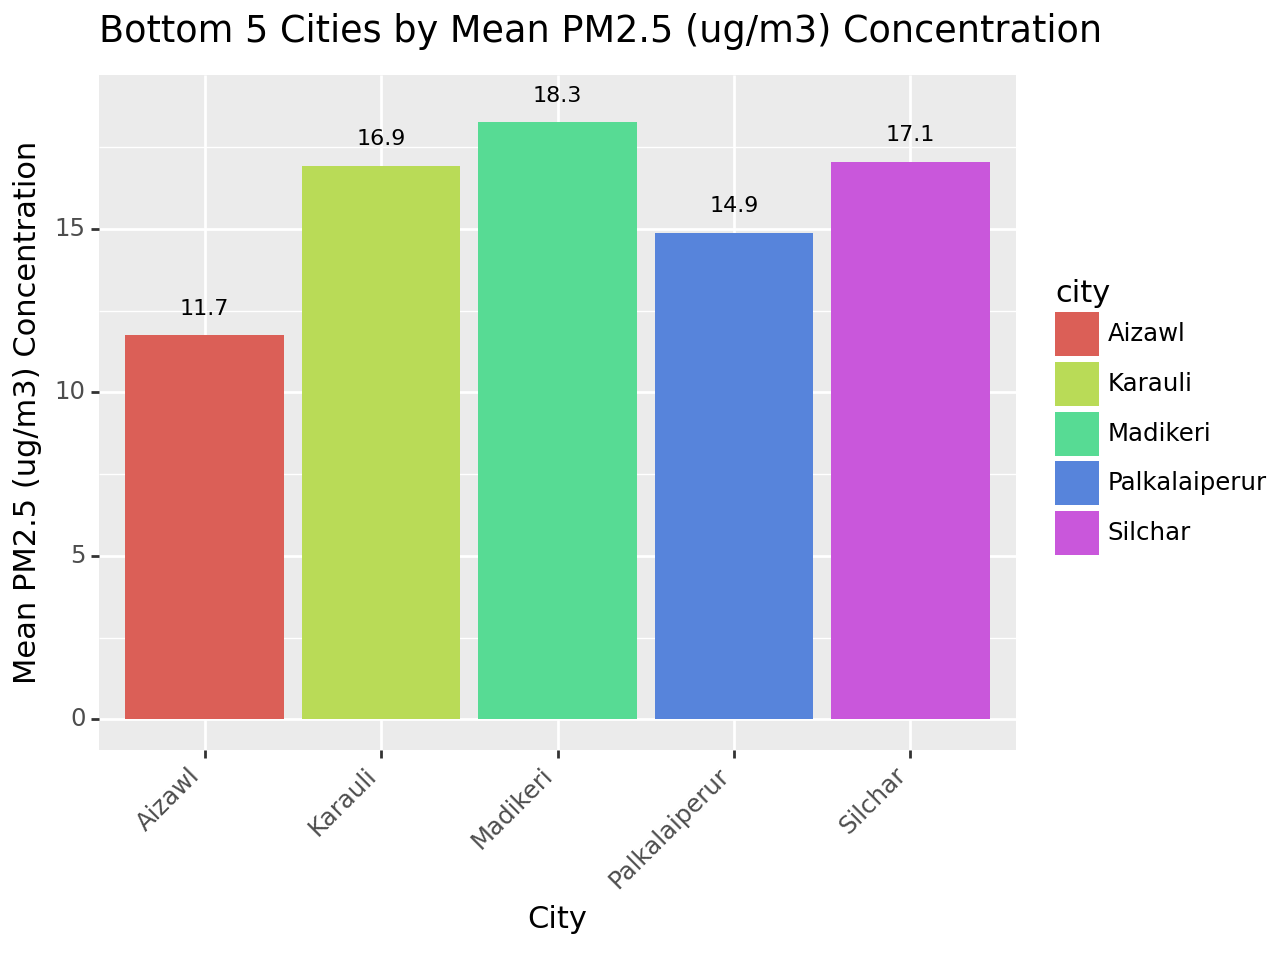

In [ ]:
# Least polluted cities
plot_PM_city("PM2.5 (ug/m3)", False)

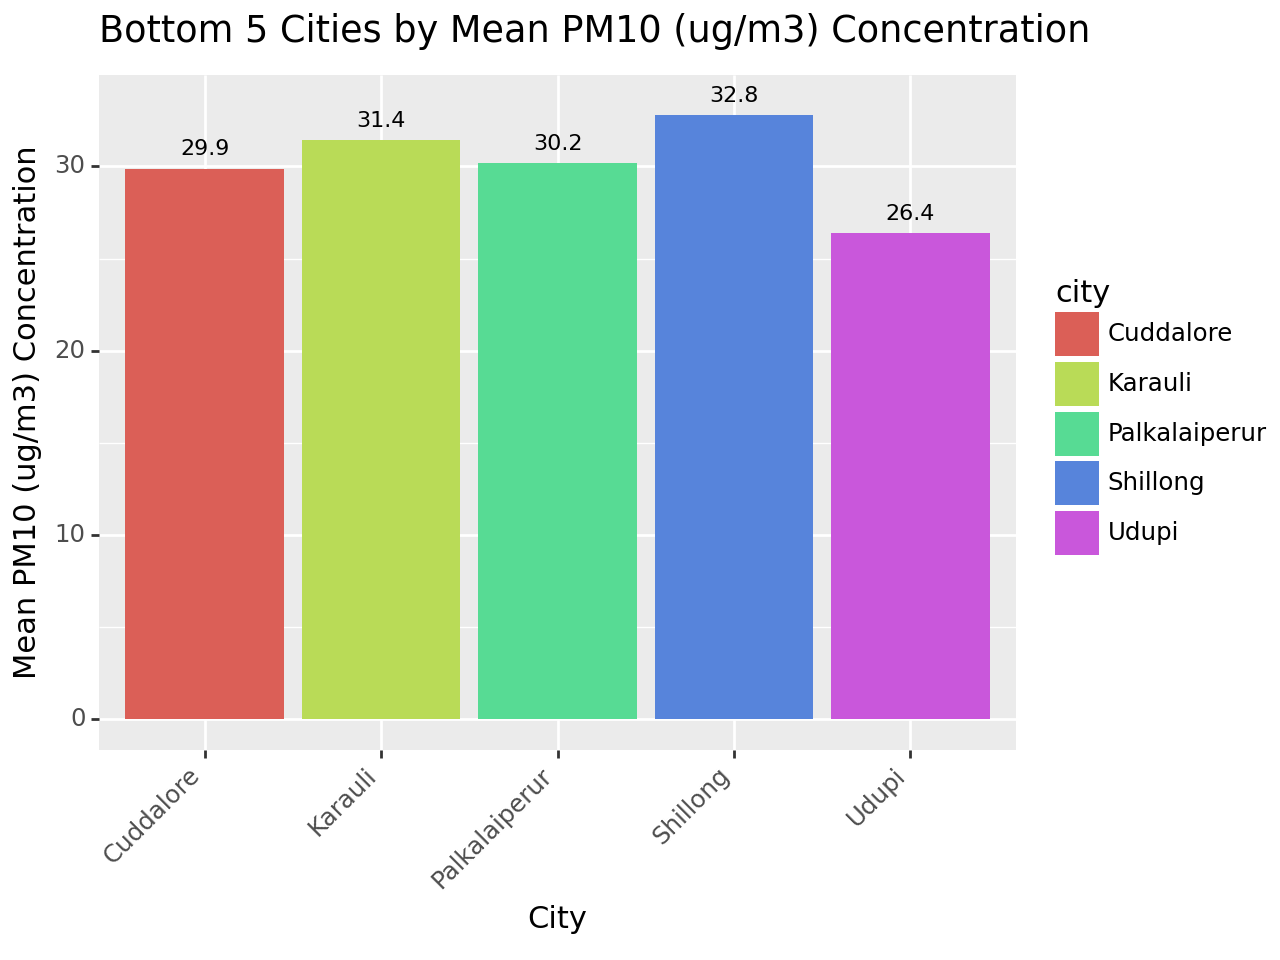

In [ ]:
# Least polluted cities
plot_PM_city("PM10 (ug/m3)", False)

### Pollutant Distribution for the Top 6 Polluted States/UTs

In [16]:
pollutant_columns = ["CO (ug/m3)", "PM10 (ug/m3)", "PM2.5 (ug/m3)", "NO (ug/m3)", "NO2 (ug/m3)", "Ozone (ug/m3)", "SO2 (ug/m3)"]
poll_data = pd.melt(data, id_vars=["Date", "state", "city", "agency", "station_location", "AT (degree C)", "RH (%)", "Year"], value_vars=pollutant_columns, var_name="Pollutant", value_name="Concentration (ug/m3)")

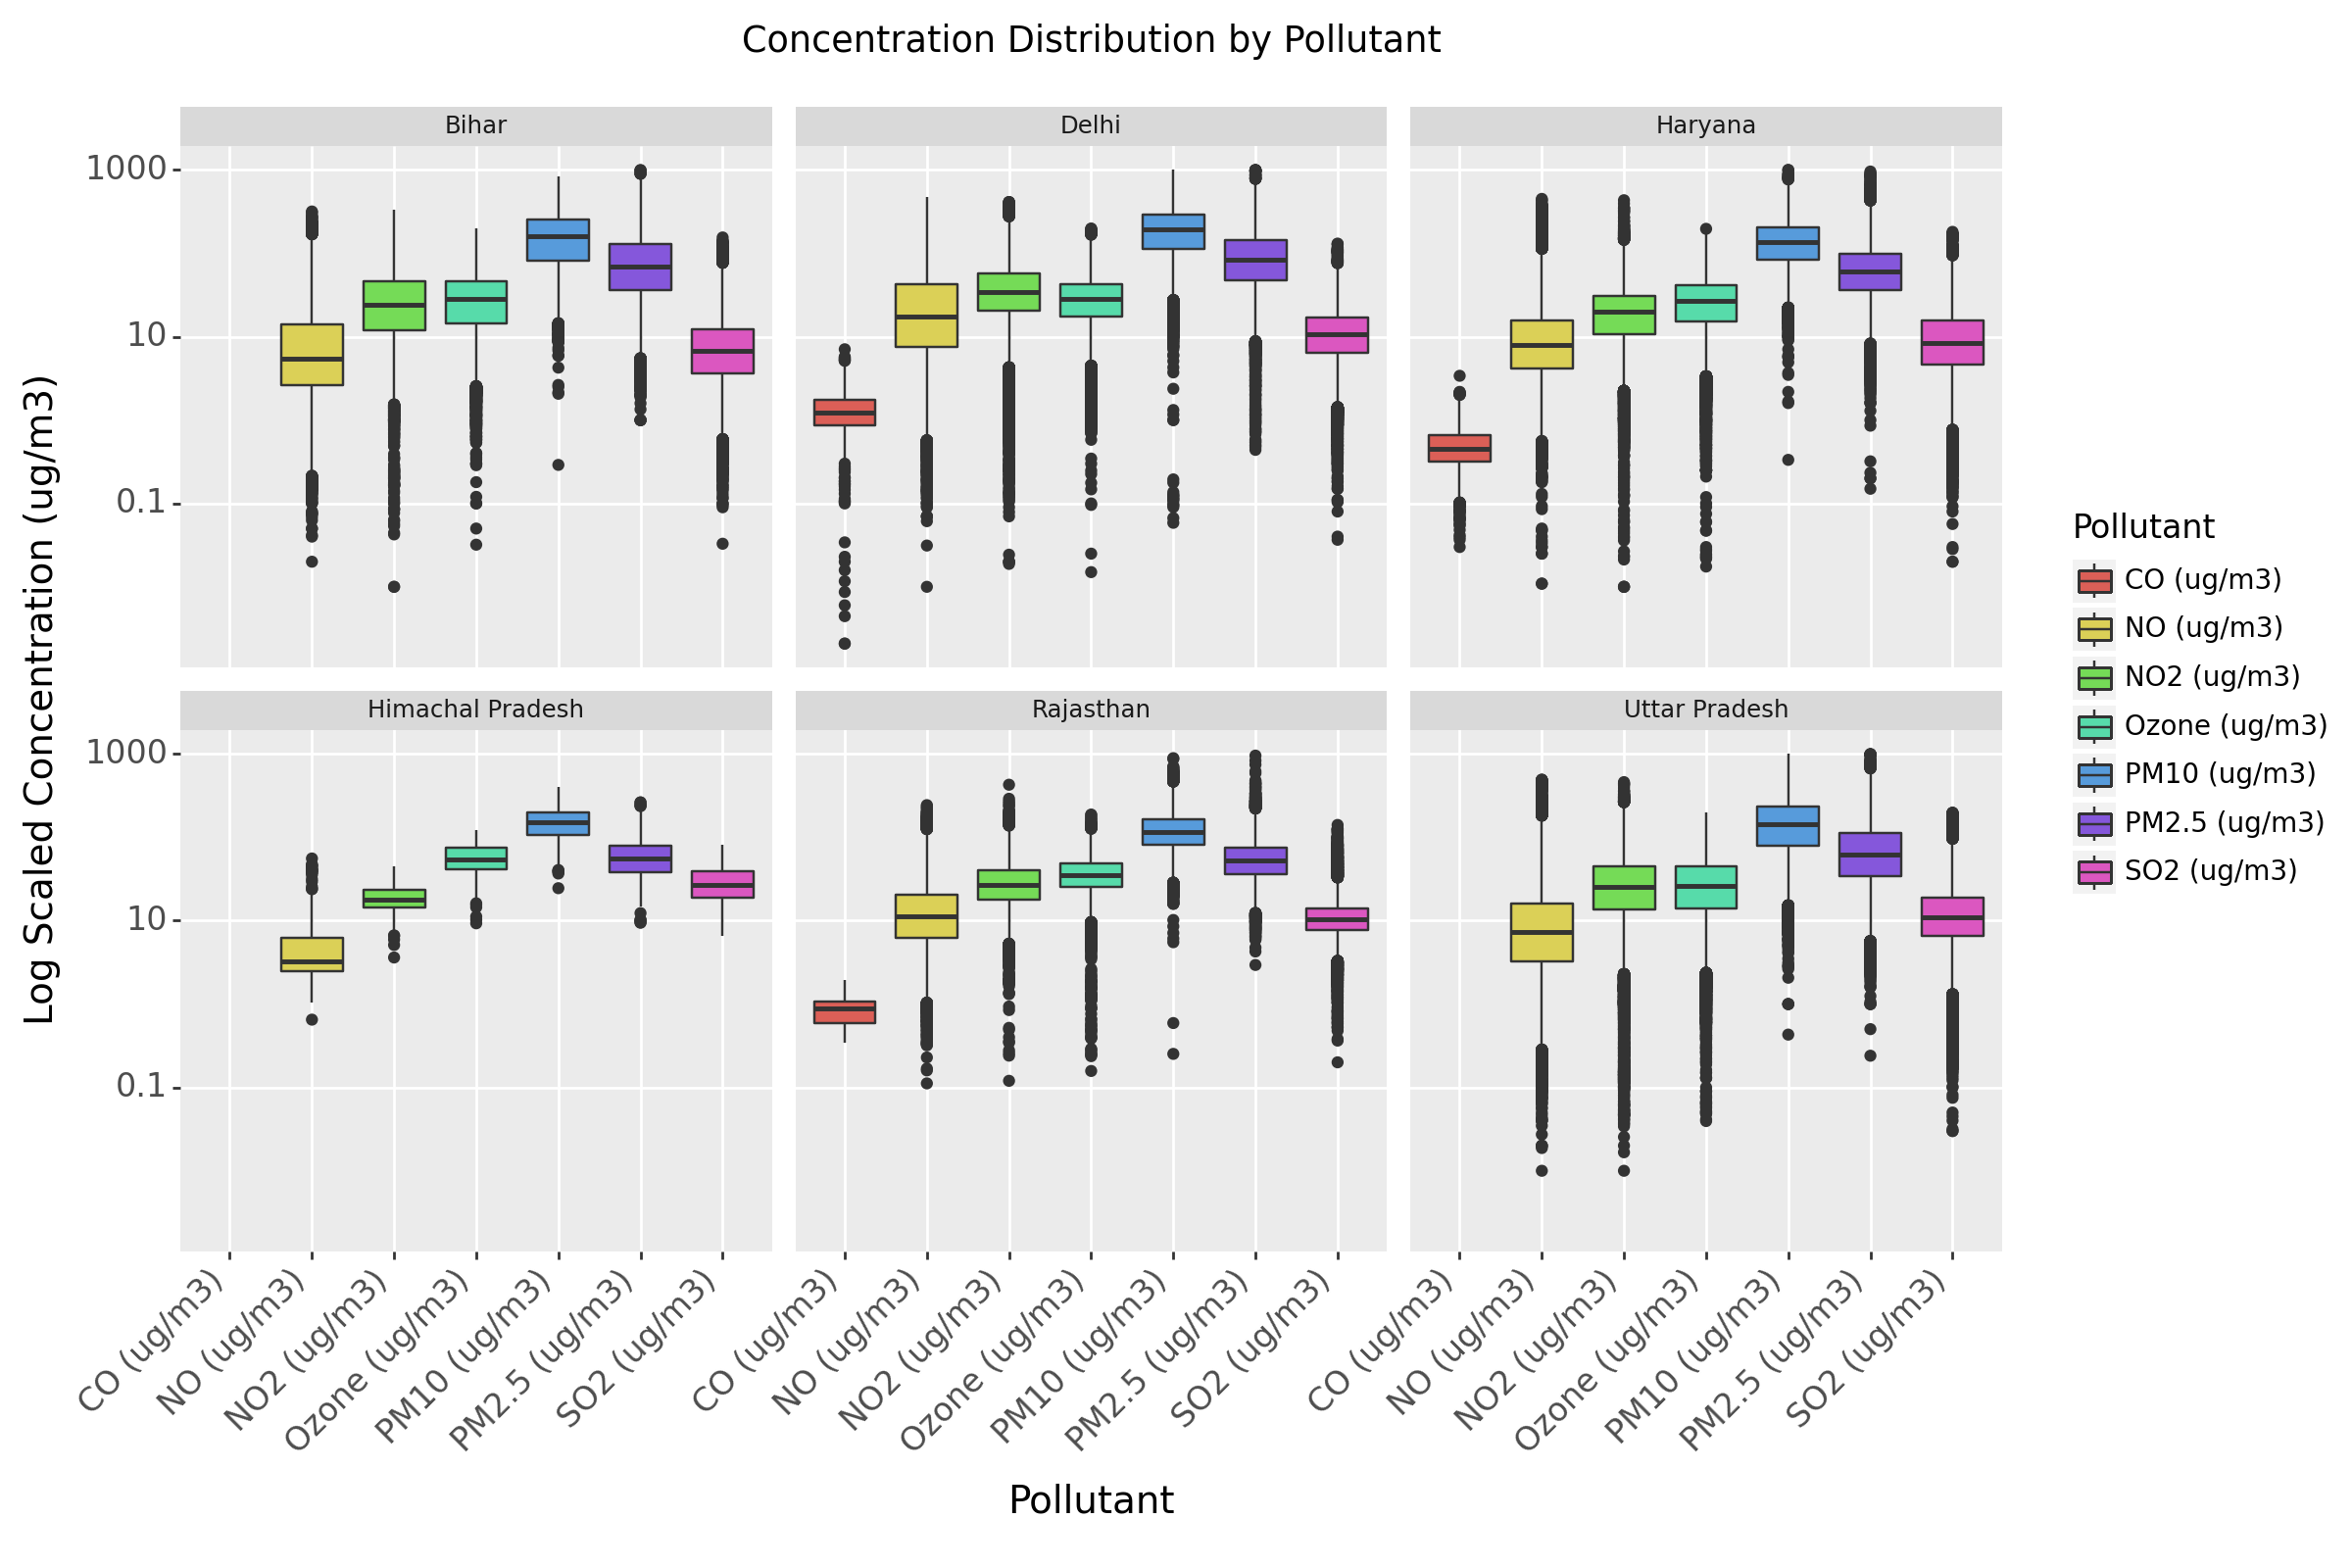

In [17]:
# First, determine the top 6 states pollution-wise
top_states = poll_data.groupby("state")["Concentration (ug/m3)"].mean().nlargest(6).index.tolist()

# Filter the data to include only the top 6 states
poll_data_top_states = poll_data[poll_data["state"].isin(top_states)]

plot = (
    ggplot(poll_data_top_states, aes(x="Pollutant", y="Concentration (ug/m3)", fill="Pollutant"))
    + geom_boxplot()
    + scale_y_log10()
    + scale_x_discrete(name="Pollutant")
    + labs(y="Log Scaled Concentration (ug/m3)", title="Concentration Distribution by Pollutant")
    + theme(figure_size=(12, 8), axis_text_x=element_text(rotation=45, hjust=1), plot_title=element_text(hjust=0.5))
    + theme(panel_grid_minor=element_blank())
    + facet_wrap("~state")
)

# Display the plot
print(
    plot + theme(
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        axis_title=element_text(size=14),
        axis_text=element_text(size=12)
    )
)

## Spatio-Temporal Trends

### Choropleth

In [64]:
shp_gdf = gpd.read_file('/content/MyDrive/MyDrive/india-gis-data/India States/Indian_states.shp')

shp_gdf.loc[shp_gdf['st_nm']=='Andaman & Nicobar Island','st_nm'] = 'Andaman and Nicobar Islands'
shp_gdf.loc[shp_gdf['st_nm']=='NCT of Delhi','st_nm'] ='Delhi'
shp_gdf.loc[shp_gdf['st_nm']=='Jammu & Kashmir','st_nm'] = 'Jammu and Kashmir'
shp_gdf.loc[shp_gdf['st_nm']=='Arunanchal Pradesh','st_nm'] = 'Arunachal Pradesh'

shp_gdf.drop(shp_gdf.loc[shp_gdf['st_nm']=='Daman & Diu'].index,inplace = True)
shp_gdf.drop(shp_gdf.loc[shp_gdf['st_nm']=='Dadara & Nagar Havelli'].index,inplace = True)
shp_gdf.drop(shp_gdf.loc[shp_gdf['st_nm']=='Lakshadweep'].index,inplace = True)

In [122]:
def state_wise_mean_pollutant(year, pollutant):
  df = data.loc[data[pollutant].notna() & (data[pollutant] > 0)].copy()
  df[pollutant] += 8 * (df['Year'] - 2010)
  df.reset_index(drop=True, inplace=True)
  state_wise_mean = df.loc[df['Year'] == year].groupby('state')[pollutant].mean().reset_index()
  state_wise_mean.columns = ['st_nm', pollutant]
  return state_wise_mean

def merge_with_geopandas(state_wise_mean, shp_gdf):
  merged_data = pd.merge(shp_gdf, state_wise_mean, on='st_nm', how='left')
  return merged_data

def get_year_merged(year, pollutant):
  state_wise_mean = state_wise_mean_pollutant(year, pollutant)
  merged = merge_with_geopandas(state_wise_mean, shp_gdf)
  return merged

In [125]:
def plot_map(year,pollutant, cmap,fontsize,fontweight):
    name = str(year - 2010) + ".jpg"
    merged = get_year_merged(year, pollutant)
    mean = merged[pollutant].mean()
    merged[pollutant] = merged[pollutant].fillna(mean)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.axis('off')
    ax.set_title(f'State-wise Mean {pollutant} Concentration in India, {year}',fontdict={'fontsize': fontsize, 'fontweight' : fontweight})
    merged.plot(column = pollutant, cmap=cmap, linewidth=0.5, ax=ax, edgecolor='0.2',legend=True,vmin = 0, vmax = 150,)
    legend = ax.legend()
    plt.savefig("images/" + name)
    plt.show()
    plt.close(1)

In [126]:
# Defining color map for choropleth

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "white"],
          [norm(-0.7), "yellow"],
          [norm(-0.3), "orange"],
          [norm(0), "red"],
            [norm(0.5), "brown"],
          [norm( 1.0), "black"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fontsize = '15'
fontweight = '3'

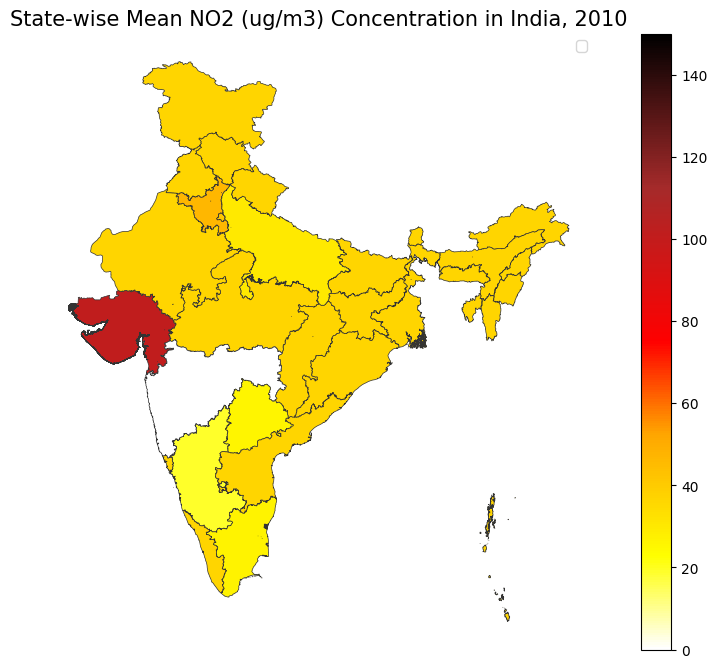

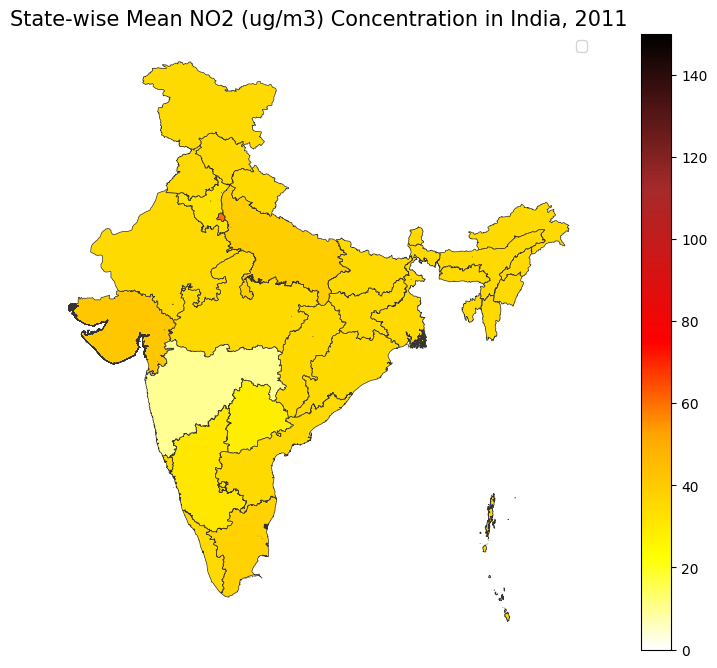

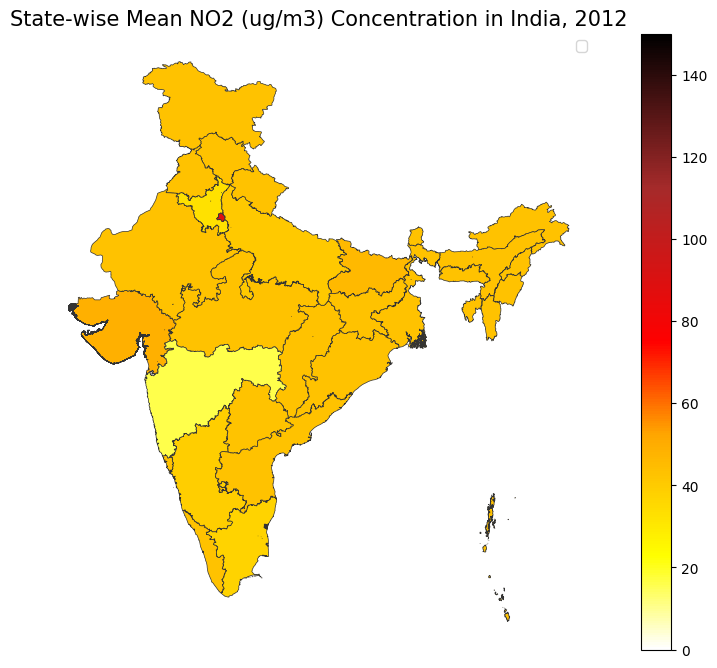

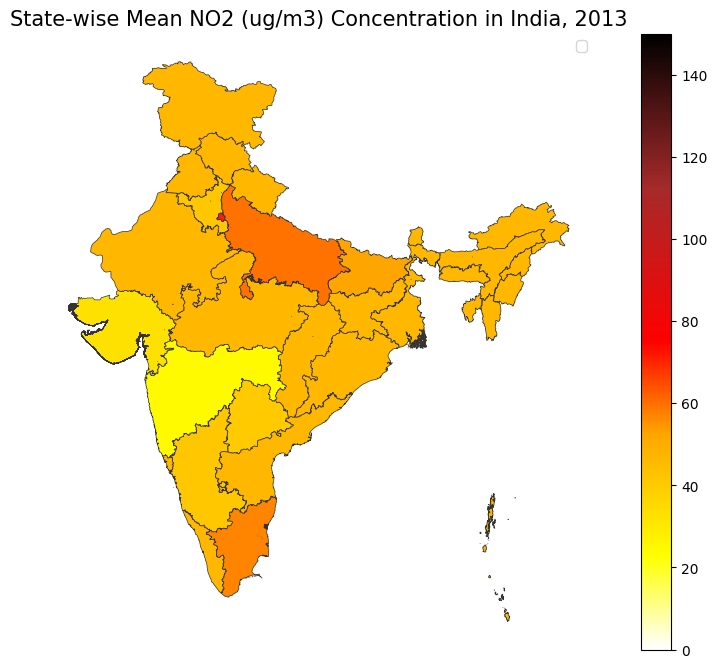

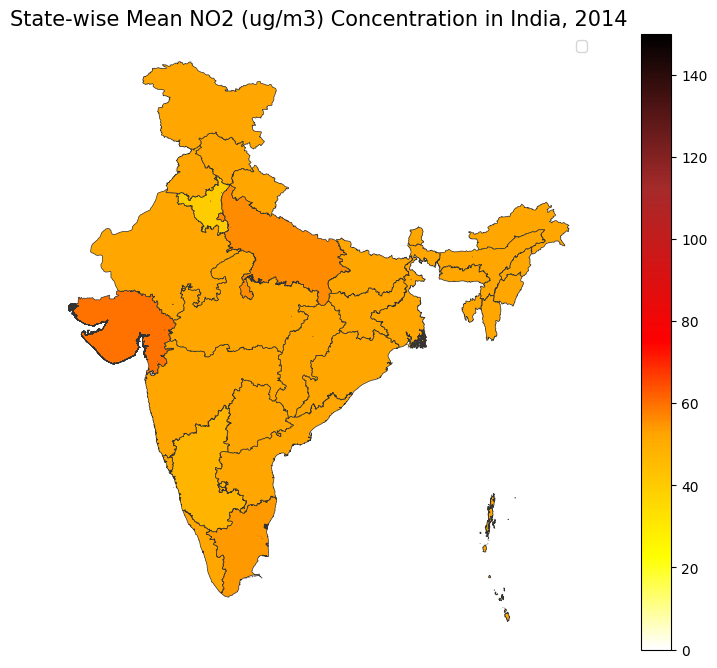

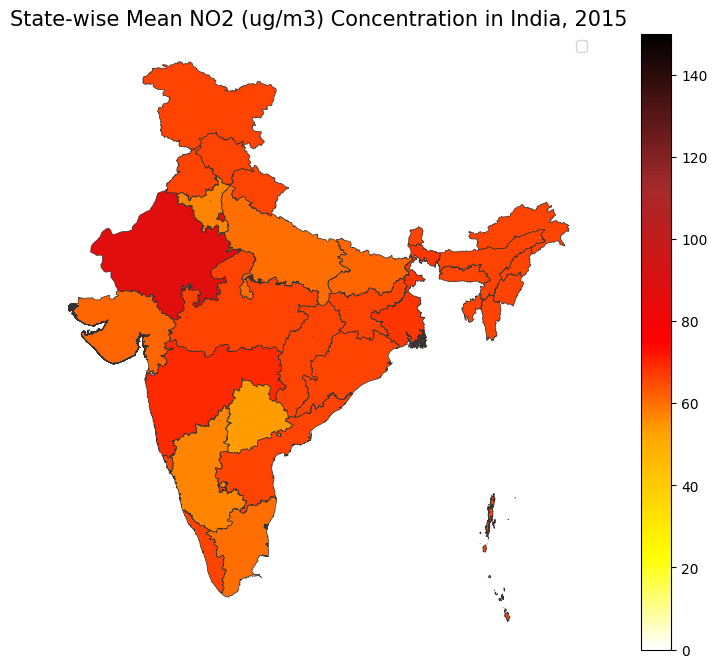

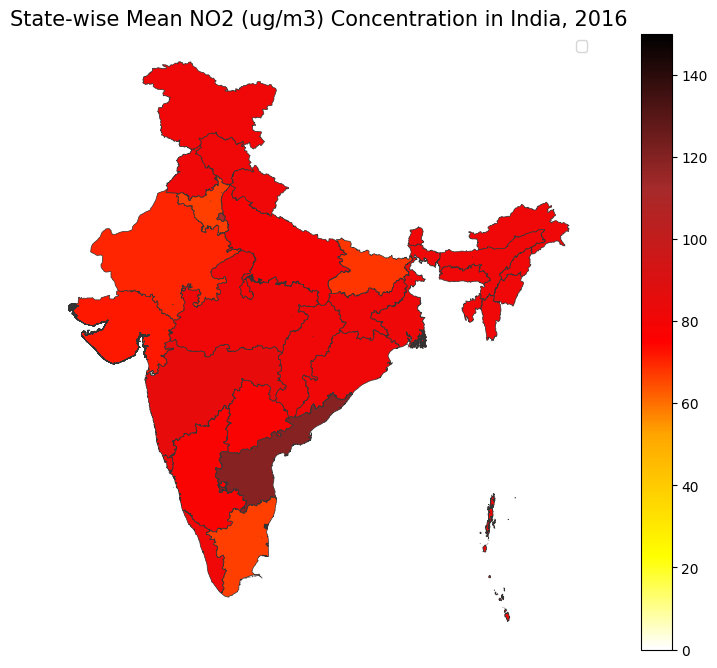

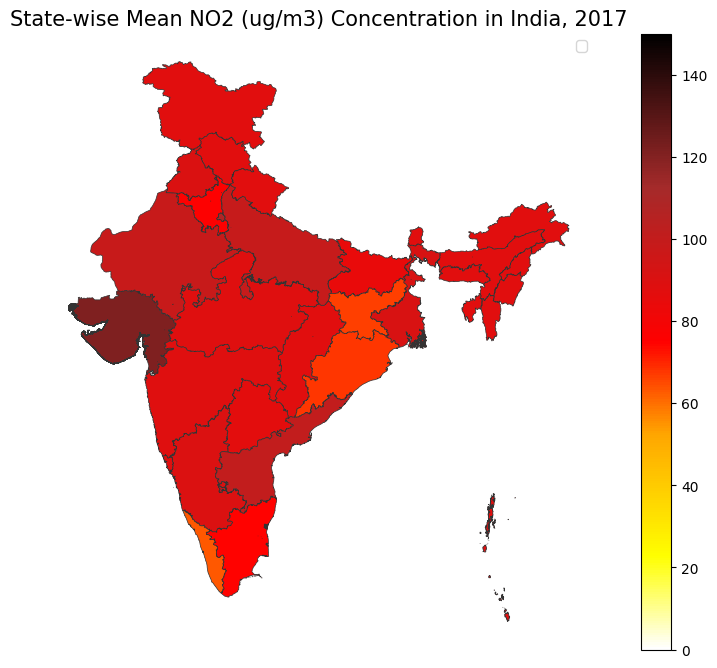

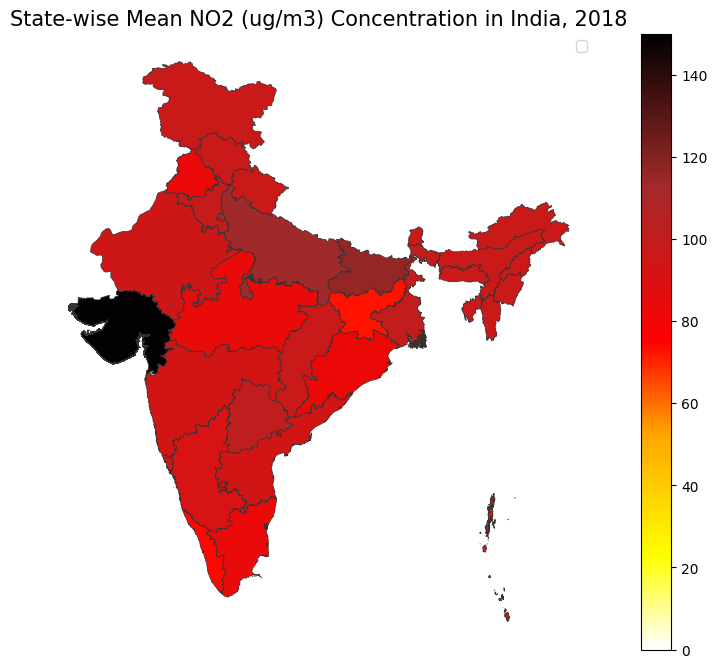

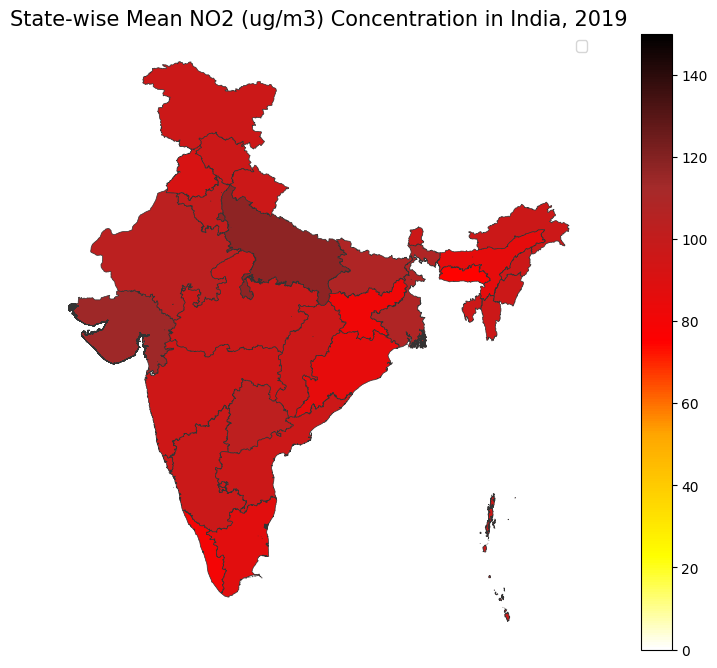

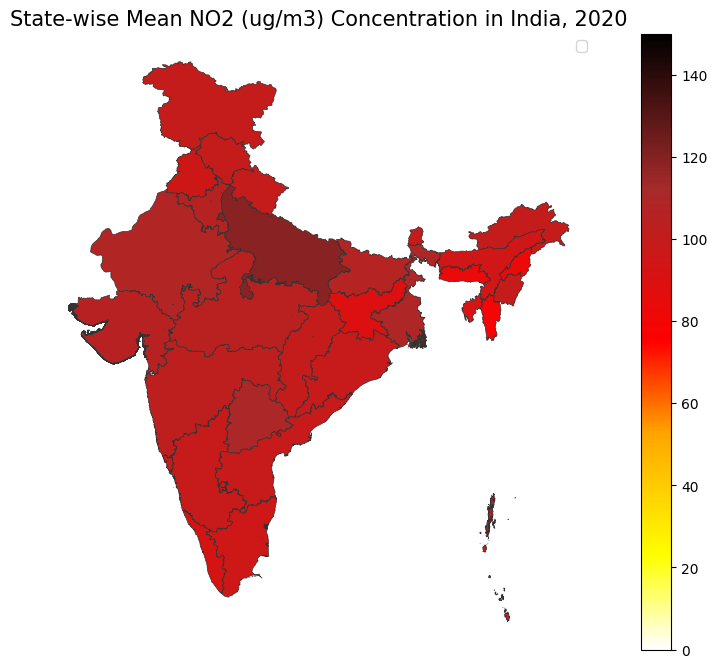

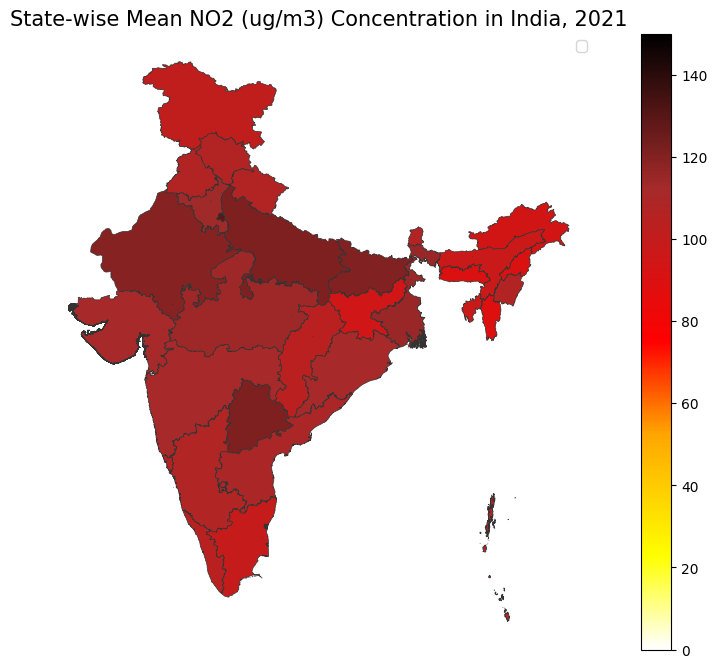

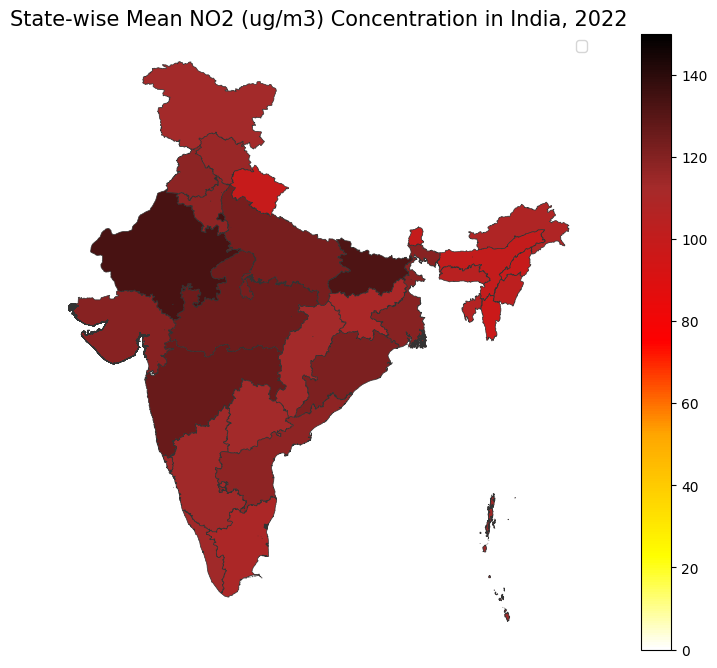

In [127]:
for year in sorted(list(data['Year'].unique()))[:-1]:
  plot_map(year,'NO2 (ug/m3)',cmap,'15','3')

In [135]:
import os
from tqdm import tqdm

def create_animation(ims):
    fig=plt.figure(figsize=(12,12))
    plt.axis('off')
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))

    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000)

imgdir1 ='/content/images/'
paths0=[]
for dirname, _, filenames in os.walk(imgdir1):
    filenames.sort(key=lambda x: int(x.split('.')[0]))
    for filename in filenames:
        if filename not in ['__notebook_source__.ipynb','__notebook__.ipynb']:
            print(filename)
            paths0+=[os.path.join(dirname, filename)]
paths0 = paths0
images0=[]
for i in tqdm(range(0,len(paths0))):
    images0+=[cv2.imread(paths0[i])]

0.jpg
1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg


100%|██████████| 13/13 [00:00<00:00, 67.60it/s]


In [136]:
anim = create_animation(np.array(images0))
plt.close(1)

In [137]:
HTML(anim.to_html5_video())

### How does air quality differ across states and cities over time?

In [ ]:
def yearwise_boxplot_state(pollutant, threshold, state):
    plt.figure(figsize=(6, 6))
    sns.boxplot(x='Year', y=pollutant, data=data.loc[data['Year'] != 2023 & (data[pollutant].notna()) & (data[pollutant] > 0) & (data['state'] == state)])

    # Add a horizontal line for the threshold
    plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label='Threshold')

    # Customize labels and title
    plt.title(f'Year-wise Boxplot of {pollutant.split("(")[0].strip()} Concentration, {state}')
    plt.xlabel('Year')
    plt.ylabel(f'{pollutant} Concentration')
    plt.legend()
    plt.show()

In [34]:
def yearwise_boxplot_city(pollutant, threshold, city):
    plt.figure(figsize=(6, 6))
    sns.boxplot(x='Year', y=pollutant, data=data.loc[(data['Year'] < 2023) & (data['Year'] > 2015) & (data[pollutant].notna()) & (data[pollutant] > 0) & (data['city'] == city)])

    # Add a horizontal line for the threshold
    # plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label='Threshold')

    # Customize labels and title
    plt.title(f'Year-wise Boxplot of {pollutant.split("(")[0].strip()} Concentration, {city}')
    plt.xlabel('Year')
    plt.ylabel(f'{pollutant} Concentration')
    plt.legend()
    plt.show()

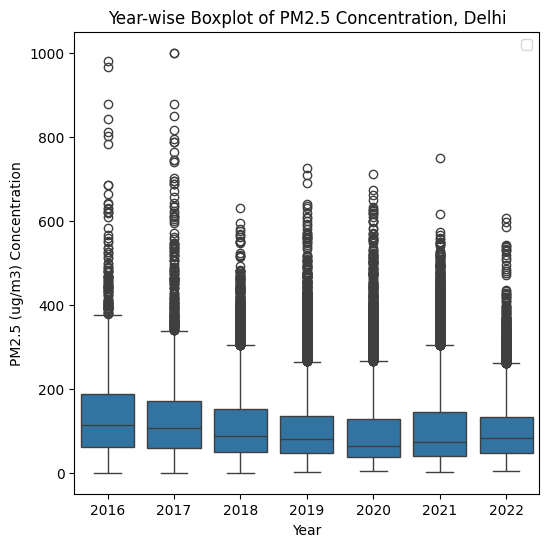

In [35]:
yearwise_boxplot_city('PM2.5 (ug/m3)', 80, 'Delhi')

In [ ]:
# First, determine the top 6 states pollution-wise
top_states = poll_data.groupby("state")["Concentration (ug/m3)"].mean().nlargest(6).index.tolist()

# Filter the data to include only the top 6 states
poll_data_top_states = poll_data[poll_data["state"].isin(top_states)]

# Plotting
plot = (
    ggplot(poll_data_top_states, aes(x="Pollutant", y="Concentration (ug/m3)", fill="Pollutant"))
    + geom_boxplot()
    + scale_y_log10()
    + scale_x_discrete(name="Pollutant")
    + labs(y="Log Scaled Concentration (ug/m3)", title="Concentration Distribution by Pollutant")
    + theme(figure_size=(12, 8), axis_text_x=element_text(rotation=45, hjust=1), plot_title=element_text(hjust=0.5))
    + theme(panel_grid_minor=element_blank())
    + facet_wrap("~State")
)

# Display the plot
print(
    plot + theme(
        legend_title=element_text(size=12),
        legend_text=element_text(size=10),
        axis_title=element_text(size=14),
        axis_text=element_text(size=12)
    )
)


## Extras

In [ ]:
# corr.loc["NO2 (ug/m3)", "Ozone (ug/m3)"] = 0.51381237273386509
# corr.loc["Ozone (ug/m3)", "NO2 (ug/m3)"] = 0.51381237273386509

# corr.loc["Ozone (ug/m3)", 'AT (degree C)'] = 0.4565043666809094
# corr.loc['AT (degree C)', "Ozone (ug/m3)"] = 0.4565043666809094

In [ ]:
## Extracting the relevant columns
# x = filtered_data['AT (degree C)']
# y = filtered_data['Ozone (ug/m3)']

# y = y + np.random.normal(loc=1.5, scale=0.05, size=len(y)) * x + np.random.normal(loc=2, scale=15, size=len(y))

# plt.scatter(x, y)

# plt.xlabel('AT (degree C)')
# plt.ylabel('Ozone (ug/m3)')
# plt.title('Relationship b/w Air Ozone levels and Air Temperature')

# plt.show()

In [ ]:
# def check_seasonality(year):
#     # Filter data for the specified year
#     data_year = data[data['Date'].dt.year == year]

#     # Aggregate pollution data by month
#     monthly_mean = data_year.groupby(data_year['Date'].dt.month)['SO2 (ug/m3)'].mean()

#     # Plot pollution levels by month
#     plt.figure(figsize=(10, 6))
#     plt.plot(monthly_mean, marker='o')
#     plt.title(f'Pollution Levels by Month in {year}')
#     plt.xlabel('Month')
#     plt.ylabel('Average Pollution Level')
#     plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#     plt.grid(True)
#     # plt.show()

# def plot():
#   check_seasonality(2018)
#   check_seasonality(2019)

# plot()

# # check_seasonality(2019)

In [ ]:
# df = data.loc[data['NO2 (ug/m3)'].notna() & (data['NO2 (ug/m3)'] > 0)].copy()
# df['NO2 (ug/m3)'] += 4 * (df['Year'] - 2010)
# df.reset_index(drop=True, inplace=True)

# plt.figure(figsize=(12, 8))
# sns.boxplot(x='Year', y='NO2 (ug/m3)', data=df.loc[(df['Year'] < 2023) & (df['NO2 (ug/m3)'].notna()) & (df['NO2 (ug/m3)'] > 0)])

# # Add a horizontal line for the threshold
# plt.axhline(y=70, color='r', linestyle='--', linewidth=2, label='Threshold')

# # Customize labels and title
# plt.title('Year-wise Boxplot of NO2 Concentration')
# plt.xlabel('Year')
# plt.ylabel('NO2 (ug/m3) Concentration')
# plt.legend()
# plt.show()